## Analyzing video game sales over the world to spot potential winners

<span style="color:blue">**Project description:**</span> In this project, we work for the online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. You need to identify patterns that determine whether a game succeeds or not. This will allow you to spot potential big winners and plan advertising campaigns.In front of you is data going back to 2016. Let’s imagine that it’s December 2016 and you’re planning a campaign for 2017.

### Table of Contents

* [Step 1](#step1) Format and structure of games data
    * [Step 1.1](#step1_1) Open the data file and study the general information 
    * [Step 1.2](#step1_2) Description of data columns
* [Step 2](#step2) Data preprocessing
* [Step 3](#step3) Prognosis for video game market in 2017 
* [Step 4](#step4) Regional user preference profiles for each region
* [Step 5](#step5) Hypothesis testing
    * [Step 5.1](#step5_1) Testing Hypothesis 1
    * [Step 5.2](#step5_2) Testing Hypothesis 2
* [Step 6](#step6) General conclusions


<span style="color:blue">**Importing libraries:**</span> We close the introduction by importing all code libraries and defining output style functions we will be using in our project. 

In [1]:
# Import libraries and define output style functions.

# Import the pandas library 
#      (url-> https://pandas.pydata.org/).
import pandas as pd

# Import the numpy library 
#      (url-> https://pandas.pydata.org/).
import numpy as np

# Import stats module from scipy  
#      (url-> https://https://www.scipy.org/).
from scipy import stats as st

# Import pyplot module from matplotlib 
#      (url-> https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.html).
import matplotlib.pyplot as plt

# Import Markdown and display modules from IPython.display library 
#      (url -> https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html).
from IPython.display import Markdown, display
# Define printmd() function to print code in blue color.
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

# Import libraries to help read csv file from google drive 
import requests
from io import StringIO


In [2]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

<a class="anchor" id="step1"></a> 
### Step 1.  Format and structure of games data

We are provided with the following dataset path:
- /datasets/games.csv 

We are also handed the following information about the fields on these datasets:

<span style="color:blue">**Games Dataset**</span>  
- <span style="color:purple">**Name:**</span>  
- <span style="color:purple">**Platform:**</span>  
- <span style="color:purple">**Year_of_Release:**</span>  
- <span style="color:purple">**Genre:**</span>  
- <span style="color:purple">**NA_sales:**</span> North American sales in USD million
- <span style="color:purple">**EU_sales:**</span> sales in Europe in USD million
- <span style="color:purple">**JP_sales:**</span> sales in Japan in USD million
- <span style="color:purple">**Other_sales:**</span> sales in other countries in USD million
- <span style="color:purple">**Critic_Score:**</span> maximum of 100
- <span style="color:purple">**User_Score:**</span> maximum of 10
- <span style="color:purple">**Rating:**</span> ESRB

❗<span style="color:red">**Notes:**</span> The following additional information is also given.
- Data for 2016 may be incomplete. 
- The dataset contains the abbreviation ESRB. The Entertainment Software Rating Board evaluates a game's content and assigns an age rating such as Teen or Mature.

We proceed in two subsections. First, we load the dataset into our workspace and obtain some general information about its format and content. Next, we explore more closely the data content in each column.

<a class="anchor" id="step1_1"></a> 
#### Step 1.1 Open the data file and study the general information 

Let us open the data file and explore the format in which information is stored.

In [3]:
# Read comma-separated values (csv) file into a pandas DataFrame object using pandas.read_csv() method.
# Use try...except to make sure the project runs both on local machine and platform.
try:    # paths on local machine.
    df_games = pd.read_csv('games.csv') 
except:    # paths on Practicum100 platform.
    df_games = pd.read_csv('/datasets/games.csv')   


# Assign a name to the Dataframe
df_games.name = 'games'

# Print a concise summary of a DataFrame with pandas.DataFrame.info() method.
printmd("{} dataframe general information".format(df_games.name), color='blue')
df_games.info()


<span style='color:blue'>games dataframe general information</span>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


From the printed table, we can collect the following information: We have 16715 rows and 11 columns taking 1.4+ MB of memory space. The column names match the ones described by the company, however, it is a good practice to use only lower cases letters as naming convention. So, we will have to rename them to lowercase. 

🚩 <span style="color:crimson">**Preprocessing task spotted:**</span> Rename all columns with lower case letters.

Among these columns, we have
- $6$ columns of dtype 'float64': 'year_of_release', 'NA_sales', 'EU_sales, 'JP_sales, 'other_sales, 'critic_score;
- $6$ columns of dtype 'object': 'name', 'platform', 'genre', 'user_score', 'rating'.

We can already tell that some of the columns may not have appropriate datatypes. We normally expect year data to be integers and score data to be integers or floats (depending on the scale). In addition, categorical data such as platform, genre, rating could be represented with integer ids. However, since we do not have to worry about memory space usage in this project and we are not using any algorithm that would require all columns to be numerical, we will not map categorical data to integer ids.

🚩 <span style="color:crimson">**Preprocessing task spotted:**</span> Convert data types as necessary. 
- 'year_of_release': float -> integer;
- 'user_score': string -> float.

We also observe that some columns have null entries. In fact, this could be the main reason why year data is stored as floats, since the missing NaN values force numeric data types to floats. Let us compute the percentages of null values in each column.

In [4]:
# Compute and print null counts and percentages for missing data
printmd("{} dataframe null values".format(df_games.name), color='blue')
print('Printing columns with null counts.')
for col in df_games:
    if ~(~df_games[col].isnull()).all():
        printmd(str.lower(col), color='purple')
        print('Null counts: {}'.format(df_games[col].isnull().sum()))
        print('Percentage of null counts: {:.2%}'.format(df_games[col].isnull().sum()/df_games.shape[0]))
        

<span style='color:blue'>games dataframe null values</span>

Printing columns with null counts.


<span style='color:purple'>name</span>

Null counts: 2
Percentage of null counts: 0.01%


<span style='color:purple'>year_of_release</span>

Null counts: 269
Percentage of null counts: 1.61%


<span style='color:purple'>genre</span>

Null counts: 2
Percentage of null counts: 0.01%


<span style='color:purple'>critic_score</span>

Null counts: 8578
Percentage of null counts: 51.32%


<span style='color:purple'>user_score</span>

Null counts: 6701
Percentage of null counts: 40.09%


<span style='color:purple'>rating</span>

Null counts: 6766
Percentage of null counts: 40.48%


We observe that although $6$ columns have missing values, the percentage of null counts is only significant for the $2$ columns about the scores and the one for the rating. Nevertheless, even for the columns with low percentages of missing values, we should check if the data is important or not for our study. Whenever there are reasonable ways to fill the missing data, we will do so. 

🚩 <span style="color:crimson">**Preprocessing task spotted:**</span> Study missing values in $6$ columns: 'name', 'year_of_release', 'genre', 'critic_score', 'user_score', and 'rating'. Decide whether or not to fill and how to choose replacement values. 

To get a first impression on the contents populating the games dataframe, let us display few of its entries.

In [5]:
# Display few rows of the Dataframes. 
printmd("{} dataframe sample rows".format(df_games.name), color='blue')
print('Printing first 10 rows.')
display(df_games.head(10))
print()
print('Printing a random sample of 10 rows.')
display(df_games.sample(10))
print()
print('Printing last 10 rows.')
display(df_games.tail(10))


<span style='color:blue'>games dataframe sample rows</span>

Printing first 10 rows.


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN



Printing a random sample of 10 rows.


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
10619,Choujikuu Yousai Macross: Ai Oboete Imasu ka,SAT,1997.0,Shooter,0.00,0.00,0.10,0.00,NaN,NaN,NaN
10930,Rygar: The Battle of Argus,Wii,2008.0,Action,0.09,0.00,0.00,0.01,52.0,7,T
6483,Angry Birds Trilogy,X360,2012.0,Action,0.18,0.05,0.00,0.02,63.0,3.5,E
7132,Mary-Kate and Ashley: Sweet 16 - Licenced to D...,GC,2003.0,Misc,0.17,0.04,0.00,0.01,NaN,NaN,NaN
12404,The Legend of Heroes: Trails in the Sky Second...,PSP,2007.0,Role-Playing,0.00,0.00,0.06,0.00,NaN,NaN,NaN
7413,Bionicle,GC,2003.0,Action,0.16,0.04,0.00,0.01,47.0,4.2,E
13684,Torino 2006,XB,2006.0,Sports,0.03,0.01,0.00,0.00,NaN,NaN,NaN
2498,Tales of the Abyss,3DS,2011.0,Role-Playing,0.43,0.19,0.14,0.06,75.0,7.6,T
631,NBA 2K15,PS4,2014.0,Sports,1.47,0.54,0.01,0.43,83.0,7,E
769,SimCity 2000,PC,1992.0,Simulation,1.20,0.84,0.00,0.10,NaN,NaN,NaN



Printing last 10 rows.


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
16705,15 Days,PC,2009.0,Adventure,0.00,0.01,0.00,0.0,63.0,5.8,NaN
16706,Men in Black II: Alien Escape,GC,2003.0,Shooter,0.01,0.00,0.00,0.0,NaN,tbd,T
16707,Aiyoku no Eustia,PSV,2014.0,Misc,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16708,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,0.01,0.00,0.00,0.0,NaN,NaN,NaN
16709,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,0.00,0.00,0.00,0.0,NaN,NaN,NaN
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.0,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.0,NaN,NaN,NaN
16714,Winning Post 8 2016,PSV,2016.0,Simulation,0.00,0.00,0.01,0.0,NaN,NaN,NaN


From the displayed tables of the games, we make the following additional observations on the raw data. Few games like "Winning Post 8 2016" have their years of release at the end of their name. Platform names are acronyms. We will not need in this project, but it could be good to store the acronyms together with the full platform names (and even additional information) in a dictionary. The column 'user_score' contains null values, but also 'tbd' among its entries. This stands for 'to be determined'. To convert data in this column to numeric type, we would thus need to either map 'tbd' entries to null or fill them with scores.

🚩 <span style="color:crimson">**Preprocessing task spotted:**</span> Eliminate 'tbd' strings from 'user_score' column by either mapping them to NaN or filling them appropriately.

As the last task of this subsection, let us check for duplicated rows in our datasets.

In [6]:
# Check duplicates in the datasets
printmd("{} dataframe duplicated rows".format(df_games.name), color='blue')
print('The number of duplicated rows: ', df_games.loc[df_games.duplicated() == True].shape[0])


<span style='color:blue'>games dataframe duplicated rows</span>

The number of duplicated rows:  0


We just found out that all records of the dataframe are uniquely identified.

Since we only checked the general information and few entries of our dataset, we still have at this point a limited understanding about the content of our games dataframe. To get a better understanding, the second subsection takes a closer look at the content of the data in each column of the dataset. 

<a class="anchor" id="step1_2"></a> 
#### Step 1.2 Description of data columns

Let us look at the summary statistics and value counts (categorical data) for each columns.

In [7]:
# Store games dataframe columns in a dictionary 
keys = list(range(len(df_games.columns)))
df_games_dict = dict.fromkeys(keys)


In [8]:
# Compute and display summary statistics, unique values, and values counts for a column of the dataframe
col_idx = 0
col_data = df_games.iloc[:, col_idx]

ss = col_data.describe().to_frame(name='summary_statistics')
vc = col_data.value_counts().to_frame().reset_index()
vc.columns = ['unique_values', 'values_counts']

df_games_dict[col_idx] = (ss, vc)

printmd('**{}**'.format(str.lower(col_data.name)), color= 'purple')

print('Null counts: {}'.format(col_data.isnull().sum()))
if ~(~col_data.isnull()).all():
    print('Percentage of null counts: {:.2%}'.format(col_data.isnull().sum()/df_games.shape[0]))
        
display(ss)
print()
display(vc)


<span style='color:purple'>**name**</span>

Null counts: 2
Percentage of null counts: 0.01%


,summary_statistics
count,16713
unique,11559
top,Need for Speed: Most Wanted
freq,12


,unique_values,values_counts
0,Need for Speed: Most Wanted,12
1,Madden NFL 07,9
2,Ratatouille,9
3,LEGO Marvel Super Heroes,9
4,FIFA 14,9
...,...,...
11554,Shin Fortune Quest: Sokutaku no Kishi,1
11555,Formula One World Championship: Beyond the Limit,1
11556,Killer Instinct Gold,1
11557,Farming Simulator 2012,1


- <span style="color:purple">**name column:**</span> 
    - This column contains categorical data about the names of the games. 
    - Data is stored as string objects.
    - There are $2$ missing entries. The percentage of null counts is about $0.01%$, which is very low. We should check the sale revenues of these games while deciding what to do with these entries. 
    - We observe that there are $11559$ unique strings populating this column. Thus, our dataframe has that many games. The game names contain both upper and lower case letters. 
    - Each unique string appeared between $1$ to $12$ times in the column. These counts probably tell us on how many platforms the games appeared. Some games were thus exclusive to one platform.

In [9]:
# Compute and display summary statistics, unique values, and values counts for a column of the dataframe

col_idx = 1
col_data = df_games.iloc[:, col_idx]

ss = col_data.describe().to_frame(name='summary_statistics')
vc = col_data.value_counts().to_frame().reset_index()
vc.columns = ['unique_values', 'values_counts']

df_games_dict[col_idx] = (ss, vc)

printmd('**{}**'.format(str.lower(col_data.name)), color= 'purple')

print('Null counts: {}'.format(col_data.isnull().sum()))
if ~(~col_data.isnull()).all():
    print('Percentage of null counts: {:.2%}'.format(col_data.isnull().sum()/df_games.shape[0]))
        
display(ss)
print()
display(vc)


<span style='color:purple'>**platform**</span>

Null counts: 0


,summary_statistics
count,16715
unique,31
top,PS2
freq,2161


,unique_values,values_counts
0,PS2,2161
1,DS,2151
2,PS3,1331
3,Wii,1320
4,X360,1262
5,PSP,1209
6,PS,1197
7,PC,974
8,XB,824
9,GBA,822


- <span style="color:purple">**platform column:**</span>  
    - This column contains categorical data about the names of the game platforms. 
    - Data is stored as string objects.
    - There are no missing entries. 
    - We observe that there are 31 unique strings populating this column. As all strings are uppercase letters, this means that our study included 31 different game platforms.
    - We expect the value counts to indicate the total number of game releases. 
    - The value counts for each platform range between $1$ to $2161$. Therefore, there are not much games data for some of the platforms. In addition, the counts do not represent all games released in the corresponding platforms. For instance, Wikipedia lists $527$ games for the Atari $2600$ platform, see https://en.wikipedia.org/wiki/List_of_Atari_2600_games. Our dataframe has only $133$ for the same platform.

In [10]:
# Compute and display summary statistics, unique values, and values counts for a column of the dataframe

col_idx = 2
col_data = df_games.iloc[:, col_idx]

ss = col_data.describe().to_frame(name='summary_statistics')
vc = col_data.value_counts().to_frame().reset_index()
vc.columns = ['unique_values', 'values_counts']
df_games_dict[col_idx] = (ss, vc)

printmd('**{}**'.format(str.lower(col_data.name)), color= 'purple')

print('Null counts: {}'.format(col_data.isnull().sum()))
if ~(~col_data.isnull()).all():
    print('Percentage of null counts: {:.2%}'.format(col_data.isnull().sum()/df_games.shape[0]))
        
display(ss.loc[['count', 'min', '25%', '50%', '75%', 'max']])
print()
display(vc)

<span style='color:purple'>**year_of_release**</span>

Null counts: 269
Percentage of null counts: 1.61%


,summary_statistics
count,16446.0
min,1980.0
25%,2003.0
50%,2007.0
75%,2010.0
max,2016.0


,unique_values,values_counts
0,2008.0,1427
1,2009.0,1426
2,2010.0,1255
3,2007.0,1197
4,2011.0,1136
5,2006.0,1006
6,2005.0,939
7,2002.0,829
8,2003.0,775
9,2004.0,762


- <span style="color:purple">**year of release:**</span> 
    - This column contains quantitative data about the dates of the games were released. 
    - Data is stored as floats. We suspect this is due to missing NaN values.
    - There are $269$ missing entries. The percentage of missing entries is $0.01\%$. Although this is very low, we should check the sale revenues of the corresponding games to decide how to proceed with these entries. 
    - We observe that our games dataframe includes games data for the years from $1980$ to $2016$.
    - Here the value counts correspond to the number of games released in a particular year in each platform. Therefore, the counts could include releases of the same games in different platforms. For each year, between $9$ to $1427$ game releases are included in our dataframe.

In [11]:
# Compute and display summary statistics, unique values, and values counts for a column of the dataframe

col_idx = 3
col_data = df_games.iloc[:, col_idx]

ss = col_data.describe().to_frame(name='summary_statistics')
vc = col_data.value_counts().to_frame().reset_index()
vc.columns = ['unique_values', 'values_counts']
df_games_dict[col_idx] = (ss, vc)

printmd('**{}**'.format(str.lower(col_data.name)), color= 'purple')

print('Null counts: {}'.format(col_data.isnull().sum()))
if ~(~col_data.isnull()).all():
    print('Percentage of null counts: {:.2%}'.format(col_data.isnull().sum()/df_games.shape[0]))
        
display(ss)
print()
display(vc)


<span style='color:purple'>**genre**</span>

Null counts: 2
Percentage of null counts: 0.01%


,summary_statistics
count,16713
unique,12
top,Action
freq,3369


,unique_values,values_counts
0,Action,3369
1,Sports,2348
2,Misc,1750
3,Role-Playing,1498
4,Shooter,1323
5,Adventure,1303
6,Racing,1249
7,Platform,888
8,Simulation,873
9,Fighting,849


- <span style="color:purple">**genre:**</span> 
    - This column contains categorical data about the genres of the released games. 
    - Data is stored as string objects. 
    - There are $2$ missing entries. The percentage of missing entries is $0.01\%$. We suspect that these rows correspond to the games whose the names where missing in the 'name' column. So, we should check this, and if so, handle these together. 
    - There are $12$ genre categories. These are named as: 'Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc', 'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure', 'Strategy'.
    - The values counts for each genre ranges between $580$ to $3369$. However, these counts could include releases of the same game in different platforms and different years. So, we cannot immediately infer popularity of the genres from these counts, although based on the numbers from the previous columns we expect Action and Sport games to have the lead.

In [12]:
# Compute and display summary statistics, unique values, and values counts for a column of the dataframe

for col_idx in range(4, 8):
    col_data = df_games.iloc[:, col_idx]

    ss = col_data.describe().to_frame(name='summary_statistics')
    vc = col_data.value_counts().to_frame().reset_index()
    df_games_dict[col_idx] = (ss, vc)

    printmd('**{}**'.format(str.lower(col_data.name)), color= 'purple')


    display(ss)
    print()
    

<span style='color:purple'>**na_sales**</span>

,summary_statistics
count,16715.000000
mean,0.263377
std,0.813604
min,0.000000
25%,0.000000
50%,0.080000
75%,0.240000
max,41.360000


<span style='color:purple'>**eu_sales**</span>

,summary_statistics
count,16715.000000
mean,0.145060
std,0.503339
min,0.000000
25%,0.000000
50%,0.020000
75%,0.110000
max,28.960000


<span style='color:purple'>**jp_sales**</span>

,summary_statistics
count,16715.000000
mean,0.077617
std,0.308853
min,0.000000
25%,0.000000
50%,0.000000
75%,0.040000
max,10.220000


<span style='color:purple'>**other_sales**</span>

,summary_statistics
count,16715.000000
mean,0.047342
std,0.186731
min,0.000000
25%,0.000000
50%,0.010000
75%,0.030000
max,10.570000


- <span style="color:purple">**North America, Europe, Japan, and other regions sales column:**</span> 
    - The sales columns contain quantitative data on the sale amounts in different regions.
    - Data is stored as floating point numbers. The amounts are in million USD. 
    - The summary statistics differ quite a lot from regions to region. The mean and quantiles within each region also point to the presence of outliers in each region. 

In [13]:
# Compute and display summary statistics, unique values, and values counts for a column of the dataframe

col_idx = 8
col_data = df_games.iloc[:, col_idx]

ss = col_data.describe().to_frame(name='summary_statistics')
vc = col_data.value_counts().to_frame().reset_index()
vc.columns = ['unique_values', 'values_counts']
df_games_dict[col_idx] = (ss, vc)

printmd('**{}**'.format(str.lower(col_data.name)), color= 'purple')

print('Null counts: {}'.format(col_data.isnull().sum()))
if ~(~col_data.isnull()).all():
    print('Percentage of null counts: {:.2%}'.format(col_data.isnull().sum()/df_games.shape[0]))
  
pd.set_option('display.max_rows', 100)

display(ss)
print()
display(vc)


<span style='color:purple'>**critic_score**</span>

Null counts: 8578
Percentage of null counts: 51.32%


,summary_statistics
count,8137.000000
mean,68.967679
std,13.938165
min,13.000000
25%,60.000000
50%,71.000000
75%,79.000000
max,98.000000


,unique_values,values_counts
0,70.0,256
1,71.0,254
2,75.0,245
3,78.0,240
4,73.0,238
5,80.0,237
6,76.0,235
7,72.0,226
8,74.0,226
9,77.0,225


- <span style="color:purple">**critic score:**</span> 
    - This column contains quantitative data on average scores by critics. We do not know from which source(s) these scores were collected.
    - Data is stored as floating points, though all scores are actually integer valued. The null values must be handle if we want to convert the data type to integers. But there is no harm in keeping score data as floats. 
    - Slightly more than $50\%$ of the data is missing. This is quite a significant amount to start with.
    - Although from the column's description we know that critic scores can range between $0$ to $100$, the games in our dataframe got scores ranging from $13$ to $98$.

In [14]:
# Compute and display summary statistics, unique values, and values counts for a column of the dataframe

col_idx = 9
col_data = df_games.iloc[:, col_idx]

ss = col_data.describe().to_frame(name='summary_statistics')
vc = col_data.value_counts().to_frame().reset_index()
vc.columns = ['unique_values', 'values_counts']
df_games_dict[col_idx] = (ss, vc)

printmd('**{}**'.format(str.lower(col_data.name)), color= 'purple')

print('Null counts: {}'.format(col_data.isnull().sum()))
if ~(~col_data.isnull()).all():
    print('Percentage of null counts: {:.2%}'.format(col_data.isnull().sum()/df_games.shape[0]))
        
display(ss)
print()
display(vc)


<span style='color:purple'>**user_score**</span>

Null counts: 6701
Percentage of null counts: 40.09%


,summary_statistics
count,10014
unique,96
top,tbd
freq,2424


,unique_values,values_counts
0,tbd,2424
1,7.8,324
2,8,290
3,8.2,282
4,8.3,254
5,8.5,253
6,7.5,251
7,7.9,249
8,8.1,244
9,7.7,240


- <span style="color:purple">**user score:**</span> 
    - This column contains quantitative data on average scores by users. We do not know from which source(s) these scores were collected.
    - However, data is stored as string objects, due to 'tbd' entries. There are almost $2500$ such entries ($14.5\%$ of the column). In addition, about $40\%$ of the data in this column is null. Thus the two types of missing data adds up to be even more significant than the previous critic score column.
    - The 'tbd' values must be handle to convert the data type of this column to floats.
    - Slightly more than $50\%$ of the data is missing. This is quite a significant amount to start with.
    - From the column's description we know that user scores can range between $0$ to $10$. We observe that the games in our dataframe got scores ranging from $0$ to $9.7$.

In [15]:
# Compute and display summary statistics, unique values, and values counts for a column of the dataframe

col_idx = 10
col_data = df_games.iloc[:, col_idx]

ss = col_data.describe().to_frame(name='summary_statistics')
vc = col_data.value_counts().to_frame().reset_index()
vc.columns = ['unique_values', 'values_counts']
df_games_dict[col_idx] = (ss, vc)

printmd('**{}**'.format(str.lower(col_data.name)), color= 'purple')

print('Null counts: {}'.format(col_data.isnull().sum()))
if ~(~col_data.isnull()).all():
    print('Percentage of null counts: {:.2%}'.format(col_data.isnull().sum()/df_games.shape[0]))
        
display(ss)
print()
display(vc)


<span style='color:purple'>**rating**</span>

Null counts: 6766
Percentage of null counts: 40.48%


,summary_statistics
count,9949
unique,8
top,E
freq,3990


,unique_values,values_counts
0,E,3990
1,T,2961
2,M,1563
3,E10+,1420
4,EC,8
5,RP,3
6,K-A,3
7,AO,1


- <span style="color:purple">**rating:**</span> 
    - This column contains categorical data on the games' ratings. We know that ESRB is the source of this information. 
    - Data is stored as string objects, since the names contain characters. The categories correspond to the following age groups: E: Everyone, T: Teen, M: Mature (17+), E10+: Everyone (10+), EC: Early Childhood , K-A: Kids to Adults, RP: Rating Pending , AO: Adults Only (18+). 
    - Note that Kids to Adults was later renamed as "Everyone" in 1998, accoring to https://en.wikipedia.org/wiki/Entertainment_Software_Rating_Board
    - The null counts amount to $40/%$ of the data, which is also quite significant. 

**Concluding remarks:**  In this step, we loaded the games dataset into our workspace and obtained some general information about its formats and content. We found several issues in the raw data. The most significant issues we found were in the scores and rating columns, where around half of the entries in each of the columns are missing. We expect it will be difficult to completely fill the missing half realistically. So, we will have to see how we can best exploit the available data in these columns for our analysis. We also found out that due to the missing values, some of the columns do not have appropriate data types. We will discuss these issues, and remedy them if possible, in the next step. More generally, we were able to spot few isolated entries that were erroneous in the dataframe. Based on our preliminary investigation, we suspect the games data was collected from the web by some automation. This makes difficult to assess the accuracy of the content populating the dataset. Ideally, we should discuss with colleagues to help us identify the data sources and other potential issues, especially with the sales data that seems complete.

<a class="anchor" id="step2"></a> 
### Step 2. Data preprocessing

Here, we discuss the potential causes of the issues we spotted in raw data and ways to remedy them. We will build and implement our data preprocessing strategy on the way. To help us, let us summarize the analysis goals of this project:

1) In step 3, want to build a prognosis for 2017. For this purpose, we need to identify the relevant data and investigate the profitable platforms, the game sales variations among platforms, the impact of review scores on sales (for one popular platform), and profitable genres;

2) In step 4, we are interested in creating user preference profiles for different regions based on the market shares of top platform, top genres, and ESBR ratings;

3) In Step 5, we want to perform hypothesis testing to identify potential variations of user scores depending on platforms and genres.

🚩 <span style="color:crimson">**Renaming columns:**</span> We change the columns names to lower case letters.

In [16]:
# Change dataframe's columns to lower case letters
df_games.columns = [str.lower(x) for x in df_games.columns]
printmd("{} dataframe new column names:".format(df_games.name), color='blue')
print(df_games.columns)


<span style='color:blue'>games dataframe new column names:</span>

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


🚩 <span style="color:crimson">**Studying missing values:**</span> We start with the 'name' and 'genre' columns and check if data is missing in both in the same rows.

In [17]:
# Check whether same entries are missing in the columns 'name' and 'genre' of the original DataFrame
# pandas.Series.isnull() is used to detect the missing values. 
# pandas.Series.equals() is used to test whether the two pandas.Series objects contain the same elements.
if df_games['name'].isnull().equals(df_games['genre'].isnull()):
    # If condition is met, print that information.
    print("All missing values in the 'name' and 'genre' columns are found in the same entries.")
    display(df_games.loc[df_games['name'].isnull()])
else:
    # If condition is not met, print that information.
    print("The missing values in the 'name' and 'genre' columns are found in different entries.")
    

All missing values in the 'name' and 'genre' columns are found in the same entries.


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


We were correct in our guess. We can drop these two rows, but we choose an alternative. We name the games as 'Noname Game  1' and 'Noname Game  2' and map the genre to the 'unknown' category.

In [18]:
# Asssing values to missing entries in the 'name' and 'genre' columns of games dataframe
string = 'Noname Game '
noname_list = [string + str(num+1) for num in range(len(df_games.loc[df_games['name'].isnull()]))]
df_games.loc[df_games['name'].isnull(), 'name'] = noname_list

df_games.loc[df_games['genre'].isnull(), 'genre'] = 'Unknown'

display(df_games.iloc[[659, 14244]])


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,Noname Game 1,GEN,1993.0,Unknown,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,Noname Game 2,GEN,1993.0,Unknown,0.00,0.00,0.03,0.00,NaN,NaN,NaN


🚩 <span style="color:crimson">**Studying missing values in 'year_of_release' column:**</span> We check how many games with missing years have numbers in their names. These numbers could tell us their release years. 

In [19]:
# Print games names with digits in them
df_missing_YoR = df_games.loc[df_games['year_of_release'].isnull()].copy()

printmd("Game names from which we might infer 'year_of_release' data", color= 'blue')

for name in df_missing_YoR['name']:
    y = [int(s) for s in name.split() if s.isdigit()]
    if y:
        print(name)
        

<span style='color:blue'>Game names from which we might infer 'year_of_release' data</span>

Madden NFL 2004
FIFA Soccer 2004
wwe Smackdown vs. Raw 2006
Call of Duty 3
Triple Play 99
NASCAR Thunder 2003
Yakuza 4
Madden NFL 07
Madden NFL 11
Test Drive Unlimited 2
Monster Hunter 2
Test Drive Unlimited 2
Madden NFL 06
Madden NFL 2002
NBA Street Vol. 2
Tiger Woods PGA Tour 07
NFL GameDay 2003
NBA Live 2003
Dragon Ball Z: Budokai Tenkaichi 2 (JP sales)
Tropico 4
Bejeweled 3
All-Star Baseball 2005
NBA Live 2003
Indy 500
BioShock 2
Big Beach Sports 2
Famista 64
Dead Space 3
Test Drive Unlimited 2
All-Star Baseball 2005
Bejeweled 3
Bejeweled 3
Luminous Arc 2 (JP sales)
Port Royale 3
Drake of the 99 Dragons
Port Royale 3
Tour de France 2011
Sega Rally 2006
Half-Minute Hero 2
PDC World Championship Darts 2008
Football Manager 2007
Brothers in Arms: Furious 4
PDC World Championship Darts 2008


As we see some entries are useful, but we do not have many. Recall that about $270$ are missing. Before using the names, let us check if there are other duplicates in the 'name' column for the games with missing 'year_of_release' data.

In [20]:
# Display all instances of the games with digits in their names when they were
#                                                  released in at least 4 platforms

duplicates_missing_YoR = df_games.loc[df_games['name'].isin(df_missing_YoR['name'])]

duplicates_missing_YoR_grp_name = duplicates_missing_YoR.groupby(by='name')
duplicates_missing_YoR_grp_name.apply(lambda grp: display(grp) if len(grp) > 3 else '')
print()


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
5443,Bejeweled 3,DS,NaN,Puzzle,0.29,0.02,0.0,0.02,75.0,tbd,E
9043,Bejeweled 3,PS3,NaN,Puzzle,0.13,0.00,0.0,0.02,76.0,8.2,E
9218,Bejeweled 3,X360,NaN,Puzzle,0.13,0.00,0.0,0.01,78.0,8.4,E
11352,Bejeweled 3,PC,2010.0,Puzzle,0.02,0.05,0.0,0.01,82.0,8.1,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
557,Call of Duty 3,X360,2006.0,Shooter,1.49,0.92,0.02,0.27,82.0,6.5,T
719,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T
1255,Call of Duty 3,PS3,2006.0,Shooter,0.60,0.62,0.03,0.26,80.0,6.9,T
1915,Call of Duty 3,PS2,2006.0,Shooter,0.89,0.03,0.00,0.15,82.0,7.4,T


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
32,Call of Duty: Black Ops,X360,2010.0,Shooter,9.70,3.68,0.11,1.13,87.0,6.3,M
41,Call of Duty: Black Ops,PS3,2010.0,Shooter,5.99,4.37,0.48,1.79,88.0,6.4,M
1131,Call of Duty: Black Ops,PC,NaN,Shooter,0.58,0.81,0.00,0.23,81.0,5.2,M
1412,Call of Duty: Black Ops,Wii,2010.0,Shooter,0.80,0.45,0.00,0.12,80.0,5.8,M
3439,Call of Duty: Black Ops,DS,2010.0,Shooter,0.50,0.04,0.00,0.04,74.0,6,T


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
7749,Captain America: Super Soldier,PS3,2011.0,Action,0.10,0.06,0.0,0.03,61.0,7.3,T
8305,Captain America: Super Soldier,X360,2011.0,Action,0.11,0.05,0.0,0.01,60.0,6.4,T
11326,Captain America: Super Soldier,3DS,2011.0,Action,0.05,0.02,0.0,0.01,51.0,5,T
12896,Captain America: Super Soldier,Wii,NaN,Action,0.05,0.00,0.0,0.00,57.0,6,T
13060,Captain America: Super Soldier,DS,NaN,Action,0.05,0.00,0.0,0.00,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
2606,FIFA Soccer 2004,XB,2003.0,Sports,0.24,0.49,0.00,0.05,82.0,8.2,E
12029,FIFA Soccer 2004,GC,2003.0,Sports,0.05,0.01,0.00,0.00,83.0,6.2,E
13086,FIFA Soccer 2004,GBA,2003.0,Sports,0.04,0.01,0.00,0.00,82.0,7.9,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1868,GRID,PS3,2008.0,Racing,0.31,0.56,0.03,0.20,87.0,8.1,E
2396,GRID,X360,2008.0,Racing,0.33,0.44,0.01,0.09,87.0,7.9,E
13142,GRID,DS,NaN,Racing,0.04,0.00,0.00,0.00,79.0,8.1,E
13781,GRID,PC,NaN,Racing,0.00,0.03,0.00,0.01,87.0,7.9,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1719,Gun,PS2,2005.0,Shooter,0.98,0.04,0.0,0.16,77.0,8.7,M
3854,Gun,XB,2005.0,Shooter,0.38,0.12,0.0,0.02,79.0,7.8,M
6342,Gun,X360,NaN,Shooter,0.24,0.01,0.0,0.02,75.0,7.5,M
8112,Gun,GC,2005.0,Shooter,0.14,0.04,0.0,0.00,77.0,8.6,M


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
10117,Happy Feet Two,3DS,2011.0,Action,0.08,0.02,0.0,0.01,NaN,NaN,NaN
10317,Happy Feet Two,PS3,NaN,Action,0.09,0.00,0.0,0.01,NaN,NaN,NaN
10686,Happy Feet Two,DS,NaN,Action,0.08,0.01,0.0,0.01,NaN,tbd,E
10790,Happy Feet Two,X360,NaN,Action,0.08,0.01,0.0,0.01,NaN,NaN,NaN
11622,Happy Feet Two,Wii,NaN,Action,0.06,0.01,0.0,0.01,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
397,LEGO Batman: The Videogame,X360,2008.0,Action,2.04,1.02,0.0,0.32,76.0,7.9,E10+
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.0,0.29,74.0,7.9,E10+
460,LEGO Batman: The Videogame,DS,2008.0,Action,1.75,1.01,0.0,0.29,72.0,8,E10+
1519,LEGO Batman: The Videogame,PS3,2008.0,Action,0.72,0.39,0.0,0.19,75.0,7.7,E10+
1538,LEGO Batman: The Videogame,PSP,NaN,Action,0.57,0.44,0.0,0.27,73.0,7.4,E10+
1553,LEGO Batman: The Videogame,PS2,2008.0,Action,0.72,0.03,0.0,0.52,77.0,8.9,E10+
12465,LEGO Batman: The Videogame,PC,2008.0,Action,0.02,0.03,0.0,0.01,80.0,7.8,E10+


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1609,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,0.69,0.42,0.0,0.12,76.0,7.8,E10+
2132,LEGO Harry Potter: Years 5-7,X360,NaN,Action,0.51,0.37,0.0,0.09,77.0,7.9,E10+
2273,LEGO Harry Potter: Years 5-7,PS3,NaN,Action,0.36,0.41,0.0,0.15,76.0,8.3,E10+
3081,LEGO Harry Potter: Years 5-7,DS,NaN,Action,0.34,0.25,0.0,0.07,69.0,tbd,E10+
4818,LEGO Harry Potter: Years 5-7,3DS,NaN,Action,0.18,0.19,0.0,0.03,71.0,6.5,E10+
6476,LEGO Harry Potter: Years 5-7,PSP,NaN,Action,0.10,0.10,0.0,0.06,NaN,tbd,E10+
7210,LEGO Harry Potter: Years 5-7,PC,NaN,Action,0.05,0.14,0.0,0.03,80.0,8.5,E10+
8059,LEGO Harry Potter: Years 5-7,PSV,2012.0,Action,0.07,0.07,0.0,0.03,64.0,6.8,E10+


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
329,LEGO Indiana Jones: The Original Adventures,X360,2008.0,Action,2.40,1.01,0.0,0.36,77.0,7.5,E10+
678,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.0,0.21,78.0,6.6,E10+
743,LEGO Indiana Jones: The Original Adventures,DS,2008.0,Action,1.40,0.59,0.0,0.20,80.0,7.9,E
1408,LEGO Indiana Jones: The Original Adventures,PS2,2008.0,Action,0.60,0.01,0.0,0.76,77.0,8.4,E10+
1723,LEGO Indiana Jones: The Original Adventures,PSP,2008.0,Action,0.40,0.48,0.0,0.29,76.0,7.6,E10+
2013,LEGO Indiana Jones: The Original Adventures,PS3,2008.0,Action,0.44,0.42,0.0,0.17,77.0,7.7,E10+
13714,LEGO Indiana Jones: The Original Adventures,PC,2008.0,Action,0.02,0.02,0.0,0.00,78.0,7.7,E10+


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
213,Madden NFL 06,PS2,2005.0,Sports,3.98,0.26,0.01,0.66,88.0,8,E
931,Madden NFL 06,XB,2005.0,Sports,1.75,0.03,0.00,0.08,86.0,6.7,E
2736,Madden NFL 06,PSP,2005.0,Sports,0.69,0.00,0.00,0.06,75.0,7.9,E
3413,Madden NFL 06,X360,NaN,Sports,0.54,0.00,0.01,0.03,74.0,4.9,E
3506,Madden NFL 06,GC,2005.0,Sports,0.44,0.11,0.00,0.02,86.0,8.5,E
7015,Madden NFL 06,GBA,2005.0,Sports,0.17,0.06,0.00,0.00,71.0,tbd,E
9735,Madden NFL 06,DS,2005.0,Sports,0.11,0.00,0.00,0.01,66.0,6.3,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
241,Madden NFL 07,PS2,2006.0,Sports,3.63,0.24,0.01,0.61,84.0,8.2,E
972,Madden NFL 07,X360,2006.0,Sports,1.66,0.00,0.01,0.13,80.0,6,E
2035,Madden NFL 07,XB,2006.0,Sports,0.97,0.03,0.00,0.03,83.0,8.7,E
2479,Madden NFL 07,PSP,NaN,Sports,0.77,0.03,0.00,0.04,78.0,6.6,E
3229,Madden NFL 07,GC,2006.0,Sports,0.48,0.13,0.00,0.02,82.0,9.2,E
3838,Madden NFL 07,PS3,2006.0,Sports,0.47,0.00,0.01,0.04,76.0,4.2,E
4006,Madden NFL 07,Wii,2006.0,Sports,0.46,0.00,0.00,0.04,81.0,8,E
7372,Madden NFL 07,DS,2006.0,Sports,0.20,0.00,0.00,0.02,70.0,6.5,E
14889,Madden NFL 07,GBA,2006.0,Sports,0.02,0.01,0.00,0.00,68.0,9.3,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
561,Madden NFL 11,X360,2010.0,Sports,2.38,0.12,0.0,0.18,84.0,5.7,E
661,Madden NFL 11,PS3,2010.0,Sports,2.04,0.15,0.0,0.20,83.0,6.1,E
2849,Madden NFL 11,Wii,NaN,Sports,0.68,0.00,0.0,0.04,75.0,5.4,E
3987,Madden NFL 11,PS2,2010.0,Sports,0.41,0.02,0.0,0.07,NaN,7,E
5049,Madden NFL 11,PSP,2010.0,Sports,0.35,0.00,0.0,0.03,NaN,tbd,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
452,Madden NFL 2002,PS2,2001.0,Sports,2.50,0.16,0.01,0.42,94.0,7.9,E
1387,Madden NFL 2002,PS,2001.0,Sports,0.78,0.53,0.00,0.09,88.0,8,E
3314,Madden NFL 2002,GC,2001.0,Sports,0.47,0.12,0.00,0.02,89.0,tbd,E
3486,Madden NFL 2002,XB,NaN,Sports,0.53,0.02,0.00,0.03,90.0,8.1,E
4474,Madden NFL 2002,N64,2001.0,Sports,0.41,0.02,0.00,0.00,NaN,NaN,NaN
5660,Madden NFL 2002,GBA,2001.0,Sports,0.23,0.08,0.00,0.01,NaN,tbd,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1881,Madden NFL 2004,XB,2003.0,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3889,Madden NFL 2004,GC,2003.0,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5708,Madden NFL 2004,GBA,2003.0,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
4378,Major League Baseball 2K6,PS2,2006.0,Sports,0.37,0.01,0.0,0.06,70.0,5.2,E
5079,Major League Baseball 2K6,X360,2006.0,Sports,0.34,0.00,0.0,0.03,66.0,3.9,E
5542,Major League Baseball 2K6,XB,2006.0,Sports,0.24,0.07,0.0,0.01,71.0,5.7,E
8227,Major League Baseball 2K6,GC,2006.0,Sports,0.13,0.03,0.0,0.00,66.0,tbd,E
9876,Major League Baseball 2K6,PSP,NaN,Sports,0.11,0.00,0.0,0.01,69.0,tbd,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3302,Major League Baseball 2K8,X360,2008.0,Sports,0.56,0.00,0.0,0.05,70.0,5.9,E
5772,Major League Baseball 2K8,PS3,2008.0,Sports,0.28,0.00,0.0,0.03,67.0,5.6,E
8907,Major League Baseball 2K8,PS2,2008.0,Sports,0.07,0.06,0.0,0.02,NaN,6.5,E
9267,Major League Baseball 2K8,Wii,2008.0,Sports,0.13,0.00,0.0,0.01,NaN,NaN,NaN
14141,Major League Baseball 2K8,PSP,NaN,Sports,0.03,0.00,0.0,0.00,63.0,tbd,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
683,Mario Tennis,N64,2000.0,Sports,0.78,0.40,1.06,0.07,NaN,NaN,NaN
1711,Mario Tennis,GB,2000.0,Sports,0.50,0.18,0.44,0.06,NaN,NaN,NaN
12180,Mario Tennis,Wii,2010.0,Sports,0.00,0.06,0.00,0.01,NaN,tbd,E
15338,Mario Tennis,3DS,NaN,Sports,0.00,0.00,0.02,0.00,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
266,Namco Museum,GBA,2001.0,Misc,3.00,1.11,0.05,0.07,79.0,7.3,E
961,Namco Museum,PS2,2001.0,Misc,1.73,0.07,0.00,0.02,72.0,6,E
2281,Namco Museum,XB,NaN,Misc,0.77,0.11,0.00,0.04,59.0,tbd,E
3215,Namco Museum,GC,2002.0,Misc,0.48,0.13,0.00,0.02,62.0,tbd,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
617,PES 2009: Pro Evolution Soccer,PS2,2008.0,Sports,0.13,0.07,0.26,2.05,NaN,NaN,NaN
783,PES 2009: Pro Evolution Soccer,PS3,2008.0,Sports,0.11,1.33,0.40,0.26,NaN,NaN,NaN
2068,PES 2009: Pro Evolution Soccer,X360,2008.0,Sports,0.13,0.76,0.03,0.09,NaN,NaN,NaN
2572,PES 2009: Pro Evolution Soccer,PSP,NaN,Sports,0.04,0.33,0.26,0.17,NaN,NaN,NaN
4329,PES 2009: Pro Evolution Soccer,Wii,2009.0,Sports,0.09,0.26,0.05,0.05,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.0,0.21,92.0,8.2,T
805,Rock Band,Wii,NaN,Misc,1.33,0.56,0.0,0.20,80.0,6.3,T
1142,Rock Band,PS3,NaN,Misc,0.99,0.41,0.0,0.22,92.0,8.4,T
1840,Rock Band,PS2,NaN,Misc,0.71,0.06,0.0,0.35,82.0,6.8,T


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
6277,Rock Revolution,X360,2008.0,Misc,0.25,0.0,0.0,0.02,38.0,5.1,T
6356,Rock Revolution,PS3,NaN,Misc,0.25,0.0,0.0,0.02,42.0,6.6,T
10411,Rock Revolution,DS,2008.0,Misc,0.10,0.0,0.0,0.01,NaN,6.8,E10+
11565,Rock Revolution,Wii,NaN,Misc,0.07,0.0,0.0,0.01,46.0,tbd,T


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
2536,Shaun White Snowboarding,X360,NaN,Sports,0.48,0.25,0.00,0.08,60.0,7.6,T
3090,Shaun White Snowboarding,PS3,2008.0,Sports,0.31,0.23,0.01,0.10,63.0,6.3,T
5644,Shaun White Snowboarding,PSP,2008.0,Sports,0.26,0.03,0.00,0.03,70.0,7.5,E10+
5777,Shaun White Snowboarding,PS2,2008.0,Sports,0.15,0.12,0.00,0.04,NaN,tbd,E10+
6998,Shaun White Snowboarding,DS,2008.0,Sports,0.21,0.00,0.00,0.02,63.0,tbd,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
2965,Shrek the Third,X360,2007.0,Action,0.54,0.09,0.0,0.06,NaN,NaN,NaN
4073,Shrek the Third,PS2,2007.0,Action,0.40,0.02,0.0,0.07,56.0,6.1,E10+
5697,Shrek the Third,PSP,2007.0,Action,0.08,0.15,0.0,0.09,57.0,tbd,E10+
5932,Shrek the Third,DS,NaN,Action,0.26,0.01,0.0,0.02,70.0,6.5,E
6137,Shrek the Third,Wii,2007.0,Action,0.25,0.01,0.0,0.02,57.0,6.7,E10+


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
257,Sonic the Hedgehog,GEN,1991.0,Platform,3.03,0.91,0.26,0.13,NaN,NaN,NaN
1745,Sonic the Hedgehog,PS3,2006.0,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+
1996,Sonic the Hedgehog,X360,2006.0,Platform,0.44,0.48,0.00,0.11,46.0,4.4,E10+
4127,Sonic the Hedgehog,PS3,NaN,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
4264,Space Invaders,SNES,1994.0,Shooter,0.00,0.00,0.46,0.00,NaN,NaN,NaN
8580,Space Invaders,N64,1999.0,Shooter,0.13,0.03,0.00,0.00,NaN,NaN,NaN
10383,Space Invaders,GBA,2002.0,Shooter,0.08,0.03,0.00,0.00,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3024,"The Chronicles of Narnia: The Lion, The Witch ...",GBA,NaN,Action,0.48,0.18,0.0,0.01,66.0,6.8,E
4483,"The Chronicles of Narnia: The Lion, The Witch ...",PS2,2005.0,Action,0.36,0.01,0.0,0.06,68.0,8.4,T
6180,"The Chronicles of Narnia: The Lion, The Witch ...",GC,NaN,Action,0.22,0.06,0.0,0.01,71.0,tbd,T
7599,"The Chronicles of Narnia: The Lion, The Witch ...",XB,2005.0,Action,0.15,0.04,0.0,0.01,72.0,6,T
8087,"The Chronicles of Narnia: The Lion, The Witch ...",DS,2005.0,Action,0.15,0.01,0.0,0.01,65.0,7.5,E10+


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3351,The Golden Compass,DS,2007.0,Action,0.28,0.25,0.0,0.06,43.0,4.9,E10+
3352,The Golden Compass,Wii,NaN,Action,0.26,0.28,0.0,0.07,35.0,6.8,E10+
3826,The Golden Compass,PS2,2007.0,Action,0.13,0.00,0.0,0.39,46.0,5.2,E10+
4272,The Golden Compass,X360,2007.0,Action,0.30,0.12,0.0,0.04,41.0,4.1,E10+
5070,The Golden Compass,PSP,NaN,Action,0.11,0.16,0.0,0.10,28.0,4.1,E10+
6108,The Golden Compass,PS3,2007.0,Action,0.14,0.10,0.0,0.05,40.0,4.8,E10+


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
2834,Tiger Woods PGA Tour 07,PS2,2006.0,Sports,0.60,0.02,0.0,0.10,79.0,6,E
3947,Tiger Woods PGA Tour 07,PS3,2006.0,Sports,0.31,0.12,0.0,0.07,81.0,tbd,E
4094,Tiger Woods PGA Tour 07,X360,2006.0,Sports,0.44,0.00,0.0,0.04,80.0,7.9,E
4205,Tiger Woods PGA Tour 07,Wii,NaN,Sports,0.43,0.00,0.0,0.04,71.0,6.9,E
6327,Tiger Woods PGA Tour 07,PSP,2006.0,Sports,0.20,0.04,0.0,0.03,78.0,tbd,E
7964,Tiger Woods PGA Tour 07,XB,2006.0,Sports,0.13,0.05,0.0,0.01,81.0,6.8,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
646,Tomb Raider (2013),PS3,2013.0,Action,0.60,1.26,0.08,0.48,NaN,NaN,NaN
910,Tomb Raider (2013),X360,2013.0,Action,0.86,0.84,0.01,0.17,NaN,NaN,NaN
1384,Tomb Raider (2013),PS4,2014.0,Action,0.47,0.65,0.06,0.22,NaN,NaN,NaN
3309,Tomb Raider (2013),XOne,2014.0,Action,0.35,0.21,0.00,0.05,NaN,NaN,NaN
5336,Tomb Raider (2013),PC,NaN,Action,0.06,0.25,0.00,0.04,86.0,8.5,M


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
7584,WRC: FIA World Rally Championship,PS3,NaN,Racing,0.00,0.14,0.01,0.04,68.0,4.5,NaN
9827,WRC: FIA World Rally Championship,X360,NaN,Racing,0.00,0.10,0.00,0.02,66.0,6,E10+
14233,WRC: FIA World Rally Championship,PSP,2005.0,Racing,0.02,0.01,0.00,0.00,67.0,7.8,E
16180,WRC: FIA World Rally Championship,PC,NaN,Racing,0.00,0.01,0.00,0.00,65.0,NaN,RP


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1577,Wheel of Fortune,PS,1998.0,Misc,0.99,0.22,0.0,0.04,NaN,NaN,NaN
2124,Wheel of Fortune,Wii,2010.0,Misc,0.86,0.04,0.0,0.06,NaN,7.6,E
2157,Wheel of Fortune,PS2,NaN,Misc,0.47,0.36,0.0,0.12,NaN,tbd,E
4662,Wheel of Fortune,DS,2010.0,Misc,0.39,0.00,0.0,0.03,NaN,tbd,E
6670,Wheel of Fortune,N64,1997.0,Misc,0.20,0.05,0.0,0.00,NaN,NaN,NaN


Above we printed those games released in at least $4$ platforms. Let us also print those release in $3$ platforms. Note that displaying all duplicates would overload our workspace.

In [21]:
# Display all instances of the games with digits in their names when they were
#                                                  released in exactly 3 platforms

duplicates_missing_YoR_grp_name.apply(lambda grp: display(grp) if len(grp) == 3 else '')
print()


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
13609,Battle vs. Chess,PS3,NaN,Misc,0.0,0.03,0.0,0.01,NaN,NaN,T
14746,Battle vs. Chess,PC,NaN,Misc,0.0,0.02,0.0,0.00,69.0,5.9,T
14765,Battle vs. Chess,X360,2011.0,Misc,0.0,0.02,0.0,0.00,NaN,NaN,T


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
744,BioShock 2,X360,2010.0,Shooter,1.45,0.54,0.02,0.19,88.0,8.2,M
1211,BioShock 2,PS3,2010.0,Shooter,0.85,0.46,0.02,0.22,88.0,8.2,M
6818,BioShock 2,PC,NaN,Shooter,0.02,0.19,0.00,0.04,88.0,8,M


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
6624,College Hoops 2K6,PS2,NaN,Sports,0.12,0.10,0.0,0.03,77.0,7.3,E
9831,College Hoops 2K6,X360,2006.0,Sports,0.11,0.00,0.0,0.01,70.0,7.3,E
10682,College Hoops 2K6,XB,2005.0,Sports,0.07,0.02,0.0,0.00,82.0,9.2,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
2625,Dead Island: Riptide,X360,2013.0,Action,0.44,0.26,0.01,0.07,57.0,6.3,M
3333,Dead Island: Riptide,PS3,2013.0,Action,0.26,0.19,0.07,0.09,62.0,5.9,M
11954,Dead Island: Riptide,PC,NaN,Action,0.00,0.07,0.00,0.01,61.0,6,M


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
2107,Dead Space 3,X360,2013.0,Action,0.64,0.26,0.0,0.08,78.0,6.4,M
2138,Dead Space 3,PS3,2013.0,Action,0.44,0.36,0.0,0.16,76.0,6.4,M
7724,Dead Space 3,PC,NaN,Action,0.02,0.16,0.0,0.02,78.0,6,M


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
998,Def Jam: Fight for NY,PS2,2004.0,Fighting,0.86,0.67,0.0,0.22,83.0,8.9,M
3704,Def Jam: Fight for NY,XB,NaN,Fighting,0.43,0.10,0.0,0.02,84.0,8.5,M
7125,Def Jam: Fight for NY,GC,2004.0,Fighting,0.17,0.05,0.0,0.01,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
10551,Freaky Flyers,PS2,2003.0,Racing,0.05,0.04,0.0,0.01,66.0,tbd,T
14532,Freaky Flyers,XB,2003.0,Racing,0.02,0.01,0.0,0.00,64.0,tbd,T
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.0,0.00,69.0,6.5,T


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
5029,Get Fit with Mel B,PS3,2010.0,Sports,0.15,0.16,0.0,0.07,73.0,5.8,E
11396,Get Fit with Mel B,Wii,2010.0,Sports,0.03,0.04,0.0,0.01,NaN,tbd,E
11550,Get Fit with Mel B,X360,NaN,Sports,0.00,0.06,0.0,0.01,57.0,NaN,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
483,Hitman 2: Silent Assassin,PS2,2002.0,Action,1.36,1.15,0.04,0.41,85.0,7.8,M
1699,Hitman 2: Silent Assassin,XB,NaN,Action,0.76,0.38,0.00,0.05,84.0,8,M
9493,Hitman 2: Silent Assassin,GC,2003.0,Action,0.10,0.03,0.00,0.00,83.0,5.5,M


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
12146,Inversion,PS3,2012.0,Shooter,0.03,0.03,0.0,0.01,56.0,5.4,M
12678,Inversion,X360,2012.0,Shooter,0.03,0.02,0.0,0.01,53.0,6.5,M
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.0,0.00,59.0,6.7,M


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
5782,Jonah Lomu Rugby Challenge,X360,2011.0,Sports,0.09,0.19,0.0,0.03,73.0,6,E
6636,Jonah Lomu Rugby Challenge,PS3,NaN,Sports,0.00,0.19,0.0,0.06,64.0,NaN,E
13433,Jonah Lomu Rugby Challenge,PC,2011.0,Sports,0.00,0.04,0.0,0.01,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
2492,MLB SlugFest 20-03,PS2,NaN,Sports,0.41,0.32,0.0,0.11,77.0,8.2,E
7541,MLB SlugFest 20-03,XB,2002.0,Sports,0.15,0.04,0.0,0.01,79.0,7.8,E
8983,MLB SlugFest 20-03,GC,2002.0,Sports,0.11,0.03,0.0,0.00,80.0,7.5,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1650,NASCAR Thunder 2003,PS2,NaN,Racing,0.60,0.46,0.0,0.16,84.0,8.7,E
5787,NASCAR Thunder 2003,GC,2002.0,Racing,0.24,0.06,0.0,0.01,85.0,6.6,E
6361,NASCAR Thunder 2003,XB,2002.0,Racing,0.20,0.06,0.0,0.01,84.0,tbd,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1104,NBA Live 2003,PS2,2002.0,Sports,1.25,0.15,0.03,0.22,83.0,8.3,E
5156,NBA Live 2003,XB,NaN,Sports,0.31,0.04,0.00,0.01,82.0,8.8,E
5889,NBA Live 2003,GC,NaN,Sports,0.23,0.06,0.00,0.01,82.0,8.2,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
877,NBA Street Vol. 2,PS2,2003.0,Sports,1.69,0.20,0.0,0.06,90.0,8.8,E
2972,NBA Street Vol. 2,XB,2003.0,Sports,0.62,0.04,0.0,0.02,89.0,8.8,E
3739,NBA Street Vol. 2,GC,NaN,Sports,0.41,0.11,0.0,0.01,88.0,8.1,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
7799,NHL Hitz Pro,PS2,2003.0,Sports,0.09,0.07,0.0,0.02,79.0,8.9,E
12272,NHL Hitz Pro,XB,2003.0,Sports,0.05,0.01,0.0,0.00,81.0,8.8,E
13792,NHL Hitz Pro,GC,NaN,Sports,0.03,0.01,0.0,0.00,81.0,7.8,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
10844,National Geographic Challenge!,Wii,2011.0,Misc,0.07,0.02,0.0,0.01,NaN,NaN,NaN
12235,National Geographic Challenge!,X360,NaN,Misc,0.06,0.00,0.0,0.00,NaN,NaN,NaN
13724,National Geographic Challenge!,PS3,2011.0,Misc,0.01,0.03,0.0,0.01,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
6917,PDC World Championship Darts 2008,Wii,2008.0,Sports,0.02,0.21,0.0,0.01,51.0,5.4,E10+
15953,PDC World Championship Darts 2008,DS,NaN,Sports,0.01,0.00,0.0,0.00,NaN,NaN,NaN
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.0,0.00,43.0,tbd,E10+


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3343,Rayman Arena,PS2,2001.0,Racing,0.29,0.23,0.0,0.08,63.0,8.6,E
9230,Rayman Arena,GC,2002.0,Racing,0.11,0.03,0.0,0.00,60.0,7.2,E
12217,Rayman Arena,XB,NaN,Racing,0.05,0.01,0.0,0.00,50.0,tbd,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3286,Robotech: Battlecry,PS2,2002.0,Shooter,0.30,0.23,0.0,0.08,72.0,8.5,T
7367,Robotech: Battlecry,XB,NaN,Shooter,0.16,0.05,0.0,0.01,74.0,7,T
8484,Robotech: Battlecry,GC,2002.0,Shooter,0.13,0.03,0.0,0.00,74.0,8.4,T


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1824,Rocksmith,PS3,2011.0,Misc,0.53,0.36,0.09,0.15,80.0,8.3,T
1827,Rocksmith,X360,2011.0,Misc,0.84,0.19,0.01,0.08,77.0,8.2,T
9706,Rocksmith,PC,NaN,Misc,0.06,0.04,0.00,0.01,78.0,8.1,T


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
8830,Samurai Shodown Anthology,PS2,2008.0,Fighting,0.07,0.06,0.0,0.02,NaN,tbd,T
11016,Samurai Shodown Anthology,PSP,NaN,Fighting,0.08,0.00,0.0,0.01,NaN,tbd,T
12741,Samurai Shodown Anthology,Wii,2008.0,Fighting,0.05,0.00,0.0,0.00,74.0,8.2,T


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
5624,Singularity,X360,NaN,Shooter,0.24,0.05,0.00,0.02,76.0,7.7,M
6861,Singularity,PS3,NaN,Shooter,0.17,0.04,0.01,0.03,77.0,7.7,M
13265,Singularity,PC,2010.0,Shooter,0.00,0.04,0.00,0.01,76.0,7.7,M


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
11832,Smashing Drive,GC,NaN,Racing,0.06,0.01,0.0,0.0,47.0,5.2,T
14050,Smashing Drive,XB,2002.0,Racing,0.03,0.01,0.0,0.0,42.0,tbd,T
14559,Smashing Drive,GBA,2004.0,Racing,0.02,0.01,0.0,0.0,NaN,tbd,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
280,Street Fighter IV,PS3,2009.0,Fighting,2.03,1.04,0.58,0.52,94.0,7.3,T
490,Street Fighter IV,X360,2009.0,Fighting,1.82,0.70,0.15,0.26,93.0,7.3,T
9485,Street Fighter IV,PC,NaN,Fighting,0.07,0.05,0.00,0.02,91.0,8,T


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
2266,Street Hoops,PS2,2002.0,Sports,0.45,0.35,0.0,0.12,NaN,NaN,NaN
6102,Street Hoops,XB,2002.0,Sports,0.21,0.06,0.0,0.01,58.0,8,T
9817,Street Hoops,GC,NaN,Sports,0.09,0.02,0.0,0.00,56.0,7.3,T


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
5530,Teen Titans,GC,2006.0,Action,0.25,0.07,0.0,0.01,63.0,6.9,E10+
6587,Teen Titans,PS2,2006.0,Action,0.12,0.10,0.0,0.03,56.0,8.6,E10+
8212,Teen Titans,GBA,NaN,Action,0.13,0.05,0.0,0.00,61.0,tbd,E10+


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
2969,Test Drive Unlimited 2,X360,NaN,Racing,0.30,0.31,0.00,0.07,68.0,6.4,T
3233,Test Drive Unlimited 2,PS3,NaN,Racing,0.16,0.34,0.01,0.12,70.0,6.1,T
7735,Test Drive Unlimited 2,PC,NaN,Racing,0.05,0.11,0.00,0.03,72.0,5.7,T


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
2453,The Lord of the Rings: War in the North,X360,NaN,Action,0.52,0.24,0.00,0.08,61.0,7.4,M
2522,The Lord of the Rings: War in the North,PS3,NaN,Action,0.25,0.42,0.01,0.13,63.0,7,M
7968,The Lord of the Rings: War in the North,PC,2011.0,Action,0.05,0.11,0.00,0.03,66.0,7.1,M


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
6477,Tom and Jerry in War of the Whiskers,PS2,2002.0,Fighting,0.13,0.10,0.0,0.03,NaN,NaN,NaN
12100,Tom and Jerry in War of the Whiskers,GC,2003.0,Fighting,0.05,0.01,0.0,0.00,NaN,NaN,NaN
14749,Tom and Jerry in War of the Whiskers,XB,NaN,Fighting,0.02,0.01,0.0,0.00,NaN,NaN,NaN


We displayed some of the duplicates of the games where at least one have missing 'year_of_release' data. We see that there are multiple games for which 'year_of_release' data is available for other platforms, so we can use the mode of the group. Actually in most of these cases, the same year appears for the releases in different platforms. However, we can also have different years. Scrolling down the lists, we can see that the game 'Hitman 2: Silent Assassin' was releases in $2002$ on PS2, in $2003$ on GC, and the data is missing for XB. In fact, checking Wikipedia, we see that games could be released in different years on different platforms. The release year might even vary accross regions for some games. So, the release year in our dataframe should correspond to the earliest release year accross all regions. From Wikipedia link https://en.wikipedia.org/wiki/Hitman_2:_Silent_Assassin, we can find that the game 'Hitman 2: Silent Assassin' was  released on XB in $2002$. This is our missing data and filling with either $2002$ or $2003$ would not be harmful.

We might think that all games are released on different platforms within few consecutive years. This is in general true, unless we are taking of a classic. Scrolling more, we came upon 'Mario Tennis'. The game was released in $2000$ on N64 and GB, but in $2010$ on Wii. In fact, Wii platform was first released in $2006$ by Nintendo, so it is natural the game's release year is a later year. As for the 3DS platform released in $2011$, the missing release year for the game Mario Tennis is $2014$, see https://en.wikipedia.org/wiki/Mario_Tennis. From our investigation, we can tell it should be technically possible to find all missing 'year_of_release' data from the Internet. If time permitted and we knew how to do this systematically, we could have tried to extract data from the tables listing games on given platform, see for instance https://en.wikipedia.org/wiki/List_of_Atari_2600_games, and use the data after importing  to our workspace. For our project, on one hand, the percentage of missing data is pretty low (less than $2\%$), and on the other, we are more interested in the success of the platforms during their lifetimes than the exact years the games were published. Thus, for any given platform, if the amounts of total sales in rows with missing 'year_of_release' data are relatively low compared to the overall total of the sales, then it would be reasonable to fill the missing data relying on our own games dataframe. Let us check this point.

🚩 <span style="color:crimson">**Adding 'total_sales' column to dataframe:**</span> Note that since we do not have missing data for the sale amounts for the different regions, we can immediately add a column storing the total sales of each rows of our games dataframe. 

In [22]:
# Add 'total_sales' column to the games dataframe
df_games['total_sales'] = df_games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
display(df_games.head())


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


In [23]:
# Study missing values in 'year_of_release' column 
df_missing_YoR = df_games.loc[df_games['year_of_release'].isnull()].copy()

tot_sales_by_platform = df_games.groupby('platform')['total_sales'].agg('sum').to_frame()
tot_sales_by_platform = tot_sales_by_platform.merge(df_missing_YoR.groupby('platform')['total_sales']
                                                    .agg(['sum', 'count']), on='platform')
tot_sales_by_platform.columns = ['overall_sales', 'sales_missing_YoR', 'missing_YoR_counts']
tot_sales_by_platform['missing_YoR_sales_pct'] =  (tot_sales_by_platform['sales_missing_YoR'] 
                                           / tot_sales_by_platform['overall_sales']*100).round(2)
tot_sales_by_platform = tot_sales_by_platform.sort_values(by='missing_YoR_sales_pct', ascending=False)
print("Number of platforms for which there are missing data in 'year_of_release' column:", 
      len(tot_sales_by_platform))

tot_sales_by_platform = tot_sales_by_platform.merge(df_games.groupby('platform')['year_of_release']
                                                    .agg(['min', 'max']).astype('int'), on='platform')
display(tot_sales_by_platform)


Number of platforms for which there are missing data in 'year_of_release' column: 16


,overall_sales,sales_missing_YoR,missing_YoR_counts,missing_YoR_sales_pct,min,max
platform,,,,,,
2600,96.98,10.50,17,10.83,1980,1989
XB,257.74,6.17,21,2.39,2000,2008
Wii,907.51,16.33,34,1.80,2006,2016
PS2,1255.77,22.21,34,1.77,2000,2011
GBA,317.85,4.97,11,1.56,2000,2007
PSP,294.05,4.52,16,1.54,2004,2015
PC,259.52,3.76,17,1.45,1985,2016
GC,198.93,2.20,14,1.11,2001,2007
X360,971.42,10.18,30,1.05,2005,2016


The above table shows that for all but one platform, the sales for the games with missing 'year_of_release' data constitue less than $2.5\%$ of the overall sales. Thus the only exception is the 2600 platform, where games with missing 'year_of_release' data makes almost $11\%$ of the overall sales. As a result, we decide on the following strategy to fill the missing values in the 'year_of_release' column:
- For the 2600 platfrom, we will import data from wikipedia https://en.wikipedia.org/wiki/List_of_Atari_2600_games, and use it to fill the missing years.

In [24]:
# Import two external dataframes containing lists of games released on the 2600 platform

url_1 = 'https://drive.google.com/file/d/1_aWqB2SyqGxG-x-CH8q-Y4Jm0rsBJIcW/view?usp=sharing'
path_1 = 'https://drive.google.com/uc?export=download&id='+url_1.split('/')[-2]
atari_games = pd.read_csv(path_1, sep=';') 
atari_games.info()


url_2 = 'https://drive.google.com/file/d/11w3DunAiVKGmk3uYpyGo-xAjM8z_t9zt/view?usp=sharing'
path_2 = 'https://drive.google.com/uc?export=download&id='+url_2.split('/')[-2]
atari_games_2 = pd.read_csv(path_2, sep=';') 
atari_games_2.info()


atari_dict_1 = atari_games.set_index('Atari title').to_dict()['Year']
atari_dict_2 = atari_games.set_index('Sears title').to_dict()['Year']
atari_dict_3 = atari_games_2.set_index('Game Title').to_dict()['Year']

atari_dict = {} 
for d in (atari_dict_1, atari_dict_2, atari_dict_3): 
    atari_dict.update(d)
    
for k, v in atari_dict.items():
    try:
        atari_dict[k] = float(v)
    except:
        atari_dict[k] = np.nan
        
atari_dict["Maze Craze: A Game of Cops 'n Robbers"] = atari_dict['Maze Craze: A Game of Cops and Robbers']
atari_dict["Ghostbusters II"] = 1990
print()

cond_atari = (df_games['platform'] == '2600') & (df_games['year_of_release'].isnull())

df_games.loc[cond_atari, 'year_of_release'] = df_games.loc[cond_atari, 'name'].map(atari_dict)
print("Filling missing 'year_of_release' data for platform 2600: {} entries".format(len(df_games.loc[cond_atari])))
display(df_games.loc[cond_atari].sort_values(by='name'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 3 columns):
Atari title    136 non-null object
Sears title    136 non-null object
Year           136 non-null object
dtypes: object(3)
memory usage: 3.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 2 columns):
Game Title    390 non-null object
Year          358 non-null object
dtypes: object(2)
memory usage: 6.2+ KB

Filling missing 'year_of_release' data for platform 2600: 17 entries


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1506,Adventure,2600,1980.0,Adventure,1.21,0.08,0.0,0.01,NaN,NaN,NaN,1.30
2106,Air-Sea Battle,2600,1977.0,Shooter,0.91,0.06,0.0,0.01,NaN,NaN,NaN,0.98
7354,Breakaway IV,2600,1978.0,Puzzle,0.20,0.01,0.0,0.00,NaN,NaN,NaN,0.21
4220,Circus Atari,2600,1980.0,Action,0.43,0.03,0.0,0.00,NaN,NaN,NaN,0.46
1585,Combat,2600,1977.0,Action,1.17,0.07,0.0,0.01,NaN,NaN,NaN,1.25
5642,Dragster,2600,1980.0,Racing,0.30,0.02,0.0,0.00,NaN,NaN,NaN,0.32
3883,Fishing Derby,2600,1980.0,Sports,0.48,0.03,0.0,0.01,NaN,NaN,NaN,0.52
6299,Flag Capture,2600,1978.0,Action,0.25,0.02,0.0,0.00,NaN,NaN,NaN,0.27
7353,Ghostbusters II,2600,1990.0,Action,0.20,0.01,0.0,0.00,NaN,NaN,NaN,0.21
5041,Hangman,2600,1978.0,Puzzle,0.35,0.02,0.0,0.00,NaN,NaN,NaN,0.37


Data in this column shouldn't be filled with years outside the lifetime of the platforms. So, let us add the  'min_year_platform' and 'max_year_platform' columns to our datframe.

🚩 <span style="color:crimson">**Adding 'min_year_platform' and 'max_year_platform' colums to dataframe:**</span>  The columns return respectiveley the minimum and maximum of the observed 'year_of_release' columns for the respective platforms.

In [25]:
# Add two new columns to the games dataframe
df_games['min_year_platform'] = (df_games.groupby('platform')['year_of_release']
                                 .transform(lambda grp: grp.min()))
df_games['max_year_platform'] = (df_games.groupby('platform')['year_of_release']
                                 .transform(lambda grp: grp.max()))
printmd('{} dataframe minimum and maximum observed years per platforms'.format(df_games.name), 'blue')
display(df_games.groupby('platform')['year_of_release'].agg(['min', 'max']).astype('int'))


<span style='color:blue'>games dataframe minimum and maximum observed years per platforms</span>

,min,max
platform,,
2600,1977,1990
3DO,1994,1995
3DS,2011,2016
DC,1998,2008
DS,1985,2013
GB,1988,2001
GBA,2000,2007
GC,2001,2007
GEN,1990,1994


Let us double check from the web if the observed dates are reasonable. There could be games released after the platform was discontinued, but not before. Wikipedia cites that XB was released in $2001$, GBA in $2001$, and DS in $2004$. So, let us check these entries

In [26]:
# Display potentially erroneous entries in games dataframe 
display(df_games.loc[df_games['platform'].isin(['XB', 'GBA', 'DS']) & 
                     df_games['year_of_release'].isin([1985.0, 2000.0])])


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
2076,NFL Fever 2002,XB,2000.0,Sports,0.74,0.21,0.00,0.04,79.0,8.5,E,0.99,2000.0,2008.0
12300,ESPN Winter X-Games: Snowboarding 2002,GBA,2000.0,Sports,0.05,0.02,0.00,0.00,NaN,NaN,NaN,0.07,2000.0,2007.0
15957,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.00,0.00,0.02,0.00,NaN,NaN,NaN,0.02,1985.0,2013.0


🚩 <span style="color:crimson">**Manipulating rows with faulty 'year_of_release' data:**</span> The first two games were relased first in $2001$. So, we will correct these erroneous entries. As for the third, we found a website stating that the game was released in 1985 to be played on the DS platform. But, we know the Nintendo DS platform did not exist back then. Since we couldn't make sense, we simply drop the row from the dataset.

In [27]:
# Correct faulty entries in 'year_of_release' column 
df_games.drop(df_games.loc[df_games['name'].isin(['Strongest Tokyo University Shogi DS'])].index, inplace=True)

df_games.loc[df_games['name'].isin(['ESPN Winter X-Games: Snowboarding 2002',
                                    'NFL Fever 2002']), 'year_of_release'] = 2001

display(df_games.loc[df_games['name'].isin(['ESPN Winter X-Games: Snowboarding 2002',
                                           'NFL Fever 2002'])])


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
2076,NFL Fever 2002,XB,2001.0,Sports,0.74,0.21,0.0,0.04,79.0,8.5,E,0.99,2000.0,2008.0
12300,ESPN Winter X-Games: Snowboarding 2002,GBA,2001.0,Sports,0.05,0.02,0.0,0.00,NaN,NaN,NaN,0.07,2000.0,2007.0


Let us now use years, if any, in game names with missing 'year_of_release' column.

🚩 <span style="color:crimson">**Studying missing values in 'year_of_release' column (con't):**</span> We search game named containing years for the missing 'year_of_release' data. 

In [28]:
#pd.set_option('display.max_rows', 500)

# Identify games names containing years and use the data to fill missing 'year_of_release' values for these games
df_missing_YoR = df_games.loc[df_games['year_of_release'].isnull()].copy()

name_year_dict = {}

count_YoR = 0
for name in df_missing_YoR['name']:
    for s in name.split():
        if s.isdigit() and len(s) >= 4:
            name_year_dict[name] = int(s)
            count_YoR += 1
display(name_year_dict)
print("Total: {} games".format(count_YoR))

cond_name_year = (df_games['name'].isin(list(name_year_dict.keys()))) & (df_games['year_of_release'].isnull())

df_games.loc[cond_name_year, 'year_of_release'] = df_games.loc[cond_name_year, 'name'].map(name_year_dict)


{'Madden NFL 2004': 2004,
 'FIFA Soccer 2004': 2004,
 'wwe Smackdown vs. Raw 2006': 2006,
 'NASCAR Thunder 2003': 2003,
 'Madden NFL 2002': 2002,
 'NFL GameDay 2003': 2003,
 'NBA Live 2003': 2003,
 'All-Star Baseball 2005': 2005,
 'Tour de France 2011': 2011,
 'Sega Rally 2006': 2006,
 'PDC World Championship Darts 2008': 2008,
 'Football Manager 2007': 2007}

Total: 15 games


In [29]:
# Fill missing values in 'year_of_release' column with mode for repective game names
df_games['year_of_release'] = df_games['year_of_release'].astype('Int64')
df_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16714 entries, 0 to 16714
Data columns (total 14 columns):
name                 16714 non-null object
platform             16714 non-null object
year_of_release      16477 non-null Int64
genre                16714 non-null object
na_sales             16714 non-null float64
eu_sales             16714 non-null float64
jp_sales             16714 non-null float64
other_sales          16714 non-null float64
critic_score         8137 non-null float64
user_score           10014 non-null object
rating               9949 non-null object
total_sales          16714 non-null float64
min_year_platform    16714 non-null float64
max_year_platform    16714 non-null float64
dtypes: Int64(1), float64(8), object(5)
memory usage: 1.9+ MB


🚩 <span style="color:crimson">**Studying missing values in 'critic_score' column:**</span> A little more than half of the data in this column is missing. Although the mean and median critic scores are around $70$, we do not think it makes sense for us to fill missing entries based on such general summary statistics. Ideally, we should ask our company information on where the data was collected from. For example, it is possible that some scores are missing because they were not scored before by critics. Suppose the source of the data is Metacritic, a website that aggregates reviews of films, TV shows, music albums, video games. The site was launched in $1999$. therefore it is possible that older games do not have scores.

In [30]:
# Study missing entries in 'critic_score' column
df_missing_cscore = df_games.loc[df_games['critic_score'].isnull()].copy()
df_observed_cscore = df_games.loc[~df_games['critic_score'].isnull()].copy()

df_cscore_yor = df_games.groupby(by='year_of_release')['critic_score'].agg('size').reset_index()

df_cscore_yor = df_cscore_yor.merge(
    df_observed_cscore.groupby(by='year_of_release')['critic_score'].agg('size').reset_index(),
    on='year_of_release', how='outer')

df_cscore_yor = df_cscore_yor.merge(
    df_missing_cscore.groupby(by='year_of_release')['critic_score'].agg('size').reset_index(), 
        on='year_of_release', how='outer')

df_cscore_yor = df_cscore_yor.fillna(0).astype('int')

df_cscore_yor.columns = ['year_of_release', 'full_counts', 'observed_counts', 'missing_counts']


df_cscore_yor['missing_pct'] = (df_cscore_yor['missing_counts']/ df_cscore_yor['full_counts'] *100).round(1)

df_cscore_yor = df_cscore_yor.set_index(['year_of_release'])
df_cscore_yor.columns.set_names('critic_score', level=None, inplace=True)
display(df_cscore_yor)


critic_score,full_counts,observed_counts,missing_counts,missing_pct
year_of_release,,,,
1977,3,0,3,100.0
1978,5,0,5,100.0
1979,1,0,1,100.0
1980,15,0,15,100.0
1981,46,0,46,100.0
1982,37,0,37,100.0
1983,17,0,17,100.0
1984,14,0,14,100.0
1985,13,1,12,92.3


Indeed, we observe that more than $90\%$ (and in most cases $100\%$) of the games released prior to $1999$ have missing critic scores. Only between $2001$ and $2007$, the missing percentage is below $50\%$. For all other years more than $50\%$ of the data is missing. One option would be to try to find other sources to fill the missing data. However, as we do not know the source of the data, we might face ending up merging scores generated with different criteria. We would be drawing conclusions that may not be fair. 

Next, let us check if the data is missing at random with respect to the name, genre, and platform.

In [31]:
# Check the summary statistics of missing data in 'critic_score' for groupe data

array_idx= np.array(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
cols=['name', 'genre', 'platform', 'year_of_release', 'rating']

idx = pd.Index(array_idx,  name='critic_score')
cscore_mar_stats = pd.DataFrame(index=idx, columns=cols)
# display(cscore_mar_stats)

for col in cols:
    pivot_observed_cscore_l1 = pd.pivot_table(index=col
                          , columns='critic_score' , aggfunc='size', data=df_observed_cscore)
    pivot_missing_cscore_l1 = pd.pivot_table(index=col
                           , aggfunc='size', data=df_missing_cscore)

    pivot_observed_cscore_l1['missing_counts'] = pivot_missing_cscore_l1
    pivot_observed_cscore_l1.dropna(subset=['missing_counts'], inplace=True)

    pivot_observed_cscore_l1_prob= pivot_observed_cscore_l1.div(
        pivot_observed_cscore_l1.sum(axis=1), axis=0).multiply(100).round(2)
    pivot_observed_cscore_l1_prob.rename(columns={'missing_counts': 'missing_counts_%'}, inplace=True)
    cscore_mar_stats[col] = pivot_observed_cscore_l1_prob['missing_counts_%'].describe()

cscore_mar_stats.columns = ['missing_pct_by_name', 'missing_pct_by_genre', 
                         'missing_pct_by_platform', 'missing_pct_by_year', 'missing_pct_by_rating']
cscore_mar_stats.columns.set_names('summary_stats', level=None, inplace=True)

display(cscore_mar_stats)

summary_stats,missing_pct_by_name,missing_pct_by_genre,missing_pct_by_platform,missing_pct_by_year,missing_pct_by_rating
critic_score,,,,,
count,648.000000,12.000000,17.000000,25.000000,5.000000
mean,44.334028,52.590833,46.872353,60.998400,26.704000
std,14.766513,12.927067,21.030351,25.818422,24.253083
min,12.500000,28.650000,12.010000,24.340000,5.120000
25%,33.330000,43.992500,31.580000,42.240000,10.840000
50%,50.000000,51.315000,39.940000,55.080000,21.270000
75%,50.000000,60.105000,66.650000,92.310000,29.620000
max,83.330000,75.210000,83.290000,99.170000,66.670000


As we can see, the mean value is very close to the overall percentage of missing critic scores only when data is grouped by genres. So, we do not expect the data to be missing completely at random. In fact, we already saw that years prior to $1999$ had much higher percentages of missing data for this column. 

We will not drop the rows where the 'critic_score' data is missing from the dataframe, since these rows contain useful information on important features such as sales data. However, when analyzing anything related to this column, we will filter out null values.

🚩 <span style="color:crimson">**Studying missing values in 'user_score' column:**</span> Similar to the previous column, more than half of the data in this column is missing. Moreover, we observe not only null values, but also 'tbd' entries. To be able to work with user scores, we need to change the data to a numeric type. This would only be possible if we map 'tbd' entries to NaN or fill them with numbers. 

🚩 <span style="color:crimson">**Converting the data type of 'user_score' column:**</span> We first convert the data to a numeric type. The convertion will force 'tbd' entries to NaN values, so we will store the indices of these rows in case we need to later access them.  

In [32]:
# Fill missing values in 'user_score' column with mean of data grouped by game names
cond_tbd = (df_games['user_score'].isin(['tbd']))

print("Number of entries where 'user_score' is 'tbd':", cond_tbd.sum())
print("Number of entries where 'user_score' is null:", 
      len(df_games.loc[df_games['user_score'].isnull(), 'user_score']))


df_games['user_score'] = pd.to_numeric(df_games['user_score'], errors='coerce')

print("Number of entries where 'user_score' is null after data type conversion:", 
      len(df_games.loc[df_games['user_score'].isnull(), 'user_score']))


Number of entries where 'user_score' is 'tbd': 2424
Number of entries where 'user_score' is null: 6700
Number of entries where 'user_score' is null after data type conversion: 9124


🚩 <span style="color:crimson">**Studying missing values in 'user_score' column (con't):**</span> We continue with an analysis similar to the one we did for the 'critic_score' column.

In [33]:
# Study missing values in 'user_score' columns
df_missing_uscore = df_games.loc[df_games['user_score'].isnull()].copy()
df_observed_uscore = df_games.loc[~df_games['user_score'].isnull()].copy()

df_uscore_yor = df_games.groupby(by='year_of_release')['user_score'].agg('size').reset_index()

df_uscore_yor = df_uscore_yor.merge(
    df_observed_uscore.groupby(by='year_of_release')['user_score'].agg('size').reset_index(),
    on='year_of_release', how='outer')

df_uscore_yor = df_uscore_yor.merge(
    df_missing_uscore.groupby(by='year_of_release')['user_score'].agg('size').reset_index(), 
        on='year_of_release', how='outer')

df_uscore_yor = df_uscore_yor.fillna(0).astype('int')

df_uscore_yor.columns = ['year_of_release', 'full_counts', 'observed_counts', 'missing_counts']


df_uscore_yor['missing_pct'] = (df_uscore_yor['missing_counts']/ df_uscore_yor['full_counts'] *100).round(1)

df_uscore_yor = df_uscore_yor.set_index(['year_of_release'])
df_uscore_yor.columns.set_names('user_score', level=None, inplace=True)
display(df_uscore_yor)


user_score,full_counts,observed_counts,missing_counts,missing_pct
year_of_release,,,,
1977,3,0,3,100.0
1978,5,0,5,100.0
1979,1,0,1,100.0
1980,15,0,15,100.0
1981,46,0,46,100.0
1982,37,0,37,100.0
1983,17,0,17,100.0
1984,14,0,14,100.0
1985,13,1,12,92.3


We also see that the percentages of missing values are more significant for games release prior to $1999$. Thus, a site like Metacritic could be the main source of user scores as well. 

Let us also check how randomly the missing values occur for grouped data.

In [34]:
# Check the summary statistics of missing data in 'user_score' for groupe data

array_idx= np.array(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
cols=['name', 'genre', 'platform', 'year_of_release', 'rating']

idx = pd.Index(array_idx,  name='critic_score')
uscore_mar_stats = pd.DataFrame(index=idx, columns=cols)
# display(cscore_mar_stats)

for col in cols:
    # Create a pivot table showing the per model number of ads for the paint color categories
    pivot_observed_uscore_l1 = pd.pivot_table(index=col
                          , columns='critic_score' , aggfunc='size', data=df_observed_uscore)
    # Create a pivot table showing the per model number of ads with missing 'paint_color' data
    pivot_missing_uscore_l1 = pd.pivot_table(index=col
                           , aggfunc='size', data=df_missing_uscore)

    # Add the second pivot table's counts of missing values to the first one as a new column
    pivot_observed_uscore_l1['missing_counts'] = pivot_missing_uscore_l1
    # Drop rows where there are no missing counts
    pivot_observed_uscore_l1.dropna(subset=['missing_counts'], inplace=True)

    # Compute percentages in each row
    pivot_observed_uscore_l1_prob= pivot_observed_uscore_l1.div(
        pivot_observed_uscore_l1.sum(axis=1), axis=0).multiply(100).round(2)
    # Rename column
    pivot_observed_uscore_l1_prob.rename(columns={'missing_counts': 'missing_counts_%'}, inplace=True)
    # Display summary statistics for the missing count percentages
    uscore_mar_stats[col] = pivot_observed_uscore_l1_prob['missing_counts_%'].describe()

uscore_mar_stats.columns = ['missing_pct_by_name', 'missing_pct_by_genre', 
                         'missing_pct_by_platform', 'missing_pct_by_year', 'missing_pct_by_rating']
uscore_mar_stats.columns.set_names('summary_stats', level=None, inplace=True)

display(uscore_mar_stats)


summary_stats,missing_pct_by_name,missing_pct_by_genre,missing_pct_by_platform,missing_pct_by_year,missing_pct_by_rating
critic_score,,,,,
count,691.000000,12.000000,17.000000,25.000000,5.00000
mean,46.316020,58.208333,50.870588,64.748400,24.45200
std,14.552776,14.277095,21.529550,22.572697,15.93014
min,12.500000,31.050000,22.490000,34.120000,2.99000
25%,33.330000,50.965000,34.560000,46.880000,14.18000
50%,50.000000,55.075000,44.210000,57.620000,28.50000
75%,50.000000,66.712500,70.170000,92.310000,33.33000
max,83.330000,79.100000,86.900000,99.170000,43.26000


Again it doesn't look like the data is missing completely at random for all groups. We do not know why some of the entries of raw data are 'tbd' while other are NaN for this column. So, let us check if we can identify any pattern for the 'tbd' entries.

In [35]:
# Print the number of rows satisfying certain conditions
print("Number of rows where 'user_score' is 'tbd' and 'rating' is null:", 
      len(df_games.loc[cond_tbd & df_games['rating'].isnull()]))
print("Number of rows where 'user_score' is 'tbd' and 'critic_score' is null:",
      len(df_games.loc[cond_tbd & df_games['critic_score'].isnull()]))


Number of rows where 'user_score' is 'tbd' and 'rating' is null: 50
Number of rows where 'user_score' is 'tbd' and 'critic_score' is null: 1342


We found out that all but $50$ of the ca. $2500$ entries with 'tbd' user scores have ESBR ratings available in our games dataframe. Let us also check the 'year_of_release' column of the corresponding rows.

In [36]:
# Display game entries having 'tbd' in their 'user_score' field by 'year_of_release' column
df_games.loc[cond_tbd].groupby(by='year_of_release').apply(display)


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
12833,Elemental Gearbolt,PS,1997,Shooter,0.03,0.02,0.0,0.0,76.0,NaN,T,0.05,1994.0,2003.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
881,Who wants to be a millionaire,PC,1999,Misc,1.94,0.00,0.0,0.00,NaN,NaN,E,1.94,1985.0,2016.0
2234,SnoCross Championship Racing,PS,1999,Racing,0.52,0.35,0.0,0.06,66.0,NaN,E,0.93,1994.0,2003.0
3028,Pro Pinball: Big Race USA,PS,1999,Simulation,0.37,0.25,0.0,0.04,69.0,NaN,E,0.66,1994.0,2003.0
4223,Razor Freestyle Scooter,PS,1999,Sports,0.26,0.17,0.0,0.03,65.0,NaN,E,0.46,1994.0,2003.0
9585,Surf Riders,PS,1999,Sports,0.07,0.05,0.0,0.01,64.0,NaN,E,0.13,1994.0,2003.0
10226,Breakout,PS,1999,Puzzle,0.06,0.04,0.0,0.01,NaN,NaN,E,0.11,1994.0,2003.0
13951,Countdown Vampires,PS,1999,Adventure,0.02,0.01,0.0,0.00,41.0,NaN,M,0.03,1994.0,2003.0
15173,RayCrisis: Series Termination,PS,1999,Shooter,0.01,0.01,0.0,0.00,67.0,NaN,E,0.02,1994.0,2003.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
1778,Action Bass,PS,2000,Action,0.64,0.43,0.00,0.07,51.0,NaN,E,1.14,1994.0,2003.0
1988,ATV: Quad Power Racing,PS,2000,Racing,0.58,0.39,0.00,0.07,42.0,NaN,E,1.04,1994.0,2003.0
2071,NFL GameDay 2001,PS,2000,Sports,0.56,0.38,0.00,0.07,73.0,NaN,E,1.01,1994.0,2003.0
2524,Ready 2 Rumble Boxing: Round 2,PS2,2000,Fighting,0.40,0.31,0.00,0.10,75.0,NaN,T,0.81,2000.0,2011.0
2873,Jeremy McGrath Supercross 2000,PS,2000,Racing,0.40,0.27,0.00,0.05,43.0,NaN,E,0.72,1994.0,2003.0
3244,Disney's 102 Dalmatians: Puppies to the Rescue,PS,2000,Platform,0.34,0.23,0.00,0.04,NaN,NaN,E,0.61,1994.0,2003.0
3389,NFL Blitz 2001,PS,2000,Sports,0.33,0.22,0.00,0.04,70.0,NaN,E,0.59,1994.0,2003.0
3644,Contender 2,PS,2000,Fighting,0.31,0.21,0.00,0.04,NaN,NaN,T,0.56,1994.0,2003.0
3839,Ready 2 Rumble Boxing: Round 2,PS,2000,Fighting,0.29,0.20,0.00,0.03,68.0,NaN,T,0.52,1994.0,2003.0
3849,Swing Away Golf,PS2,2000,Sports,0.17,0.13,0.18,0.04,78.0,NaN,E,0.52,2000.0,2011.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
1047,Tetris Worlds,GBA,2001,Puzzle,1.25,0.39,0.00,0.06,65.0,NaN,E,1.70,2000.0,2007.0
1089,"Monsters, Inc.",GBA,2001,Adventure,0.59,0.95,0.03,0.10,NaN,NaN,E,1.67,2000.0,2007.0
1862,NBA Live 2001,PS2,2001,Sports,0.52,0.40,0.04,0.13,74.0,NaN,E,1.09,2000.0,2011.0
2765,Tiger Woods PGA Tour 2001,PS2,2001,Sports,0.36,0.28,0.00,0.09,74.0,NaN,E,0.73,2000.0,2011.0
2843,Jampack Winter 2001,PS2,2001,Misc,0.35,0.28,0.00,0.09,NaN,NaN,NaN,0.72,2000.0,2011.0
2909,F-14 Tomcat,GBA,2001,Action,0.50,0.19,0.00,0.01,67.0,NaN,E,0.70,2000.0,2007.0
3314,Madden NFL 2002,GC,2001,Sports,0.47,0.12,0.00,0.02,89.0,NaN,E,0.61,2001.0,2007.0
3349,NASCAR Heat 2002,PS2,2001,Racing,0.29,0.23,0.00,0.08,81.0,NaN,E,0.60,2000.0,2011.0
3572,Knockout Kings 2001,PS2,2001,Fighting,0.28,0.21,0.00,0.07,81.0,NaN,T,0.56,2000.0,2011.0
4210,Iridion 3D,GBA,2001,Shooter,0.33,0.12,0.00,0.01,53.0,NaN,E,0.46,2000.0,2007.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
1896,Fisherman's Bass Club,PS2,2002,Sports,0.53,0.41,0.0,0.14,NaN,NaN,E,1.08,2000.0,2011.0
2403,Triple Play 2002,PS2,2002,Sports,0.43,0.33,0.0,0.11,65.0,NaN,E,0.87,2000.0,2011.0
2617,Secret Agent Barbie: Royal Jewels Mission,GBA,2002,Platform,0.56,0.21,0.0,0.01,71.0,NaN,E,0.78,2000.0,2007.0
2871,Super Trucks Racing,PS2,2002,Racing,0.35,0.27,0.0,0.09,66.0,NaN,E,0.71,2000.0,2011.0
3160,Konami Collector's Series: Arcade Advanced,GBA,2002,Misc,0.46,0.17,0.0,0.01,78.0,NaN,E,0.64,2000.0,2007.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16290,Rave Master: Special Attack Force!,GBA,2002,Fighting,0.01,0.00,0.0,0.00,56.0,NaN,T,0.01,2000.0,2007.0
16402,Moto Racer Advance,GBA,2002,Racing,0.01,0.00,0.0,0.00,86.0,NaN,E,0.01,2000.0,2007.0
16470,Super Bubble Pop,XB,2002,Puzzle,0.01,0.00,0.0,0.00,42.0,NaN,E,0.01,2000.0,2008.0
16521,ESPN NBA 2Night 2002,XB,2002,Sports,0.01,0.00,0.0,0.00,NaN,NaN,E,0.01,2000.0,2008.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
1292,Disney Princess,GBA,2003,Platform,1.04,0.37,0.0,0.06,NaN,NaN,E,1.47,2000.0,2007.0
1300,Midway Arcade Treasures,PS2,2003,Misc,0.72,0.56,0.0,0.19,76.0,NaN,T,1.47,2000.0,2011.0
2460,ATV Quad Power Racing 2,PS2,2003,Racing,0.41,0.32,0.0,0.11,68.0,NaN,E,0.84,2000.0,2011.0
2814,Beyblade VForce: Ultimate Blader Jam,GBA,2003,Action,0.52,0.19,0.0,0.01,NaN,NaN,E,0.72,2000.0,2007.0
3046,Finding Nemo,XB,2003,Action,0.48,0.16,0.0,0.02,63.0,NaN,E,0.66,2000.0,2008.0
4355,ATV Quad Power Racing 2,XB,2003,Racing,0.36,0.07,0.0,0.01,68.0,NaN,E,0.44,2000.0,2008.0
4436,Scooby-Doo! Mystery Mayhem,GBA,2003,Action,0.31,0.12,0.0,0.01,53.0,NaN,E,0.44,2000.0,2007.0
4537,Midway Arcade Treasures,XB,2003,Misc,0.33,0.08,0.0,0.01,74.0,NaN,T,0.42,2000.0,2008.0
4775,NFL GameDay 2003,PS2,2003,Sports,0.20,0.15,0.0,0.05,60.0,NaN,E,0.40,2000.0,2011.0
4876,Disney's Brother Bear,GBA,2003,Action,0.28,0.10,0.0,0.01,NaN,NaN,E,0.39,2000.0,2007.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
821,The Incredibles,GBA,2004,Action,1.15,0.77,0.04,0.10,55.0,NaN,E,2.06,2000.0,2007.0
1298,The SpongeBob SquarePants Movie,GBA,2004,Platform,1.02,0.38,0.00,0.06,NaN,NaN,E,1.46,2000.0,2007.0
2878,Scooby-Doo 2: Monsters Unleashed,GBA,2004,Action,0.51,0.19,0.00,0.01,46.0,NaN,E,0.71,2000.0,2007.0
2908,Madden NFL 2005,GC,2004,Sports,0.54,0.14,0.00,0.02,90.0,NaN,E,0.70,2001.0,2007.0
2994,Midway Arcade Treasures 2,PS2,2004,Misc,0.33,0.26,0.00,0.09,74.0,NaN,M,0.68,2000.0,2011.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16119,Ten Pin Alley 2,GBA,2004,Sports,0.01,0.00,0.00,0.00,NaN,NaN,E,0.01,2000.0,2007.0
16134,Puyo Pop Fever,GC,2004,Puzzle,0.01,0.00,0.00,0.00,72.0,NaN,E,0.01,2001.0,2007.0
16259,Malice,XB,2004,Platform,0.01,0.00,0.00,0.00,48.0,NaN,T,0.01,2000.0,2008.0
16318,Thunder Alley,GBA,2004,Racing,0.01,0.00,0.00,0.00,23.0,NaN,E,0.01,2000.0,2007.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,NaN,E10+,3.97,2000.0,2011.0
2320,Madagascar,GBA,2005,Platform,0.62,0.24,0.0,0.03,71.0,NaN,E,0.89,2000.0,2007.0
2933,Disney's Chicken Little,GBA,2005,Platform,0.50,0.18,0.0,0.01,71.0,NaN,E,0.69,2000.0,2007.0
3050,Madagascar,GC,2005,Platform,0.52,0.13,0.0,0.02,70.0,NaN,E10+,0.67,2001.0,2007.0
3855,That's So Raven 2: Supernatural Style,GBA,2005,Adventure,0.37,0.14,0.0,0.01,52.0,NaN,E,0.52,2000.0,2007.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15786,Golden Nugget Casino DS,DS,2005,Misc,0.02,0.00,0.0,0.00,NaN,NaN,T,0.02,1985.0,2013.0
15910,The Incredibles: Rise of the Underminer,PC,2005,Action,0.01,0.00,0.0,0.00,65.0,NaN,E10+,0.01,1985.0,2016.0
15922,Kao the Kangaroo Round 2,GC,2005,Platform,0.01,0.00,0.0,0.00,57.0,NaN,E,0.01,2001.0,2007.0
16169,World Poker Tour,GBA,2005,Misc,0.01,0.00,0.0,0.00,NaN,NaN,E,0.01,2000.0,2007.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
1863,SingStar Legends,PS2,2006,Misc,0.12,0.75,0.00,0.23,76.0,NaN,T,1.10,2000.0,2011.0
2120,Tamagotchi Connection: Corner Shop 2,DS,2006,Simulation,0.09,0.01,0.86,0.01,66.0,NaN,E,0.97,1985.0,2013.0
2244,Cars,Wii,2006,Racing,0.83,0.03,0.00,0.07,65.0,NaN,E,0.93,2006.0,2016.0
3567,Harry Potter Collection,PS2,2006,Misc,0.28,0.21,0.00,0.07,NaN,NaN,E10+,0.56,2000.0,2011.0
3947,Tiger Woods PGA Tour 07,PS3,2006,Sports,0.31,0.12,0.00,0.07,81.0,NaN,E,0.50,2006.0,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16253,Bratz: Forever Diamondz,PS2,2006,Adventure,0.01,0.01,0.00,0.00,NaN,NaN,E,0.02,2000.0,2011.0
16421,Tringo,GBA,2006,Puzzle,0.01,0.00,0.00,0.00,NaN,NaN,E,0.01,2000.0,2007.0
16439,Ultimate Board Game Collection,PS2,2006,Misc,0.01,0.00,0.00,0.00,37.0,NaN,E,0.01,2000.0,2011.0
16452,NHL 2K7,XB,2006,Sports,0.01,0.00,0.00,0.00,78.0,NaN,E10+,0.01,2000.0,2008.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
1069,Personal Trainer: Math,DS,2007,Puzzle,0.48,1.12,0.00,0.08,63.0,NaN,E,1.68,1985.0,2013.0
1151,SpongeBob's Atlantis SquarePantis,DS,2007,Action,1.49,0.00,0.00,0.11,64.0,NaN,E,1.60,1985.0,2013.0
1291,Imagine: Master Chef,DS,2007,Simulation,0.39,0.91,0.00,0.17,NaN,NaN,E,1.47,1985.0,2013.0
1341,Disney Princess: Magical Jewels,DS,2007,Adventure,1.12,0.19,0.00,0.11,NaN,NaN,E,1.42,1985.0,2013.0
1367,Hello Kitty Party,DS,2007,Misc,0.78,0.51,0.00,0.12,NaN,NaN,E,1.41,1985.0,2013.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16340,Jewel Quest II,PC,2007,Puzzle,0.00,0.01,0.00,0.00,NaN,NaN,E,0.01,1985.0,2016.0
16394,Surf's Up,GC,2007,Sports,0.01,0.00,0.00,0.00,NaN,NaN,E10+,0.01,2001.0,2007.0
16493,The Wild West,DS,2007,Action,0.01,0.00,0.00,0.00,35.0,NaN,E10+,0.01,1985.0,2013.0
16507,World Heroes Anthology,PS2,2007,Fighting,0.00,0.00,0.01,0.00,53.0,NaN,T,0.01,2000.0,2011.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
1048,Imagine: Teacher,DS,2008,Simulation,0.70,0.82,0.00,0.19,NaN,NaN,E,1.71,1985.0,2013.0
1199,MySims Kingdom,DS,2008,Simulation,0.80,0.59,0.01,0.16,58.0,NaN,E,1.56,1985.0,2013.0
1309,Wall-E,DS,2008,Platform,0.46,0.82,0.00,0.17,54.0,NaN,E,1.45,1985.0,2013.0
1423,SingStar Abba,PS2,2008,Misc,0.23,0.04,0.00,1.09,64.0,NaN,T,1.36,2000.0,2011.0
1541,Imagine: Wedding Designer,DS,2008,Simulation,0.55,0.59,0.00,0.14,NaN,NaN,E,1.28,1985.0,2013.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16574,Smart Boy's Winter Wonderland,DS,2008,Misc,0.01,0.00,0.00,0.00,NaN,NaN,E,0.01,1985.0,2013.0
16633,SBK Superbike World Championship,PSP,2008,Racing,0.01,0.00,0.00,0.00,NaN,NaN,E10+,0.01,2004.0,2015.0
16655,Summer Athletics,PC,2008,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01,1985.0,2016.0
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.00,0.00,48.0,NaN,E,0.01,1985.0,2013.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
726,Dance Dance Revolution X2,PS2,2009,Simulation,1.09,0.85,0.00,0.28,NaN,NaN,E10+,2.22,2000.0,2011.0
1070,Game Party 3,Wii,2009,Puzzle,1.40,0.16,0.00,0.12,37.0,NaN,E,1.68,2006.0,2016.0
1284,Disney Sing It: Pop Hits,Wii,2009,Misc,1.07,0.28,0.00,0.13,NaN,NaN,E,1.48,2006.0,2016.0
1707,LEGO Indiana Jones 2: The Adventure Continues,DS,2009,Action,0.65,0.42,0.00,0.11,59.0,NaN,E,1.18,1985.0,2013.0
1803,EA Sports Active: More Workouts,Wii,2009,Sports,0.76,0.27,0.00,0.10,80.0,NaN,E,1.13,2006.0,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16195,Super PickUps,Wii,2009,Racing,0.01,0.00,0.00,0.00,NaN,NaN,E,0.01,2006.0,2016.0
16200,Konami Classics Vol. 2,X360,2009,Misc,0.01,0.00,0.00,0.00,NaN,NaN,E10+,0.01,2005.0,2016.0
16254,Smiley World: Island Challenge,DS,2009,Puzzle,0.01,0.00,0.00,0.00,NaN,NaN,E,0.01,1985.0,2013.0
16266,Shepherd's Crossing,PSP,2009,Simulation,0.00,0.00,0.01,0.00,NaN,NaN,E,0.01,2004.0,2015.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,NaN,E,6.70,2006.0,2016.0
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,NaN,E,2.42,2006.0,2016.0
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,NaN,NaN,E,2.24,2006.0,2016.0
2020,ZhuZhu Pets,DS,2010,Simulation,0.67,0.26,0.0,0.09,NaN,NaN,E,1.02,1985.0,2013.0
2269,Nickelodeon Fit,Wii,2010,Sports,0.76,0.09,0.0,0.06,NaN,NaN,E,0.91,2006.0,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16243,Monkey Madness: Island Escape,DS,2010,Action,0.01,0.00,0.0,0.00,NaN,NaN,E10+,0.01,1985.0,2013.0
16285,Satisfashion,Wii,2010,Misc,0.01,0.00,0.0,0.00,NaN,NaN,E,0.01,2006.0,2016.0
16520,Tropico 3: Gold Edition,PC,2010,Strategy,0.00,0.01,0.0,0.00,NaN,NaN,T,0.01,1985.0,2016.0
16534,The Cages: Pro Style Batting Practice,Wii,2010,Sports,0.01,0.00,0.0,0.00,NaN,NaN,E,0.01,2006.0,2016.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.00,0.27,NaN,NaN,T,2.81,2006.0,2016.0
1210,Moshi Monsters: Moshling Zoo,DS,2011,Misc,0.37,0.96,0.00,0.21,NaN,NaN,E,1.54,1985.0,2013.0
1888,LEGO Star Wars III: The Clone Wars,DS,2011,Action,0.61,0.38,0.00,0.10,66.0,NaN,E,1.09,1985.0,2013.0
2245,Monster High: Ghoul Spirit,DS,2011,Misc,0.69,0.16,0.00,0.07,NaN,NaN,E,0.92,1985.0,2013.0
2312,LEGO Pirates of the Caribbean: The Video Game,DS,2011,Action,0.34,0.46,0.00,0.10,69.0,NaN,E10+,0.90,1985.0,2013.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16319,Resistance Dual Pack,PS3,2011,Shooter,0.00,0.01,0.00,0.00,NaN,NaN,M,0.01,2006.0,2016.0
16494,thinkSMART: Chess for Kids,DS,2011,Misc,0.01,0.00,0.00,0.00,NaN,NaN,E,0.01,1985.0,2013.0
16562,Outdoors Unleashed: Alaska 3D,3DS,2011,Sports,0.01,0.00,0.00,0.00,NaN,NaN,T,0.01,2011.0,2016.0
16647,Metal Gear Solid HD Edition,X360,2011,Action,0.00,0.00,0.01,0.00,NaN,NaN,M,0.01,2005.0,2016.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
4845,Moshi Monsters: Moshlings Theme Park,DS,2012,Misc,0.03,0.33,0.00,0.04,NaN,NaN,E,0.40,1985.0,2013.0
6186,Moshi Monsters: Moshlings Theme Park,3DS,2012,Misc,0.13,0.13,0.00,0.03,NaN,NaN,E,0.29,2011.0,2016.0
6369,Pro Evolution Soccer 2013,PSP,2012,Sports,0.00,0.07,0.18,0.03,NaN,NaN,E,0.28,2004.0,2015.0
7761,Just Dance: Greatest Hits,Wii,2012,Misc,0.14,0.04,0.00,0.01,NaN,NaN,E10+,0.19,2006.0,2016.0
8600,Just Dance: Disney Party,X360,2012,Misc,0.13,0.02,0.00,0.02,NaN,NaN,E,0.17,2005.0,2016.0
8875,Major League Baseball 2K12,Wii,2012,Sports,0.14,0.00,0.00,0.01,NaN,NaN,E,0.15,2006.0,2016.0
9311,LEGO The Lord of the Rings,DS,2012,Action,0.00,0.12,0.00,0.01,NaN,NaN,E10+,0.13,1985.0,2013.0
9872,Just Dance: Disney Party,Wii,2012,Misc,0.01,0.10,0.00,0.01,NaN,NaN,E,0.12,2006.0,2016.0
10896,Pro Evolution Soccer 2013,Wii,2012,Sports,0.00,0.03,0.06,0.00,NaN,NaN,E,0.09,2006.0,2016.0
10947,Major League Baseball 2K12,PSP,2012,Sports,0.08,0.00,0.00,0.01,NaN,NaN,E,0.09,2004.0,2015.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
7137,Zumba Fitness: World Party,Wii,2013,Misc,0.11,0.10,0.00,0.02,NaN,NaN,E,0.23,2006.0,2016.0
7460,Disney's Planes,DS,2013,Simulation,0.11,0.08,0.00,0.02,NaN,NaN,E,0.21,1985.0,2013.0
7993,The Smurfs 2,DS,2013,Platform,0.00,0.17,0.00,0.01,NaN,NaN,E,0.18,1985.0,2013.0
9110,Disney's Planes,Wii,2013,Simulation,0.07,0.06,0.00,0.01,NaN,NaN,E,0.14,2006.0,2016.0
9753,Moshi Monsters: Katsuma Unleashed,DS,2013,Action,0.00,0.11,0.00,0.01,NaN,NaN,E,0.12,1985.0,2013.0
10911,The Smurfs 2,Wii,2013,Platform,0.00,0.09,0.00,0.01,NaN,NaN,E,0.10,2006.0,2016.0
10921,PAC-MAN and the Ghostly Adventures,3DS,2013,Platform,0.05,0.04,0.00,0.01,NaN,NaN,E10+,0.10,2011.0,2016.0
12295,Moshi Monsters: Katsuma Unleashed,3DS,2013,Action,0.03,0.03,0.00,0.01,NaN,NaN,E,0.07,2011.0,2016.0
12630,SpongeBob SquarePants: Plankton's Robotic Revenge,3DS,2013,Shooter,0.00,0.06,0.00,0.00,NaN,NaN,E10+,0.06,2011.0,2016.0
14353,Turbo: Super Stunt Squad,DS,2013,Sports,0.00,0.03,0.00,0.00,NaN,NaN,E,0.03,1985.0,2013.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
2180,Skylanders: Trap Team,Wii,2014,Action,0.41,0.46,0.00,0.08,NaN,NaN,E10+,0.95,2006.0,2016.0
2315,Skylanders: Trap Team,X360,2014,Action,0.54,0.27,0.00,0.08,NaN,NaN,E10+,0.89,2005.0,2016.0
6627,How to Train Your Dragon 2,3DS,2014,Adventure,0.04,0.19,0.00,0.02,NaN,NaN,E10+,0.25,2011.0,2016.0
7991,How to Train Your Dragon 2,Wii,2014,Adventure,0.04,0.13,0.00,0.01,NaN,NaN,E10+,0.18,2006.0,2016.0
9385,Teenage Mutant Ninja Turtles: Danger of the Ooze,3DS,2014,Adventure,0.08,0.04,0.00,0.01,NaN,NaN,E10+,0.13,2011.0,2016.0
10108,MotoGP 14,PS3,2014,Racing,0.05,0.05,0.00,0.02,NaN,NaN,E,0.12,2006.0,2016.0
10518,How to Train Your Dragon 2,PS3,2014,Adventure,0.03,0.06,0.00,0.02,NaN,NaN,E10+,0.11,2006.0,2016.0
11212,Dynasty Warriors 8: Empires,PS3,2014,Action,0.00,0.00,0.09,0.00,NaN,NaN,T,0.09,2006.0,2016.0
11374,MotoGP 14,X360,2014,Racing,0.04,0.03,0.00,0.01,NaN,NaN,E,0.08,2005.0,2016.0
11560,Pac-Man and the Ghostly Adventures 2,3DS,2014,Adventure,0.03,0.04,0.00,0.01,60.0,NaN,E10+,0.08,2011.0,2016.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
2179,Just Dance 2016,Wii,2015,Misc,0.41,0.46,0.00,0.08,NaN,NaN,E10+,0.95,2006.0,2016.0
7357,LEGO Ninjago: Shadow of Ronin,3DS,2015,Action,0.05,0.11,0.04,0.01,NaN,NaN,E10+,0.21,2011.0,2016.0
9447,Hasbro Family Fun Pack,XOne,2015,Misc,0.10,0.02,0.00,0.01,NaN,NaN,E10+,0.13,2013.0,2016.0
9868,Skylanders: SuperChargers,3DS,2015,Action,0.05,0.06,0.00,0.01,NaN,NaN,E10+,0.12,2011.0,2016.0
10064,Samurai Warriors 4-II,PS3,2015,Action,0.00,0.00,0.11,0.00,NaN,NaN,T,0.11,2006.0,2016.0
10148,LEGO Ninjago: Shadow of Ronin,PSV,2015,Action,0.01,0.08,0.00,0.02,70.0,NaN,E10+,0.11,2011.0,2016.0
11065,Rugby 15,PS3,2015,Sports,0.03,0.05,0.00,0.01,NaN,NaN,E,0.09,2006.0,2016.0
11652,Just Dance: Disney Party 2,WiiU,2015,Action,0.06,0.01,0.00,0.01,NaN,NaN,E,0.08,2012.0,2016.0
11958,Just Dance: Disney Party 2,XOne,2015,Action,0.05,0.01,0.00,0.01,NaN,NaN,E,0.07,2013.0,2016.0
12265,Just Dance: Disney Party 2,X360,2015,Action,0.05,0.01,0.00,0.01,NaN,NaN,E,0.07,2005.0,2016.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
8009,Just Dance 2017,Wii,2016,Misc,0.06,0.11,0.00,0.01,NaN,NaN,E10+,0.18,2006.0,2016.0
8073,Skylanders Imaginators,WiiU,2016,Platform,0.09,0.08,0.00,0.02,76.0,NaN,E10+,0.19,2012.0,2016.0
8566,Lego Star Wars: The Force Awakens,PS3,2016,Action,0.04,0.10,0.00,0.03,NaN,NaN,E10+,0.17,2006.0,2016.0
9805,Destiny: The Collection,XOne,2016,Shooter,0.05,0.06,0.00,0.01,NaN,NaN,T,0.12,2013.0,2016.0
9813,Farming Simulator 17,XOne,2016,Simulation,0.04,0.07,0.00,0.01,65.0,NaN,E,0.12,2013.0,2016.0
10371,WWE 2K17,X360,2016,Sports,0.05,0.04,0.00,0.01,NaN,NaN,T,0.10,2005.0,2016.0
10403,Skylanders Imaginators,PS3,2016,Platform,0.02,0.07,0.00,0.02,NaN,NaN,E10+,0.11,2006.0,2016.0
10847,Just Dance 2017,WiiU,2016,Misc,0.03,0.06,0.00,0.01,NaN,NaN,E10+,0.10,2012.0,2016.0
11081,Skylanders Imaginators,X360,2016,Platform,0.04,0.05,0.00,0.01,NaN,NaN,E10+,0.10,2005.0,2016.0
12670,BlazBlue Central Fiction,PS3,2016,Fighting,0.02,0.02,0.02,0.01,NaN,NaN,T,0.07,2006.0,2016.0


""


We see that 'tbd' entries occur only for games released after $1997$ and almost all of them have either ESBR ratings or critic scores. Let us also check the release years of the games where this column is null in the original raw data.

In [37]:
# Display game entries having 'null' in their 'user_score' field by 'year_of_release' column

df_games.loc[~cond_tbd & df_games['user_score'].isnull()].groupby(by='year_of_release').apply(display)


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
1585,Combat,2600,1977,Action,1.17,0.07,0.0,0.01,NaN,NaN,NaN,1.25,1977.0,1990.0
2106,Air-Sea Battle,2600,1977,Shooter,0.91,0.06,0.0,0.01,NaN,NaN,NaN,0.98,1977.0,1990.0
6266,Indy 500,2600,1977,Racing,0.26,0.01,0.0,0.00,NaN,NaN,NaN,0.27,1977.0,1990.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
4437,Super Breakout,2600,1978,Puzzle,0.41,0.03,0.0,0.0,NaN,NaN,NaN,0.44,1977.0,1990.0
5041,Hangman,2600,1978,Puzzle,0.35,0.02,0.0,0.0,NaN,NaN,NaN,0.37,1977.0,1990.0
6299,Flag Capture,2600,1978,Action,0.25,0.02,0.0,0.0,NaN,NaN,NaN,0.27,1977.0,1990.0
7354,Breakaway IV,2600,1978,Puzzle,0.20,0.01,0.0,0.0,NaN,NaN,NaN,0.21,1977.0,1990.0
8740,Home Run,2600,1978,Sports,0.14,0.01,0.0,0.0,NaN,NaN,NaN,0.15,1977.0,1990.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
5800,Slot Machine,2600,1979,Action,0.29,0.02,0.0,0.0,NaN,NaN,NaN,0.31,1977.0,1990.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
262,Asteroids,2600,1980,Shooter,4.00,0.26,0.0,0.05,NaN,NaN,NaN,4.31,1977.0,1990.0
546,Missile Command,2600,1980,Shooter,2.56,0.17,0.0,0.03,NaN,NaN,NaN,2.76,1977.0,1990.0
609,Space Invaders,2600,1980,Shooter,2.36,0.14,0.0,0.03,NaN,NaN,NaN,2.53,1977.0,1990.0
1506,Adventure,2600,1980,Adventure,1.21,0.08,0.0,0.01,NaN,NaN,NaN,1.30,1977.0,1990.0
1764,Kaboom!,2600,1980,Misc,1.07,0.07,0.0,0.01,NaN,NaN,NaN,1.15,1977.0,1990.0
1968,Defender,2600,1980,Misc,0.99,0.05,0.0,0.01,NaN,NaN,NaN,1.05,1977.0,1990.0
2650,Boxing,2600,1980,Fighting,0.72,0.04,0.0,0.01,NaN,NaN,NaN,0.77,1977.0,1990.0
3883,Fishing Derby,2600,1980,Sports,0.48,0.03,0.0,0.01,NaN,NaN,NaN,0.52,1977.0,1990.0
4019,Ice Hockey,2600,1980,Sports,0.46,0.03,0.0,0.01,NaN,NaN,NaN,0.50,1977.0,1990.0
4220,Circus Atari,2600,1980,Action,0.43,0.03,0.0,0.00,NaN,NaN,NaN,0.46,1977.0,1990.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
240,Pitfall!,2600,1981,Platform,4.21,0.24,0.0,0.05,NaN,NaN,NaN,4.50,1977.0,1990.0
736,Frogger,2600,1981,Action,2.06,0.12,0.0,0.02,NaN,NaN,NaN,2.20,1977.0,1990.0
773,Demon Attack,2600,1981,Shooter,1.99,0.12,0.0,0.02,NaN,NaN,NaN,2.13,1977.0,1990.0
866,E.T.: The Extra Terrestrial,2600,1981,Action,1.84,0.11,0.0,0.02,NaN,NaN,NaN,1.97,1977.0,1990.0
1108,Ms. Pac-Man,2600,1981,Puzzle,1.54,0.10,0.0,0.02,NaN,NaN,NaN,1.66,1977.0,1990.0
1154,River Raid,2600,1981,Shooter,1.49,0.09,0.0,0.02,NaN,NaN,NaN,1.60,1977.0,1990.0
1305,Donkey Kong,2600,1981,Platform,1.36,0.08,0.0,0.02,NaN,NaN,NaN,1.46,1977.0,1990.0
1426,Centipede,2600,1981,Shooter,1.26,0.08,0.0,0.01,NaN,NaN,NaN,1.35,1977.0,1990.0
1555,Atlantis,2600,1981,Shooter,1.18,0.08,0.0,0.01,NaN,NaN,NaN,1.27,1977.0,1990.0
1850,Megamania,2600,1981,Shooter,1.03,0.06,0.0,0.01,NaN,NaN,NaN,1.10,1977.0,1990.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
89,Pac-Man,2600,1982,Puzzle,7.28,0.45,0.0,0.08,NaN,NaN,NaN,7.81,1977.0,1990.0
1119,Dig Dug,2600,1982,Puzzle,1.52,0.10,0.0,0.02,NaN,NaN,NaN,1.64,1977.0,1990.0
1164,Mario Bros.,2600,1982,Platform,1.48,0.09,0.0,0.02,NaN,NaN,NaN,1.59,1977.0,1990.0
1709,Pole Position,2600,1982,Racing,1.10,0.07,0.0,0.01,NaN,NaN,NaN,1.18,1977.0,1990.0
1818,Moon Patrol,2600,1982,Shooter,1.05,0.06,0.0,0.01,NaN,NaN,NaN,1.12,1977.0,1990.0
1851,Jungle Hunt,2600,1982,Platform,1.03,0.06,0.0,0.01,NaN,NaN,NaN,1.10,1977.0,1990.0
1901,Joust,2600,1982,Platform,1.01,0.06,0.0,0.01,NaN,NaN,NaN,1.08,1977.0,1990.0
2408,Enduro,2600,1982,Misc,0.81,0.05,0.0,0.01,NaN,NaN,NaN,0.87,1977.0,1990.0
2615,Yars' Revenge,2600,1982,Shooter,0.73,0.04,0.0,0.01,NaN,NaN,NaN,0.78,1977.0,1990.0
2640,Galaxian,2600,1982,Shooter,0.72,0.05,0.0,0.01,NaN,NaN,NaN,0.78,1977.0,1990.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
426,Baseball,NES,1983,Sports,0.73,0.10,2.35,0.02,NaN,NaN,NaN,3.20,1983.0,1994.0
698,Mario Bros.,NES,1983,Platform,0.51,0.12,1.63,0.02,NaN,NaN,NaN,2.28,1983.0,1994.0
772,Mahjong,NES,1983,Misc,0.01,0.00,2.13,0.00,NaN,NaN,NaN,2.14,1983.0,1994.0
1501,Pitfall II: Lost Caverns,2600,1983,Platform,1.22,0.07,0.00,0.02,NaN,NaN,NaN,1.31,1977.0,1990.0
1809,Donkey Kong,NES,1983,Platform,0.23,0.05,0.84,0.01,NaN,NaN,NaN,1.13,1983.0,1994.0
1843,Donkey Kong Jr.,NES,1983,Platform,0.33,0.07,0.70,0.01,NaN,NaN,NaN,1.11,1983.0,1994.0
1859,Popeye,NES,1983,Platform,0.51,0.12,0.45,0.02,NaN,NaN,NaN,1.10,1983.0,1994.0
2634,Jr. Pac-Man,2600,1983,Puzzle,0.72,0.05,0.00,0.01,NaN,NaN,NaN,0.78,1977.0,1990.0
2656,Crystal Castles,2600,1983,Action,0.72,0.04,0.00,0.01,NaN,NaN,NaN,0.77,1977.0,1990.0
3941,Midnight Magic,2600,1983,Action,0.47,0.03,0.00,0.01,NaN,NaN,NaN,0.51,1977.0,1990.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,28.31,1983.0,1994.0
281,Excitebike,NES,1984,Racing,2.04,0.48,1.57,0.07,NaN,NaN,NaN,4.16,1983.0,1994.0
300,Golf,NES,1984,Sports,1.22,0.28,2.46,0.04,NaN,NaN,NaN,4.00,1983.0,1994.0
757,Tennis,NES,1984,Sports,0.48,0.11,1.56,0.02,NaN,NaN,NaN,2.17,1983.0,1994.0
942,Pinball,NES,1984,Action,0.80,0.19,0.83,0.03,NaN,NaN,NaN,1.85,1983.0,1994.0
1233,Xevious,NES,1984,Shooter,0.18,0.06,1.27,0.01,NaN,NaN,NaN,1.52,1983.0,1994.0
1234,F1 Race,NES,1984,Racing,0.00,0.00,1.52,0.00,NaN,NaN,NaN,1.52,1983.0,1994.0
1318,4 Nin uchi Mahjong,NES,1984,Misc,0.00,0.00,1.45,0.00,NaN,NaN,NaN,1.45,1983.0,1994.0
1558,Hogan's Alley,NES,1984,Shooter,0.68,0.16,0.41,0.02,NaN,NaN,NaN,1.27,1983.0,1994.0
1639,Pac-Man,NES,1984,Puzzle,0.27,0.08,0.85,0.02,NaN,NaN,NaN,1.22,1983.0,1994.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24,1983.0,1994.0
374,Kung Fu,NES,1985,Action,1.64,0.38,1.42,0.06,NaN,NaN,NaN,3.50,1983.0,1994.0
869,Soccer,NES,1985,Sports,0.18,0.23,1.53,0.02,NaN,NaN,NaN,1.96,1983.0,1994.0
1262,Ice Climber,NES,1985,Platform,0.46,0.10,0.92,0.02,NaN,NaN,NaN,1.50,1983.0,1994.0
1482,Gyromite,NES,1985,Puzzle,0.73,0.16,0.40,0.03,NaN,NaN,NaN,1.32,1983.0,1994.0
1971,Tag Team Match M.U.S.C.L.E.,NES,1985,Fighting,0.00,0.00,1.05,0.00,NaN,NaN,NaN,1.05,1983.0,1994.0
2011,Bomberman,NES,1985,Puzzle,0.18,0.00,0.85,0.00,NaN,NaN,NaN,1.03,1983.0,1994.0
2062,1942,NES,1985,Shooter,0.65,0.14,0.21,0.00,NaN,NaN,NaN,1.00,1983.0,1994.0
2252,Balloon Fight,NES,1985,Platform,0.39,0.09,0.43,0.01,NaN,NaN,NaN,0.92,1983.0,1994.0
3904,Wrecking Crew,NES,1985,Platform,0.00,0.00,0.51,0.00,NaN,NaN,NaN,0.51,1983.0,1994.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
124,The Legend of Zelda,NES,1986,Action,3.74,0.93,1.69,0.14,NaN,NaN,NaN,6.50,1983.0,1994.0
453,World Class Track Meet,NES,1986,Sports,1.92,0.45,0.64,0.07,NaN,NaN,NaN,3.08,1983.0,1994.0
550,Metroid,NES,1986,Action,1.33,0.31,1.04,0.05,NaN,NaN,NaN,2.73,1983.0,1994.0
574,Super Mario Bros.: The Lost Levels,NES,1986,Platform,0.00,0.00,2.65,0.00,NaN,NaN,NaN,2.65,1983.0,1994.0
615,Dragon Warrior,NES,1986,Role-Playing,0.49,0.00,0.52,1.51,NaN,NaN,NaN,2.52,1983.0,1994.0
740,Pro Yakyuu Family Stadium,NES,1986,Sports,0.15,0.00,2.05,0.00,NaN,NaN,NaN,2.20,1983.0,1994.0
870,Rad Racer,NES,1986,Racing,1.13,0.37,0.41,0.05,NaN,NaN,NaN,1.96,1983.0,1994.0
997,Kid Icarus,NES,1986,Platform,0.53,0.12,1.09,0.02,NaN,NaN,NaN,1.76,1983.0,1994.0
1121,Ghosts 'n Goblins,NES,1986,Action,0.74,0.26,0.61,0.03,NaN,NaN,NaN,1.64,1983.0,1994.0
1260,Ninja Hattori Kun: Ninja wa Shuugyou Degogiru ...,NES,1986,Platform,0.00,0.00,1.50,0.00,NaN,NaN,NaN,1.50,1983.0,1994.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
252,Zelda II: The Adventure of Link,NES,1987,Adventure,2.19,0.50,1.61,0.08,NaN,NaN,NaN,4.38,1983.0,1994.0
467,Mike Tyson's Punch-Out!!,NES,1987,Fighting,2.03,0.47,0.45,0.07,NaN,NaN,NaN,3.02,1983.0,1994.0
602,Dragon Warrior II,NES,1987,Role-Playing,0.15,0.00,2.41,0.00,NaN,NaN,NaN,2.56,1983.0,1994.0
655,Pro Wrestling,NES,1987,Fighting,0.77,0.18,1.42,0.03,NaN,NaN,NaN,2.40,1983.0,1994.0
765,Volleyball,NES,1987,Sports,0.14,0.03,1.98,0.00,NaN,NaN,NaN,2.15,1983.0,1994.0
1355,Pro Yakyuu Family Stadium '87,NES,1987,Sports,0.12,0.00,1.30,0.00,NaN,NaN,NaN,1.42,1983.0,1994.0
1589,Gegege no Kitarou 2: Youkai Gundan no Chousen,NES,1987,Role-Playing,0.00,0.00,1.25,0.00,NaN,NaN,NaN,1.25,1983.0,1994.0
2221,Castlevania II: Simon's Quest,NES,1987,Platform,0.45,0.06,0.42,0.00,NaN,NaN,NaN,0.93,1983.0,1994.0
2461,Final Fantasy,NES,1987,Role-Playing,0.32,0.00,0.52,0.00,NaN,NaN,NaN,0.84,1983.0,1994.0
2539,Mega Man,NES,1987,Platform,0.45,0.08,0.27,0.01,NaN,NaN,NaN,0.81,1983.0,1994.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
22,Super Mario Bros. 3,NES,1988,Platform,9.54,3.44,3.84,0.46,NaN,NaN,NaN,17.28,1983.0,1994.0
98,Super Mario Bros. 2,NES,1988,Platform,5.39,1.18,0.70,0.19,NaN,NaN,NaN,7.46,1983.0,1994.0
157,Tetris,NES,1988,Puzzle,2.97,0.69,1.81,0.11,NaN,NaN,NaN,5.58,1983.0,1994.0
316,Dragon Warrior III,NES,1988,Role-Playing,0.10,0.00,3.77,0.00,NaN,NaN,NaN,3.87,1983.0,1994.0
642,Ice Hockey,NES,1988,Sports,1.27,0.32,0.78,0.05,NaN,NaN,NaN,2.42,1983.0,1994.0
770,R.C. Pro-Am,NES,1988,Racing,1.47,0.38,0.19,0.10,NaN,NaN,NaN,2.14,1983.0,1994.0
1192,Donkey Kong Classics,NES,1988,Platform,0.59,0.14,0.81,0.02,NaN,NaN,NaN,1.56,1983.0,1994.0
1246,Mega Man 2,NES,1988,Action,0.93,0.15,0.42,0.01,NaN,NaN,NaN,1.51,1983.0,1994.0
1340,Disney's DuckTales,GB,1988,Platform,0.82,0.23,0.35,0.03,NaN,NaN,NaN,1.43,1988.0,2001.0
1588,Dragon Ball: Daimaou Fukkatsu,NES,1988,Role-Playing,0.00,0.00,1.25,0.00,NaN,NaN,NaN,1.25,1983.0,1994.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,30.26,1988.0,2001.0
21,Super Mario Land,GB,1989,Platform,10.83,2.71,4.18,0.42,NaN,NaN,NaN,18.14,1988.0,2001.0
172,Dr. Mario,GB,1989,Puzzle,2.18,0.96,2.00,0.20,NaN,NaN,NaN,5.34,1988.0,2001.0
279,Teenage Mutant Ninja Turtles,NES,1989,Action,3.38,0.44,0.31,0.04,NaN,NaN,NaN,4.17,1983.0,1994.0
779,Golf,GB,1989,Sports,0.83,0.33,0.92,0.04,NaN,NaN,NaN,2.12,1988.0,2001.0
857,Tennis,GB,1989,Sports,0.75,0.30,0.90,0.04,NaN,NaN,NaN,1.99,1988.0,2001.0
882,Alleyway,GB,1989,Puzzle,0.96,0.38,0.55,0.05,NaN,NaN,NaN,1.94,1988.0,2001.0
1087,Disney's DuckTales,NES,1989,Platform,0.91,0.30,0.42,0.04,NaN,NaN,NaN,1.67,1983.0,1994.0
1145,Baseball,GB,1989,Sports,0.66,0.27,0.65,0.03,NaN,NaN,NaN,1.61,1988.0,2001.0
1539,Yakuman,GB,1989,Misc,0.00,0.00,1.28,0.00,NaN,NaN,NaN,1.28,1988.0,2001.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
18,Super Mario World,SNES,1990,Platform,12.78,3.75,3.54,0.55,NaN,NaN,NaN,20.62,1990.0,1999.0
217,Dr. Mario,NES,1990,Puzzle,2.62,0.60,1.52,0.10,NaN,NaN,NaN,4.84,1983.0,1994.0
392,F-1 Race,GB,1990,Racing,1.73,0.69,0.59,0.40,NaN,NaN,NaN,3.41,1988.0,2001.0
443,Dragon Warrior IV,NES,1990,Role-Playing,0.08,0.00,3.03,0.01,NaN,NaN,NaN,3.12,1983.0,1994.0
511,F-Zero,SNES,1990,Racing,1.37,0.51,0.89,0.07,NaN,NaN,NaN,2.84,1990.0,1999.0
588,Streets of Rage,GEN,1990,Action,1.86,0.55,0.11,0.08,NaN,NaN,NaN,2.60,1990.0,1994.0
725,Teenage Mutant Ninja Turtles II: The Arcade Game,NES,1990,Action,1.74,0.25,0.21,0.03,NaN,NaN,NaN,2.23,1983.0,1994.0
1195,Final Fight,SNES,1990,Action,0.67,0.17,0.69,0.03,NaN,NaN,NaN,1.56,1990.0,1999.0
1279,Nintendo World Cup,NES,1990,Sports,0.28,0.50,0.65,0.05,NaN,NaN,NaN,1.48,1983.0,1994.0
1383,Final Fantasy III,NES,1990,Role-Playing,0.00,0.00,1.39,0.01,NaN,NaN,NaN,1.40,1983.0,1994.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
232,The Legend of Zelda: A Link to the Past,SNES,1991,Action,2.42,0.91,1.15,0.13,NaN,NaN,NaN,4.61,1990.0,1999.0
257,Sonic the Hedgehog,GEN,1991,Platform,3.03,0.91,0.26,0.13,NaN,NaN,NaN,4.33,1990.0,1994.0
861,SimCity,SNES,1991,Simulation,0.93,0.27,0.75,0.04,NaN,NaN,NaN,1.99,1990.0,1999.0
985,Final Fantasy II,SNES,1991,Role-Playing,0.24,0.09,1.33,0.12,NaN,NaN,NaN,1.78,1990.0,1999.0
991,Metroid II: Return of Samus,GB,1991,Adventure,0.85,0.31,0.56,0.04,NaN,NaN,NaN,1.76,1988.0,2001.0
1011,Yoshi,NES,1991,Puzzle,0.70,0.13,0.91,0.01,NaN,NaN,NaN,1.75,1983.0,1994.0
1111,Super Scope 6,SNES,1991,Shooter,1.06,0.38,0.15,0.05,NaN,NaN,NaN,1.64,1990.0,1999.0
1390,Teenage Mutant Ninja Turtles III: The Manhatta...,NES,1991,Action,1.05,0.17,0.15,0.02,NaN,NaN,NaN,1.39,1983.0,1994.0
1717,Super Ghouls 'n Ghosts,SNES,1991,Platform,0.50,0.14,0.52,0.02,NaN,NaN,NaN,1.18,1990.0,1999.0
1788,Super R.C. Pro-Am,GB,1991,Racing,0.58,0.37,0.15,0.04,NaN,NaN,NaN,1.14,1988.0,2001.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
50,Super Mario Land 2: 6 Golden Coins,GB,1992,Adventure,6.16,2.04,2.69,0.29,NaN,NaN,NaN,11.18,1988.0,2001.0
76,Super Mario Kart,SNES,1992,Racing,3.54,1.24,3.81,0.18,NaN,NaN,NaN,8.77,1990.0,1999.0
137,Street Fighter II: The World Warrior,SNES,1992,Fighting,2.47,0.83,2.87,0.12,NaN,NaN,NaN,6.29,1990.0,1999.0
145,Sonic the Hedgehog 2,GEN,1992,Platform,4.47,1.20,0.16,0.19,NaN,NaN,NaN,6.02,1990.0,1994.0
194,Kirby's Dream Land,GB,1992,Platform,2.71,0.61,1.70,0.11,NaN,NaN,NaN,5.13,1988.0,2001.0
287,Street Fighter II Turbo,SNES,1992,Fighting,1.42,0.51,2.10,0.07,NaN,NaN,NaN,4.10,1990.0,1999.0
322,The Legend of Zelda: Link's Awakening,GB,1992,Action,2.21,0.96,0.54,0.13,NaN,NaN,NaN,3.84,1988.0,2001.0
530,Dragon Quest V: Tenkuu no Hanayome,SNES,1992,Role-Playing,0.00,0.00,2.78,0.01,NaN,NaN,NaN,2.79,1990.0,1999.0
547,Mario Paint,SNES,1992,Misc,1.43,0.54,0.71,0.07,NaN,NaN,NaN,2.75,1990.0,1999.0
564,Mortal Kombat,GEN,1992,Fighting,1.95,0.63,0.00,0.09,NaN,NaN,NaN,2.67,1990.0,1994.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
56,Super Mario All-Stars,SNES,1993,Platform,5.99,2.15,2.12,0.29,NaN,NaN,NaN,10.55,1990.0,1999.0
476,Star Fox,SNES,1993,Shooter,1.61,0.51,0.80,0.07,NaN,NaN,NaN,2.99,1990.0,1999.0
659,Noname Game 1,GEN,1993,Unknown,1.78,0.53,0.00,0.08,NaN,NaN,NaN,2.39,1990.0,1994.0
852,Super Street Fighter II,SNES,1993,Fighting,0.52,0.16,1.29,0.03,NaN,NaN,NaN,2.00,1990.0,1999.0
892,Mortal Kombat II,SNES,1993,Fighting,1.48,0.39,0.00,0.06,NaN,NaN,NaN,1.93,1990.0,1999.0
953,Secret of Mana,SNES,1993,Role-Playing,0.25,0.07,1.49,0.02,NaN,NaN,NaN,1.83,1990.0,1999.0
1009,Disney's Aladdin,SNES,1993,Platform,0.94,0.34,0.21,0.27,NaN,NaN,NaN,1.76,1990.0,1999.0
1010,Kirby's Adventure,NES,1993,Platform,0.79,0.14,0.80,0.02,NaN,NaN,NaN,1.75,1983.0,1994.0
1053,Super Puyo Puyo,SNES,1993,Puzzle,0.00,0.00,1.69,0.01,NaN,NaN,NaN,1.70,1990.0,1999.0
1263,Sonic CD,SCD,1993,Platform,1.00,0.36,0.09,0.05,NaN,NaN,NaN,1.50,1993.0,1994.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
71,Donkey Kong Country,SNES,1994,Platform,4.36,1.71,3.00,0.23,NaN,NaN,NaN,9.30,1990.0,1999.0
189,Super Mario Land 3: Wario Land,GB,1994,Platform,2.49,0.98,1.57,0.15,NaN,NaN,NaN,5.19,1988.0,2001.0
309,Donkey Kong Land,GB,1994,Platform,1.97,0.76,1.07,0.11,NaN,NaN,NaN,3.91,1988.0,2001.0
354,Doom II: Hell on Earth,PC,1994,Shooter,2.05,1.40,0.00,0.16,NaN,NaN,NaN,3.61,1985.0,2016.0
388,Final Fantasy III,SNES,1994,Role-Playing,0.86,0.00,2.55,0.02,NaN,NaN,NaN,3.43,1990.0,1999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15076,Bust-A-Move,3DO,1994,Puzzle,0.00,0.00,0.02,0.00,NaN,NaN,NaN,0.02,1994.0,1995.0
15339,Sugoi Hebereke,SNES,1994,Fighting,0.00,0.00,0.02,0.00,NaN,NaN,NaN,0.02,1990.0,1999.0
15340,Pebble Beach Golf Links,SAT,1994,Sports,0.00,0.00,0.02,0.00,NaN,NaN,NaN,0.02,1994.0,1999.0
15551,Mortal Kombat,PC,1994,Fighting,0.02,0.00,0.00,0.00,NaN,NaN,NaN,0.02,1985.0,2016.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
191,Donkey Kong Country 2: Diddy's Kong Quest,SNES,1995,Platform,2.10,0.74,2.20,0.11,NaN,NaN,NaN,5.15,1990.0,1999.0
273,Warcraft II: Tides of Darkness,PC,1995,Strategy,1.70,2.27,0.00,0.23,NaN,NaN,NaN,4.20,1985.0,2016.0
285,Super Mario World 2: Yoshi's Island,SNES,1995,Platform,1.65,0.61,1.76,0.09,NaN,NaN,NaN,4.11,1990.0,1999.0
321,Namco Museum Vol.1,PS,1995,Misc,2.12,1.44,0.22,0.06,NaN,NaN,NaN,3.84,1994.0,2003.0
419,Tekken,PS,1995,Fighting,0.95,1.30,0.77,0.22,NaN,NaN,NaN,3.24,1994.0,2003.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15560,Sotsugyou II: Neo Generation Special,3DO,1995,Simulation,0.00,0.00,0.02,0.00,NaN,NaN,NaN,0.02,1994.0,1995.0
15581,You Don't Know Jack,PC,1995,Misc,0.02,0.00,0.00,0.00,NaN,NaN,NaN,0.02,1985.0,2016.0
15633,Ginga Fukei Densetsu: Sapphire,TG16,1995,Shooter,0.00,0.00,0.02,0.00,NaN,NaN,NaN,0.02,1995.0,1995.0
15655,Super Dodge Ball,NG,1995,Sports,0.00,0.00,0.02,0.00,NaN,NaN,NaN,0.02,1993.0,1996.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38,1988.0,2001.0
45,Super Mario 64,N64,1996,Platform,6.91,2.85,1.91,0.23,NaN,NaN,NaN,11.90,1996.0,2002.0
63,Mario Kart 64,N64,1996,Racing,5.55,1.94,2.23,0.15,NaN,NaN,NaN,9.87,1996.0,2002.0
115,Crash Bandicoot,PS,1996,Platform,3.23,2.35,0.94,0.30,NaN,NaN,NaN,6.82,1994.0,2003.0
195,Microsoft Flight Simulator,PC,1996,Simulation,3.22,1.69,0.00,0.20,NaN,NaN,NaN,5.11,1985.0,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15389,Brain Dead 13,PS,1996,Adventure,0.01,0.01,0.00,0.00,NaN,NaN,NaN,0.02,1994.0,2003.0
15747,Tail of the Sun,PS,1996,Role-Playing,0.01,0.01,0.00,0.00,NaN,NaN,NaN,0.02,1994.0,2003.0
15853,Discworld II: Mortality Bytes!,PS,1996,Adventure,0.01,0.01,0.00,0.00,NaN,NaN,NaN,0.02,1994.0,2003.0
16326,Victory Spike,PS,1996,Sports,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,1994.0,2003.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
82,GoldenEye 007,N64,1997,Shooter,5.80,2.01,0.13,0.15,NaN,NaN,NaN,8.09,1996.0,2002.0
95,Crash Bandicoot 2: Cortex Strikes Back,PS,1997,Platform,3.78,2.17,1.31,0.31,NaN,NaN,NaN,7.57,1994.0,2003.0
182,Tomb Raider II,PS,1997,Action,2.30,2.46,0.20,0.28,85.0,NaN,T,5.24,1994.0,2003.0
214,Diddy Kong Racing,N64,1997,Racing,2.91,0.99,0.89,0.10,NaN,NaN,NaN,4.89,1996.0,2002.0
282,Frogger,PS,1997,Action,3.79,0.27,0.00,0.11,NaN,NaN,NaN,4.17,1994.0,2003.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15111,Kensei: Sacred Fist,PS,1997,Fighting,0.01,0.01,0.00,0.00,NaN,NaN,NaN,0.02,1994.0,2003.0
15160,Bottom of the 9th '97,PS,1997,Sports,0.01,0.01,0.00,0.00,NaN,NaN,NaN,0.02,1994.0,2003.0
15293,Ballblazer Champions,PS,1997,Sports,0.01,0.01,0.00,0.00,NaN,NaN,NaN,0.02,1994.0,2003.0
15604,Puzzle Star Sweep,PS,1997,Puzzle,0.01,0.01,0.00,0.00,NaN,NaN,NaN,0.02,1994.0,2003.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
30,Pokémon Yellow: Special Pikachu Edition,GB,1998,Role-Playing,5.89,5.04,3.12,0.59,NaN,NaN,NaN,14.64,1988.0,2001.0
93,The Legend of Zelda: Ocarina of Time,N64,1998,Action,4.10,1.89,1.45,0.16,NaN,NaN,NaN,7.60,1996.0,2002.0
207,Spyro the Dragon,PS,1998,Platform,3.36,1.36,0.07,0.21,NaN,NaN,NaN,5.00,1994.0,2003.0
339,Pokémon Trading Card Game,GB,1998,Strategy,1.49,0.73,1.38,0.10,NaN,NaN,NaN,3.70,1988.0,2001.0
345,Banjo-Kazooie,N64,1998,Platform,1.87,1.13,0.55,0.10,NaN,NaN,NaN,3.65,1996.0,2002.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15120,Shanghai: True Valor,PS,1998,Puzzle,0.01,0.01,0.00,0.00,NaN,NaN,NaN,0.02,1994.0,2003.0
15430,Code R,SAT,1998,Adventure,0.00,0.00,0.02,0.00,NaN,NaN,NaN,0.02,1994.0,1999.0
15555,Adidas Power Soccer 98,PS,1998,Sports,0.01,0.01,0.00,0.00,NaN,NaN,NaN,0.02,1994.0,2003.0
15724,Rising Zan: The Samurai Gunman,PS,1998,Action,0.01,0.01,0.00,0.00,NaN,NaN,NaN,0.02,1994.0,2003.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
12,Pokemon Gold/Pokemon Silver,GB,1999,Role-Playing,9.00,6.18,7.20,0.71,NaN,NaN,NaN,23.09,1988.0,2001.0
158,Super Smash Bros.,N64,1999,Fighting,2.95,0.60,1.97,0.04,NaN,NaN,NaN,5.56,1996.0,2002.0
168,Pokemon Stadium,N64,1999,Strategy,3.18,1.24,0.94,0.09,NaN,NaN,NaN,5.45,1996.0,2002.0
174,Pokemon Pinball,GB,1999,Misc,3.02,1.12,1.01,0.16,NaN,NaN,NaN,5.31,1988.0,2001.0
178,Donkey Kong 64,N64,1999,Platform,3.33,0.79,1.09,0.06,NaN,NaN,NaN,5.27,1996.0,2002.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16235,Vanark,PS,1999,Shooter,0.01,0.01,0.00,0.00,NaN,NaN,NaN,0.02,1994.0,2003.0
16289,K-1 Grand Prix,PS,1999,Fighting,0.01,0.01,0.00,0.00,NaN,NaN,NaN,0.02,1994.0,2003.0
16341,Builder's Block,PS,1999,Strategy,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01,1994.0,2003.0
16607,Samurai Shodown: Warrios Rage,PS,1999,Fighting,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01,1994.0,2003.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
133,Pokémon Crystal Version,GB,2000,Role-Playing,2.55,1.56,1.29,0.99,NaN,NaN,NaN,6.39,1988.0,2001.0
244,Dragon Quest VII: Warriors of Eden,PS,2000,Role-Playing,0.20,0.14,4.10,0.02,NaN,NaN,NaN,4.46,1994.0,2003.0
361,WWF SmackDown!,PS,2000,Fighting,2.01,1.35,0.06,0.16,NaN,NaN,NaN,3.58,1994.0,2003.0
368,Rugrats in Paris: The Movie,PS,2000,Action,1.96,1.33,0.00,0.23,NaN,NaN,NaN,3.52,1994.0,2003.0
400,The Legend of Zelda: Majora's Mask,N64,2000,Action,1.90,0.67,0.73,0.06,NaN,NaN,NaN,3.36,1996.0,2002.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14728,In Cold Blood,PS,2000,Adventure,0.02,0.01,0.00,0.00,NaN,NaN,NaN,0.03,1994.0,2003.0
15328,Shooter: Starfighter Sanvein,PS,2000,Shooter,0.01,0.01,0.00,0.00,NaN,NaN,NaN,0.02,1994.0,2003.0
15463,Rat Attack!,N64,2000,Puzzle,0.02,0.00,0.00,0.00,NaN,NaN,NaN,0.02,1996.0,2002.0
16624,Crossroad Crisis,PS,2000,Puzzle,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01,1994.0,2003.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
167,Super Mario World,GBA,2001,Platform,3.21,1.11,0.95,0.20,NaN,NaN,NaN,5.47,2000.0,2007.0
528,WWF SmackDown! Just Bring It,PS2,2001,Fighting,1.19,1.15,0.04,0.41,NaN,NaN,NaN,2.79,2000.0,2011.0
663,Yu-Gi-Oh! The Duelists of the Roses,PS2,2001,Misc,1.16,0.91,0.00,0.30,NaN,NaN,NaN,2.37,2000.0,2011.0
815,Yu-Gi-Oh! The Eternal Duelist Soul,GBA,2001,Strategy,1.64,0.36,0.00,0.07,NaN,NaN,NaN,2.07,2000.0,2007.0
897,The Legend of Zelda: Oracle of Ages,GB,2001,Action,0.92,0.53,0.41,0.06,NaN,NaN,NaN,1.92,1988.0,2001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15132,Lunatic Dawn Tempest,PS2,2001,Role-Playing,0.00,0.00,0.02,0.00,NaN,NaN,NaN,0.02,2000.0,2011.0
15320,The Settlers IV,PC,2001,Strategy,0.00,0.02,0.00,0.00,NaN,NaN,NaN,0.02,1985.0,2016.0
15458,Dance Dance Revolution Extra Mix,PS,2001,Simulation,0.00,0.00,0.02,0.00,NaN,NaN,NaN,0.02,1994.0,2003.0
15727,Robopon 2: Cross Version,GBA,2001,Role-Playing,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01,2000.0,2007.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
25,Pokemon Ruby/Pokemon Sapphire,GBA,2002,Role-Playing,6.06,3.90,5.38,0.50,NaN,NaN,NaN,15.84,2000.0,2007.0
405,Ratchet & Clank,PS2,2002,Platform,1.44,1.01,0.57,0.30,NaN,NaN,NaN,3.32,2000.0,2011.0
468,WWE SmackDown! Shut Your Mouth,PS2,2002,Sports,1.45,1.13,0.07,0.38,NaN,NaN,NaN,3.03,2000.0,2011.0
495,Super Mario World 2: Yoshi's Island,GBA,2002,Platform,1.75,0.45,0.62,0.09,NaN,NaN,NaN,2.91,2000.0,2007.0
515,WWE SmackDown! vs. Raw,PS2,2002,Fighting,1.32,1.08,0.04,0.39,NaN,NaN,NaN,2.83,2000.0,2011.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16153,Pachi-Slot Teiou: Golgo 13 Las Vegas (JP sales...,PS2,2002,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2000.0,2011.0
16292,Casper,GBA,2002,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01,2000.0,2007.0
16424,RalliSport Challenge(JP sales),XB,2002,Racing,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2000.0,2008.0
16487,Command & Conquer Renegade,PC,2002,Shooter,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01,1985.0,2016.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
112,Mario Kart: Double Dash!!,GC,2003,Racing,4.12,1.77,0.87,0.19,NaN,NaN,NaN,6.95,2001.0,2007.0
187,Super Mario Bros. 3,GBA,2003,Platform,2.93,1.25,0.83,0.20,NaN,NaN,NaN,5.21,2000.0,2007.0
226,The Simpsons: Hit & Run,PS2,2003,Racing,1.73,2.19,0.00,0.79,NaN,NaN,NaN,4.71,2000.0,2011.0
525,WWE SmackDown! Here Comes the Pain,PS2,2003,Fighting,1.32,1.06,0.04,0.38,NaN,NaN,NaN,2.80,2000.0,2011.0
535,Ratchet & Clank: Going Commando,PS2,2003,Platform,1.44,0.83,0.26,0.25,NaN,NaN,NaN,2.78,2000.0,2011.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15976,Command & Conquer Collection,PC,2003,Strategy,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01,1985.0,2016.0
16019,Dragon Tales: Dragon Adventures,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01,2000.0,2007.0
16049,Choro Q,PS2,2003,Racing,0.01,0.01,0.00,0.00,NaN,NaN,NaN,0.02,2000.0,2011.0
16408,Army Men: Air Combat - The Elite Missions,GC,2003,Shooter,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01,2001.0,2007.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
58,Pokemon FireRed/Pokemon LeafGreen,GBA,2004,Role-Playing,4.34,2.65,3.15,0.35,NaN,NaN,NaN,10.49,2000.0,2007.0
59,Super Mario 64,DS,2004,Platform,5.01,3.07,1.25,0.97,NaN,NaN,NaN,10.30,1985.0,2013.0
596,Ratchet & Clank: Up Your Arsenal,PS2,2004,Platform,1.31,0.74,0.31,0.22,NaN,NaN,NaN,2.58,2000.0,2011.0
691,WarioWare Touched!,DS,2004,Puzzle,0.51,0.45,1.21,0.13,NaN,NaN,NaN,2.30,1985.0,2013.0
935,SingStar,PS2,2004,Misc,0.00,1.37,0.00,0.49,NaN,NaN,NaN,1.86,2000.0,2011.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15918,Exhibition Volume 6,XB,2004,Misc,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01,2000.0,2008.0
16060,Worldwide Soccer Manager 2006,PC,2004,Sports,0.00,0.01,0.00,0.00,89.0,NaN,E,0.01,1985.0,2016.0
16077,Lotus Challenge,GC,2004,Racing,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01,2001.0,2007.0
16295,Football Manager 2005,PC,2004,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01,1985.0,2016.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN,24.67,1985.0,2013.0
367,LEGO Star Wars: The Video Game,PS2,2005,Action,1.98,1.14,0.01,0.41,NaN,NaN,NaN,3.54,2000.0,2011.0
488,WWE SmackDown! vs. RAW 2006,PS2,2005,Fighting,1.45,1.11,0.04,0.33,NaN,NaN,NaN,2.93,2000.0,2011.0
820,Pokemon Mystery Dungeon: Red/Blue Rescue Team,GBA,2005,Role-Playing,0.71,0.52,0.74,0.08,NaN,NaN,NaN,2.05,2000.0,2007.0
920,Medal of Honor: European Assault (All Region s...,PS2,2005,Shooter,0.89,0.69,0.09,0.21,NaN,NaN,NaN,1.88,2000.0,2011.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16263,Wallace & Gromit: Curse of the Were-Rabbit,XB,2005,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01,2000.0,2008.0
16303,Super Robot Monkey Team: Game Boy Advance Vide...,GBA,2005,Misc,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01,2000.0,2007.0
16395,Rainbow Islands: Revolution,PSP,2005,Action,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01,2004.0,2015.0
16538,Shin Sangoku Musou 4 Special,X360,2005,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2005.0,2016.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
20,Pokemon Diamond/Pokemon Pearl,DS,2006,Role-Playing,6.38,4.46,6.04,1.36,NaN,NaN,NaN,18.24,1985.0,2013.0
286,FIFA Soccer 07,PS2,2006,Sports,0.71,2.48,0.03,0.89,NaN,NaN,NaN,4.11,2000.0,2011.0
403,English Training: Have Fun Improving Your Skills!,DS,2006,Misc,0.00,0.99,2.32,0.02,NaN,NaN,NaN,3.33,1985.0,2013.0
475,wwe Smackdown vs. Raw 2006,PS2,2006,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,3.00,2000.0,2011.0
584,Pac-Man: Adventures in Time,PSP,2006,Fighting,0.76,1.09,0.12,0.64,NaN,NaN,NaN,2.61,2004.0,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16606,Mystereet,PS2,2006,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2000.0,2011.0
16625,Tengai Makyo: Dai Yon no Mokushiroku,PSP,2006,Role-Playing,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2004.0,2015.0
16632,Style Book: Cinnamoroll,DS,2006,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,1985.0,2013.0
16679,XI Coliseum,PSP,2006,Puzzle,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2004.0,2015.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
86,Mario & Sonic at the Olympic Games,Wii,2007,Sports,2.57,3.86,0.66,0.91,NaN,NaN,NaN,8.00,2006.0,2016.0
210,Pokemon Mystery Dungeon: Explorers of Time/Exp...,DS,2007,Role-Playing,1.83,1.19,1.54,0.37,NaN,NaN,NaN,4.93,1985.0,2013.0
331,Ratchet & Clank: Size Matters,PSP,2007,Platform,1.40,1.39,0.10,0.86,NaN,NaN,NaN,3.75,2004.0,2015.0
599,Ratchet & Clank Future: Tools of Destruction,PS3,2007,Platform,0.93,1.10,0.08,0.45,NaN,NaN,NaN,2.56,2006.0,2016.0
732,Resident Evil 4,Wii,2007,Action,1.32,0.56,0.14,0.20,NaN,NaN,NaN,2.22,2006.0,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16622,World Snooker Championship 2007,X360,2007,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01,2005.0,2016.0
16656,Imagine Figure Skater (JP sales),DS,2007,Sports,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,1985.0,2013.0
16664,Mahou Sensei Negima!? Neo-Pactio Fight!!,Wii,2007,Fighting,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2006.0,2016.0
16675,Original Frisbee Disc Sports: Ultimate & Golf,DS,2007,Action,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01,1985.0,2013.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
198,Mario & Sonic at the Olympic Games,DS,2008,Sports,1.63,2.45,0.44,0.57,NaN,NaN,NaN,5.09,1985.0,2013.0
617,PES 2009: Pro Evolution Soccer,PS2,2008,Sports,0.13,0.07,0.26,2.05,NaN,NaN,NaN,2.51,2000.0,2011.0
783,PES 2009: Pro Evolution Soccer,PS3,2008,Sports,0.11,1.33,0.40,0.26,NaN,NaN,NaN,2.10,2006.0,2016.0
1036,Call of Duty: World at War Final Fronts,PS2,2008,Shooter,0.61,0.18,0.00,0.94,NaN,NaN,NaN,1.73,2000.0,2011.0
1187,High School Musical 3: Senior Year,DS,2008,Misc,0.63,0.76,0.00,0.17,NaN,NaN,NaN,1.56,1985.0,2013.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16685,Help Wanted: 50 Wacky Jobs (jp sales),Wii,2008,Simulation,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2006.0,2016.0
16686,Yattaman Wii: BikkuriDokkiri Machine de Mou Ra...,Wii,2008,Racing,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2006.0,2016.0
16687,Neo Angelique Special,PSP,2008,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2004.0,2015.0
16689,Real Rode,PS2,2008,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2000.0,2011.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
46,Pokemon HeartGold/Pokemon SoulSilver,DS,2009,Action,4.34,2.71,3.96,0.76,NaN,NaN,NaN,11.77,1985.0,2013.0
237,Mario & Sonic at the Olympic Winter Games,Wii,2009,Sports,1.87,1.96,0.22,0.48,NaN,NaN,NaN,4.53,2006.0,2016.0
328,Mario & Luigi: Bowser's Inside Story,DS,2009,Role-Playing,2.23,0.47,0.81,0.26,NaN,NaN,NaN,3.77,1985.0,2013.0
340,Friend Collection,DS,2009,Misc,0.00,0.00,3.67,0.00,NaN,NaN,NaN,3.67,1985.0,2013.0
382,Mario & Sonic at the Olympic Winter Games,DS,2009,Sports,1.21,1.62,0.27,0.37,NaN,NaN,NaN,3.47,1985.0,2013.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16639,WSC REAL 09: World Snooker Championship,PS3,2009,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01,2006.0,2016.0
16642,Hirameki Action: Chibikko Wagyan no Daiki na B...,DS,2009,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,1985.0,2013.0
16665,Sweet Honey Coming,PS2,2009,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2000.0,2011.0
16690,Pony Friends 2,PC,2009,Simulation,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01,1985.0,2016.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
27,Pokemon Black/Pokemon White,DS,2010,Role-Playing,5.51,3.17,5.65,0.80,NaN,NaN,NaN,15.13,1985.0,2013.0
215,Monster Hunter Freedom 3,PSP,2010,Role-Playing,0.00,0.00,4.87,0.00,NaN,NaN,NaN,4.87,2004.0,2015.0
600,Super Mario All-Stars: Limited Edition,Wii,2010,Platform,0.99,0.52,0.92,0.14,NaN,NaN,NaN,2.57,2006.0,2016.0
818,Kirby's Epic Yarn,Wii,2010,Platform,1.42,0.09,0.45,0.10,NaN,NaN,NaN,2.06,2006.0,2016.0
824,Tom Clancy's Splinter Cell: Conviction,X360,2010,Action,1.20,0.62,0.04,0.19,NaN,NaN,NaN,2.05,2005.0,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16479,Wand of Fortune: Mirai e no Prologue,PS2,2010,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2000.0,2011.0
16527,Tenjin Ranman: Happy GO Lucky!!,PSP,2010,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2004.0,2015.0
16579,Ishin no Arashi: Shippuu Ryuumeden,DS,2010,Strategy,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,1985.0,2013.0
16588,Slotter Mania P: Tetsuya Shinjuku vs Ueno,PSP,2010,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2004.0,2015.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
122,FIFA 12,PS3,2011,Sports,0.84,4.30,0.11,1.39,NaN,NaN,NaN,6.64,2006.0,2016.0
259,The Legend of Zelda: Ocarina of Time,3DS,2011,Action,2.09,1.31,0.62,0.31,NaN,NaN,NaN,4.33,2011.0,2016.0
278,FIFA 12,X360,2011,Sports,0.84,2.78,0.02,0.53,NaN,NaN,NaN,4.17,2005.0,2016.0
318,Nintendogs + cats,3DS,2011,Simulation,1.44,1.41,0.73,0.27,NaN,NaN,NaN,3.85,2011.0,2016.0
333,Mario & Sonic at the London 2012 Olympic Games,Wii,2011,Sports,1.12,1.87,0.27,0.45,NaN,NaN,NaN,3.71,2006.0,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16604,Shinigami to Shoujo,PSP,2011,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2004.0,2015.0
16634,The Treasures of Mystery Island 3 Pack - Save ...,PC,2011,Puzzle,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01,1985.0,2016.0
16649,Real Crimes: The Unicorn Killer,DS,2011,Puzzle,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01,1985.0,2013.0
16653,Nintendogs and Cats Golden Retriever and New F...,3DS,2011,Action,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01,2011.0,2016.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
83,Pokemon Black 2/Pokemon White 2,DS,2012,Role-Playing,2.79,1.72,3.14,0.41,NaN,NaN,NaN,8.06,1985.0,2013.0
523,Need for Speed: Most Wanted,PS3,2012,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN,2.81,2006.0,2016.0
1399,Bravely Default: Flying Fairy,3DS,2012,Role-Playing,0.50,0.32,0.49,0.08,NaN,NaN,NaN,1.39,2011.0,2016.0
1708,Mario & Sonic at the London 2012 Olympic Games,3DS,2012,Sports,0.18,0.64,0.27,0.09,NaN,NaN,NaN,1.18,2011.0,2016.0
2048,Need for Speed: Most Wanted,PSV,2012,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN,1.01,2011.0,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16621,DJ Max Technika Tune,PSV,2012,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2011.0,2016.0
16628,Akatsuki no Goei Trinity,PS3,2012,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2006.0,2016.0
16646,Time Travelers,PSP,2012,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2004.0,2015.0
16659,Hyakki Yagyou Kaidan Romance,PSP,2012,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2004.0,2015.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60,2011.0,2016.0
72,Minecraft,X360,2013,Misc,5.70,2.65,0.02,0.81,NaN,NaN,NaN,9.18,2005.0,2016.0
184,Tomodachi Life,3DS,2013,Simulation,0.97,2.11,1.90,0.24,NaN,NaN,NaN,5.22,2011.0,2016.0
385,Monster Hunter 4,3DS,2013,Role-Playing,0.00,0.00,3.44,0.00,NaN,NaN,NaN,3.44,2011.0,2016.0
646,Tomb Raider (2013),PS3,2013,Action,0.60,1.26,0.08,0.48,NaN,NaN,NaN,2.42,2006.0,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16570,Exstetra,3DS,2013,Role-Playing,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2011.0,2016.0
16609,Romeo Vs. Juliet,PSP,2013,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2004.0,2015.0
16637,Onigokko! Portable,PSP,2013,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2004.0,2015.0
16648,Mushi Bugyou,3DS,2013,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2011.0,2016.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68,2011.0,2016.0
96,Super Smash Bros. for Wii U and 3DS,3DS,2014,Fighting,3.27,1.37,2.43,0.48,NaN,NaN,NaN,7.55,2011.0,2016.0
180,Minecraft,PS3,2014,Misc,2.03,2.37,0.00,0.87,NaN,NaN,NaN,5.27,2006.0,2016.0
216,Super Smash Bros. for Wii U and 3DS,WiiU,2014,Fighting,2.60,1.08,0.81,0.38,NaN,NaN,NaN,4.87,2012.0,2016.0
225,The Last of Us,PS4,2014,Action,1.88,2.00,0.07,0.77,NaN,NaN,NaN,4.72,2013.0,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16657,Dramatical Murder Re:code,PSV,2014,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2011.0,2016.0
16667,Hanasaku Manimani,PSV,2014,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2011.0,2016.0
16668,Fujiko F. Fujio Characters: Great Assembly! Sl...,3DS,2014,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2011.0,2016.0
16674,Tsukigime Ranko's Longest Day,PS3,2014,Action,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01,2006.0,2016.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63,2013.0,2016.0
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98,2013.0,2016.0
99,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,NaN,7.39,2013.0,2016.0
342,Star Wars Battlefront (2015),XOne,2015,Shooter,2.04,1.28,0.02,0.32,NaN,NaN,NaN,3.66,2013.0,2016.0
406,Monster Hunter X,3DS,2015,Action,0.27,0.21,2.79,0.05,NaN,NaN,NaN,3.32,2011.0,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16578,"Shinobi, Koi Utsutsu: Setsugetsuka Koi Emaki",PSV,2015,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2011.0,2016.0
16582,Irotoridori no Sekai: World's End Re-Birth,PSV,2015,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2011.0,2016.0
16608,Mario & Luigi: Paper Jam & Mario Kart 7 Double...,3DS,2015,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2011.0,2016.0
16610,Kiniro no Corda 3,3DS,2015,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2011.0,2016.0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
108,Pokemon Sun/Moon,3DS,2016,Role-Playing,2.98,1.45,2.26,0.45,NaN,NaN,NaN,7.14,2011.0,2016.0
1216,Ratchet & Clank (2016),PS4,2016,Platform,0.50,0.76,0.04,0.24,NaN,NaN,NaN,1.54,2013.0,2016.0
1275,Doom (2016),PS4,2016,Shooter,0.54,0.69,0.02,0.24,NaN,NaN,NaN,1.49,2013.0,2016.0
1466,Yokai Watch 3,3DS,2016,Action,0.00,0.00,1.33,0.00,NaN,NaN,NaN,1.33,2011.0,2016.0
1475,The Elder Scrolls V: Skyrim,PS4,2016,Role-Playing,0.48,0.59,0.04,0.21,NaN,NaN,NaN,1.32,2013.0,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16699,The Longest 5 Minutes,PSV,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2011.0,2016.0
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2011.0,2016.0
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2006.0,2016.0
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,2011.0,2016.0


""


We see that the null values are observed for all release years from $1977$ to $2016$. But, it also looks like in all these entries of raw data where 'user_score' is null, the 'critic_score' and 'rating' columns are also null. Let us formally check this.

In [38]:
print("Number of entries in original data where 'user_score' is null (but not 'tbd')",
      len(df_games.loc[~cond_tbd & df_games['user_score'].isnull()]))
print("Number of entries in original data where 'user_score', 'critic_score', and 'rating' are all null:",
      len(df_games.loc[~cond_tbd & df_games['user_score'].isnull()
                      & df_games['critic_score'].isnull() & df_games['rating'].isnull()]))

Number of entries in original data where 'user_score' is null (but not 'tbd') 6700
Number of entries in original data where 'user_score', 'critic_score', and 'rating' are all null: 6620


It seems that many games have their 'user_score', 'critic_score', and 'rating' data all missing. So, we leave this column as it is.

🚩 <span style="color:crimson">**Studying missing values in 'rating' column:**</span> ESBR ratings were introduced in 1994 by an American self-regulatory organization to assign age and content ratings to video games. Our games dataset have for almost half of the rows missing data in this column. Since the organization was created in $1994$, it is possible that games prior to this date did not receive ratings (though it is possible for the organization to rate
older games). To fill these entries realistically, we should search the information from the esbr.org website. However, due to time constraints, we won't do this in the scope of this project. Therefore, we simply assign the category 'undertermined' to the missing values.

In [39]:
# Studying missing date in 'rating' column by 'year_of_release'
df_rating = df_games.groupby(by='year_of_release').agg('size').to_frame()

df_rating  = df_rating .merge(df_games.loc[df_games['rating'].isnull()]
            .groupby(by='year_of_release').agg('size').to_frame(), on='year_of_release')
df_rating.columns = ['all_ counts', 'missing_counts']
printmd('{} dataframe counts by release years'.format(df_games.name), 'blue')
display(df_rating)


<span style='color:blue'>games dataframe counts by release years</span>

,all_ counts,missing_counts
year_of_release,,
1977,3,3
1978,5,5
1979,1,1
1980,15,15
1981,46,46
1982,37,37
1983,17,17
1984,14,14
1985,13,12


As expected almost all ratings for years prior to $1995$ are missing. There are however few exceptions where games seem to be rated before ESRB was created. Let us check these entries.

In [40]:
# Displaying potentially erroneous entries from games dataframe
display(df_games.loc[df_games['year_of_release'].isin([1988, 1992]) & ~df_games['rating'].isnull()])


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
2612,The 7th Guest,PC,1992,Adventure,0.02,0.77,0.0,0.00,NaN,NaN,T,0.79,1985.0,2016.0
14610,Doom,PC,1992,Shooter,0.02,0.00,0.0,0.00,85.0,8.2,M,0.02,1985.0,2016.0
14621,SimCity,PC,1988,Simulation,0.00,0.02,0.0,0.01,64.0,2.2,E10+,0.03,1985.0,2016.0


Let us correct them.

In [41]:
# Manually correcting erroneous entries in games dataframe's 'year_of_release' column

df_games.loc[df_games['year_of_release'].isin([1988, 1992]) & ~df_games['rating'].isnull(), 'year_of_release'] += 1

display(df_games.loc[df_games['year_of_release'].isin([1989, 1993]) & ~df_games['rating'].isnull()])


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform
2612,The 7th Guest,PC,1993,Adventure,0.02,0.77,0.0,0.00,NaN,NaN,T,0.79,1985.0,2016.0
14610,Doom,PC,1993,Shooter,0.02,0.00,0.0,0.00,85.0,8.2,M,0.02,1985.0,2016.0
14621,SimCity,PC,1989,Simulation,0.00,0.02,0.0,0.01,64.0,2.2,E10+,0.03,1985.0,2016.0


We found these games on esrb.org, and indeed the ratings match. However, Wikipedia states the games were relased one year later than the one indicated here. 

In [42]:
df_games.loc[df_games['rating'].isnull(), 'rating'] = 'Undetermined'

🚩 <span style="color:crimson">**Converting data type in the newly added  'min_year_platform' and 'ax_year_platform' columns:**</span> We replace floats with 'Int64'.

In [43]:
df_games['min_year_platform'] = df_games['min_year_platform'].astype('Int64')
df_games['max_year_platform'] = df_games['max_year_platform'].astype('Int64')


df_games.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16714 entries, 0 to 16714
Data columns (total 14 columns):
name                 16714 non-null object
platform             16714 non-null object
year_of_release      16477 non-null Int64
genre                16714 non-null object
na_sales             16714 non-null float64
eu_sales             16714 non-null float64
jp_sales             16714 non-null float64
other_sales          16714 non-null float64
critic_score         8137 non-null float64
user_score           7590 non-null float64
rating               16714 non-null object
total_sales          16714 non-null float64
min_year_platform    16714 non-null Int64
max_year_platform    16714 non-null Int64
dtypes: Int64(3), float64(7), object(4)
memory usage: 2.0+ MB


**Concluding remarks:** In this step, we build and implemented our data preprocessing strategy to be able to make the most from our games dataframe in coming analysis. It was challenging to fill accurately missing values, in particular for the scores and rating columns. We opted a safe strategy and avoided filling the missing entries. In fact, we ended up with more null counts in the 'user_score' column after data preprocessing, because raw data had missing entries filled with the value 'tbd'  that weren't counted as null. On the other hand, even though we do no longer observe null counts in the preprocessed 'rating' column, the missing values were actually just grouped under the category 'Undetermined'. Accurately and realistically filling all missing values would require looking up from the web one by one the missing data, which would not be efficient. On the other hand, we believe that the preprocessed games dataframe is good enough for us to build a prognosis for 2017, study video games market evolution, identify patterns in consumer behavior, and test hypothesis. Finally, we added few useful columns to our dataframe by manipulating available data to help us draw conclusions in the next steps.

<a class="anchor" id="step3"></a> 
### Step 3. Prognosis for video game market in 2017 

The purpose of this step is to make a prognosis for the state of the video market in $2017$, assuming we are in $2016$. We will build the prognosis by investigating several features of the games dataframe. 

Let us first look at how many games were released in different years to see if the data for every period is significant. Note that we study here the number of game releases counting separately the same games released the same year on different platforms.

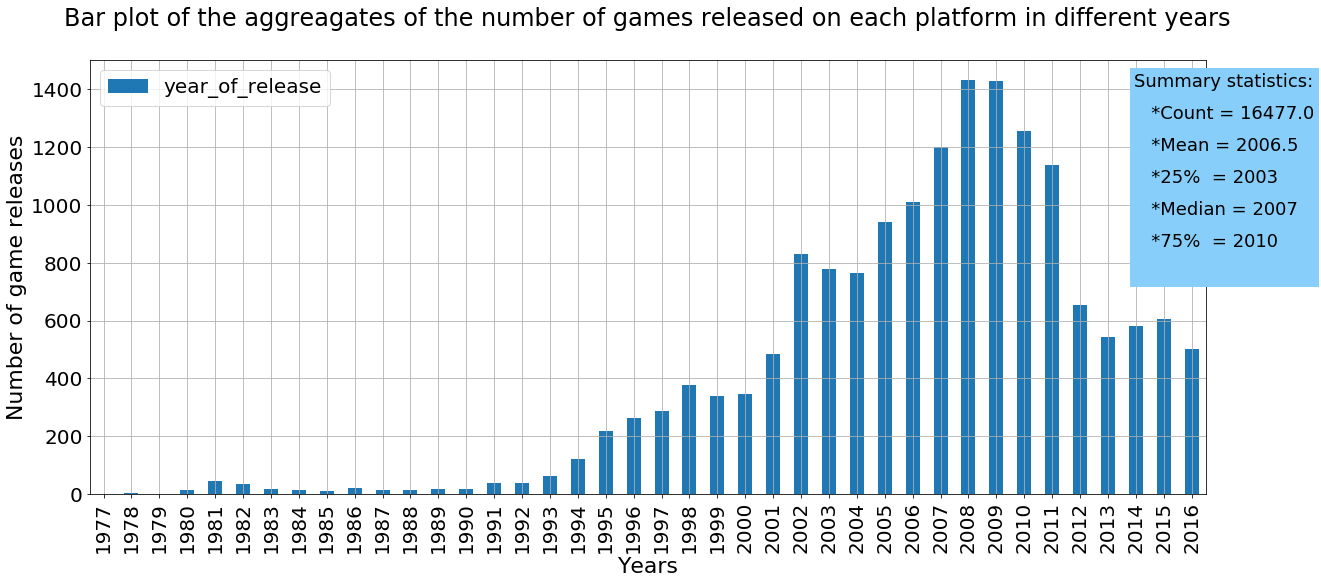

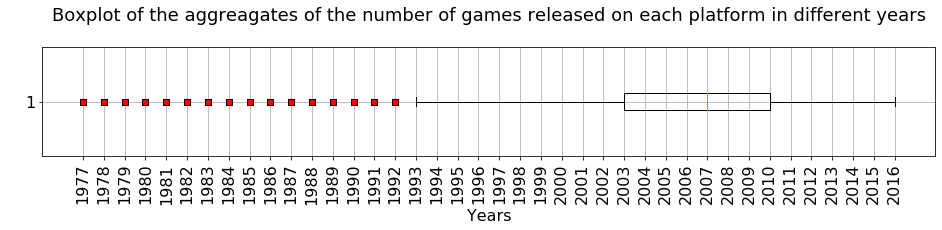

<span style='color:blue'>games dataframe typical 'year_of_release' range by IQR rule:</span>

[1993, 2020]


In [44]:
# Plot bar and box plots for the total number of games released in different years

plt.figure(figsize=(20, 8))

df_games['year_of_release'].value_counts().sort_index().plot(kind='bar')

plt.title("Bar plot of the aggreagates of the number of games released on each platform in different years\n", 
          fontsize = 24)
plt.grid()
plt.xlabel('Years', fontsize=22)
plt.ylabel('Number of game releases', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

stats_YoR = df_games['year_of_release'].describe()
plt.figtext(0.85, 0.5, 
   "Summary statistics:\n   *Count = {}\n   *Mean = {}\n   *25%  = {}\n"
   "   *Median = {}\n   *75%  = {}\n"
                     .format(stats_YoR['count'], stats_YoR['mean'].round(1), int(stats_YoR['25%']), 
                             int(stats_YoR['50%']), int(stats_YoR['75%'])),
                      linespacing = 2, fontsize=18, backgroundcolor='lightskyblue')


plt.show()

red_square = dict(markerfacecolor='r', marker='s')

plt.figure(figsize=(16, 2))
plt.boxplot(df_games['year_of_release'], vert=False, flierprops=red_square)
plt.grid()
plt.suptitle(' ')
plt.title('Boxplot of the aggreagates of the number of games released on each platform in different years\n',
          fontsize=18)
plt.ylabel(" ", fontsize=14)
plt.xlabel('Years', fontsize=16)
plt.xticks(range(1977, 2017), fontsize=16, rotation=90)
plt.yticks(fontsize=16)


plt.show()

# Get outliers from IQR rule
Q1 = stats_YoR['25%']  # Get first quartile
Q3 = stats_YoR['75%']  # Get third quartile
IQR = Q3 - Q1  # Interquartile range
LB_outliers = (Q1 - 1.5*IQR)   # Compute lower whisker 
UB_outliers = (Q3 + 1.5*IQR) 
printmd("{} dataframe typical 'year_of_release' range by IQR rule:".format(df_games.name), 'blue')
print('[{}, {}]'.format(int(np.ceil(LB_outliers)), int(np.floor(UB_outliers))))
# display(df_games['year_of_release'])


We found out that the data prior to $1993$ can be considered as outliers. In other words, the number of games released on the platforms prior to this year is negligible compared to subsequent years. This analysis is not, however, sufficient to decide to keep the data from $1993$ onwards. In fact, some of the platforms within the typical range of the 'year_of_release' column might have been discontinued. So, let us identify the typical lifetimes of the game platforms.

<span style='color:blue'>games dataframe platform lifetime stats</span>

count    31.000000
mean      7.064516
std       5.988519
min       0.000000
25%       3.000000
50%       6.000000
75%      10.000000
max      31.000000
Name: observed_lifetime, dtype: float64

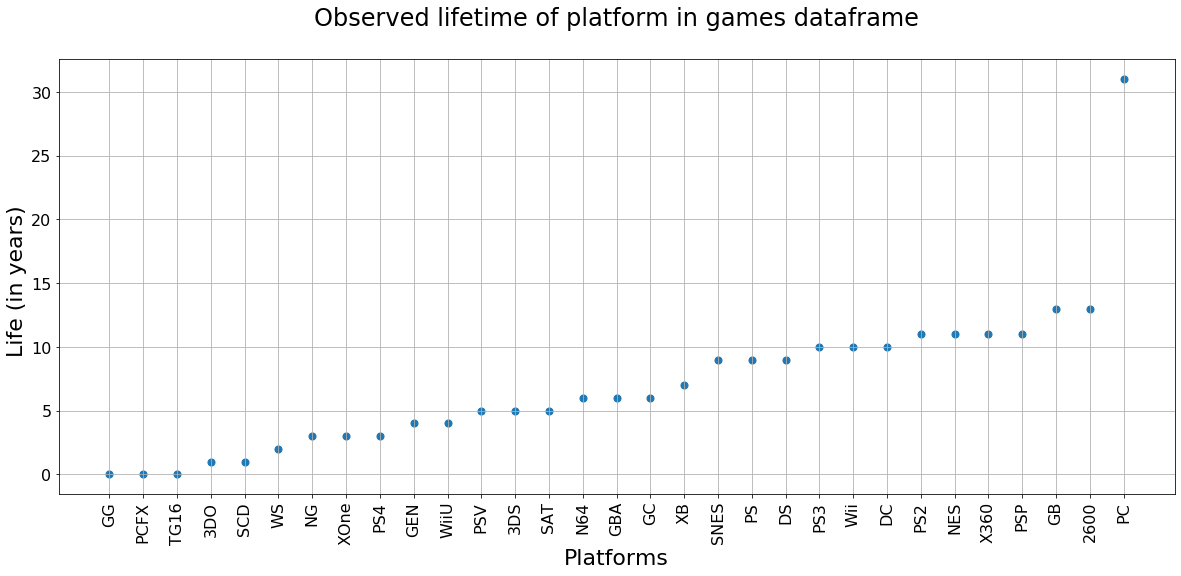

In [45]:
# Estimate the lifespan of the platforms from observed data. 
# Display summary statistics and plot of lifetime data by platforms

platform_lifetime = (df_games.groupby('platform')['year_of_release'].agg(['min', 'max']))
platform_lifetime['observed_lifetime'] = platform_lifetime['max']-platform_lifetime['min']
platform_lifetime = platform_lifetime.sort_values(by='observed_lifetime')
platform_lifetime = platform_lifetime.reset_index()

printmd('{} dataframe platform lifetime stats'.format(df_games.name), 'blue')
display(platform_lifetime['observed_lifetime'].describe())

plt.figure(figsize=(20,8))
plt.scatter(platform_lifetime['platform'], platform_lifetime['observed_lifetime'], s=50)

plt.title('Observed lifetime of platform in games dataframe\n',
          fontsize=24)
plt.ylabel("Life (in years) ", fontsize=22)
plt.xlabel('Platforms', fontsize=22)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.grid()
plt.show()


We found that the mean and median observed lifetimes of the platforms are $7.4$ and $6$ years, respectively. We can also see that there are outliers whose lifetime is either very very short lie GG, PCFX, or TG16, or very long like 'PC'. It thus makes sense to use the median value of $6$ years as the typical lifespan of the platforms. So, if we were in $2016$, it would be reasonable to include data of the $6$ previous years in building our prognosis for $2017$. 

Let us also look at how long it generally takes for new platforms to appear.

count    31.00000
mean      1.16129
std       1.46280
min       0.00000
25%       0.00000
50%       1.00000
75%       1.50000
max       6.00000
Name: new_in_years, dtype: float64

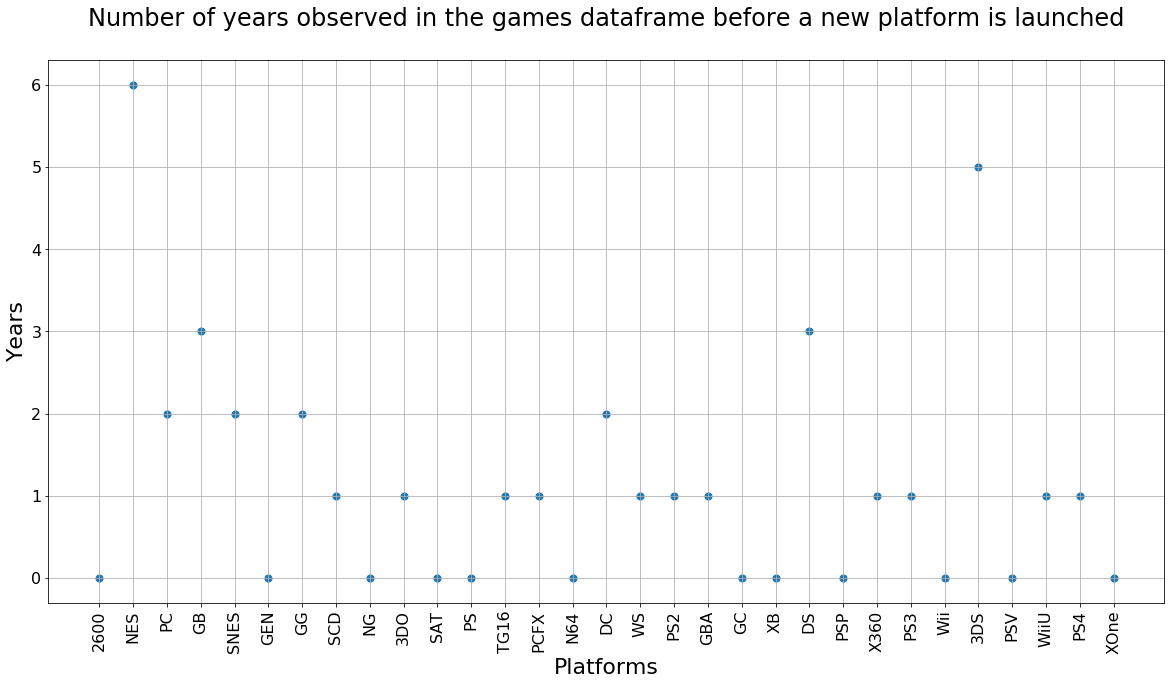

In [46]:
# Estimate how long it take for a platform to appear after the one before from observed data
platform_lifetime = platform_lifetime.sort_values(by='min')
platform_lifetime['new_in_years'] = platform_lifetime['min'].diff()
platform_lifetime['new_in_years'] = platform_lifetime['new_in_years'].fillna(0)
display(platform_lifetime['new_in_years'].describe())
plt.figure(figsize=(20,10))
plt.scatter(platform_lifetime['platform'], platform_lifetime['new_in_years'], s=50)
plt.title('Number of years observed in the games dataframe before a new platform is launched\n',
          fontsize=24)
plt.ylabel("Years", fontsize=22)
plt.xlabel('Platforms', fontsize=22)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.grid()
plt.show()


Here, each point tells us how many years passed before the launch of the platform from the one previous platform. According to both the mean and median values, it seems that a new platform is launched generally once a year.

Before we discard data prior to $2010$, we suggest to identify the discontinued, growing or shrinking platforms using all the years as follows. We first build a pivot table aggregating the total sales in each platform in different release years. 

In [47]:
# Building a pivot table to aggregate total sales in each platform by release years
pivot_sales_YoR = pd.pivot_table(index=['year_of_release'], columns=['platform'], values=['total_sales'],
                             aggfunc='sum', data=df_games)
pivot_sales_YoR.columns = pivot_sales_YoR.columns.droplevel()

pivot_sales_YoR = pivot_sales_YoR.rename_axis(None, axis=1)


pivot_sales_YoR = pivot_sales_YoR.fillna(0)

pd.set_option('display.max_columns', 50)

display(pivot_sales_YoR)


,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,N64,NES,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1977,2.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1978,1.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1979,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1980,16.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1981,35.68,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1982,29.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1983,5.84,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.96,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1984,0.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1985,0.45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,53.44,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Next we normalize the entries of the above pivot table so as to store the average profit per year. We assume that a game released in a certain year has generated until $2017$ every year an equal amount adding up to the total.

In [48]:
# Define a function to normalise the row of the pivot table
def profit_per_year(row):
    row = row/(2017-row.name)
    return row

# Apply the function to the rows of the pivot table
pivot_sales_YoR = pivot_sales_YoR.apply(profit_per_year, axis=1)
display(pivot_sales_YoR)


,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,N64,NES,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1977,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1978,0.036923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1979,0.008158,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1980,0.458108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1981,0.991111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1982,0.838571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1983,0.171765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.322353,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1984,0.008182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,1.517576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1985,0.014062,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,1.670000,0.000000,0.001250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Finally, we compute the cumulative sums of the sales for each platform.

In [49]:
# Compute cumulative sums of the columns of the pivot table
pivot_sales_YoR_cumsum = pivot_sales_YoR.cumsum()

pivot_sales_YoR_cumsum = pivot_sales_YoR_cumsum.sort_values(pivot_sales_YoR_cumsum.last_valid_index(), axis=1,
                                                           ascending=False)
display(pivot_sales_YoR_cumsum)


,PS4,PS3,X360,Wii,PS2,DS,XOne,3DS,PC,PS,PSP,WiiU,GBA,XB,PSV,GC,GB,N64,SNES,NES,2600,SAT,GEN,DC,WS,SCD,NG,TG16,3DO,GG,PCFX
year_of_release,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1977,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
1978,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.099423,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
1979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.107581,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
1980,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.565689,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
1981,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.556800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
1982,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.395372,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
1983,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.322353,2.567136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
1984,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.839929,2.575318,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
1985,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.509929,2.589381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000


Let us plot the cumulative sums of the first $15$ most profitable platforms in $2016$ as per their average yearly profits up to the same year.

<Figure size 432x288 with 0 Axes>

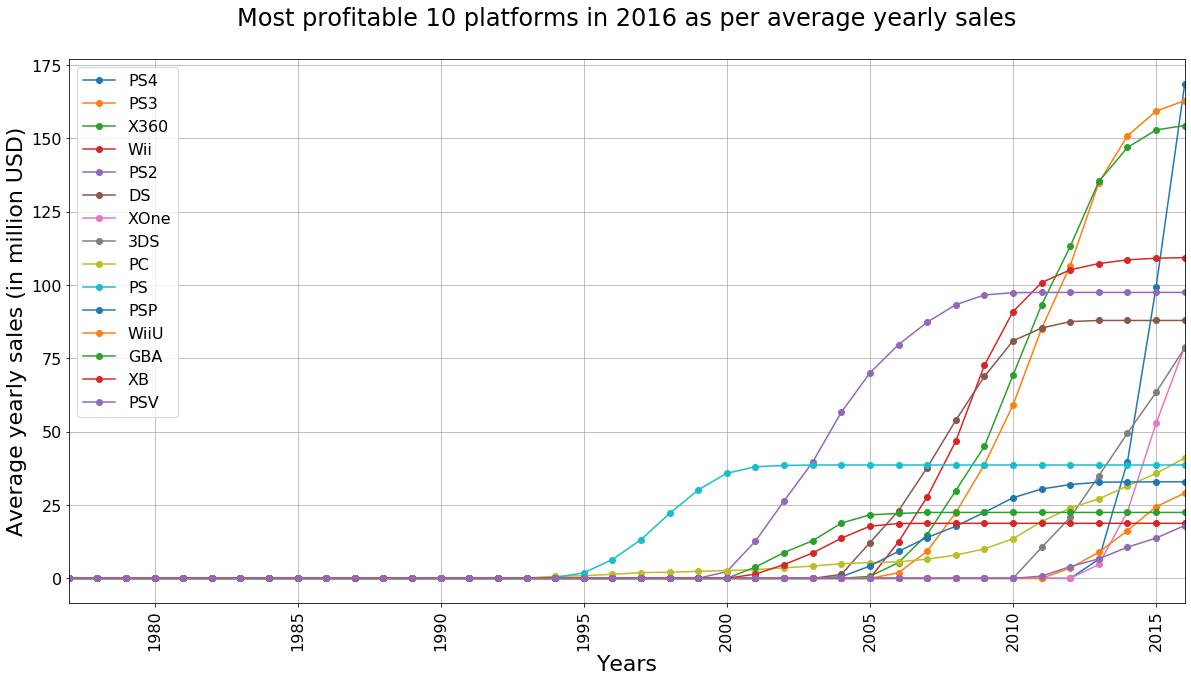

In [50]:
# Plot the most profitable 15 platforms by 2016 according to studied measure
plt.figure()
j=0
# Most profitable platforms
pivot_sales_YoR_cumsum.reset_index().plot(x='year_of_release',
                            y = ['PS4', 'PS3', 'X360', 'Wii', 'PS2', 'DS', 'XOne', '3DS', 'PC', 'PS',
                                'PSP', 'WiiU', 'GBA', 'XB', 'PSV'],
                            kind='line',
                            style='-o',
                            figsize = (20, 10))

plt.title('Most profitable 10 platforms in 2016 as per average yearly sales\n',
          fontsize=24)
plt.ylabel("Average yearly sales (in million USD)", fontsize=22)
plt.xlabel('Years', fontsize=22)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()


Let us also plot the distributions of the $15$ most profitable platforms in $2016$ as per their average yearly profits up to the same year.

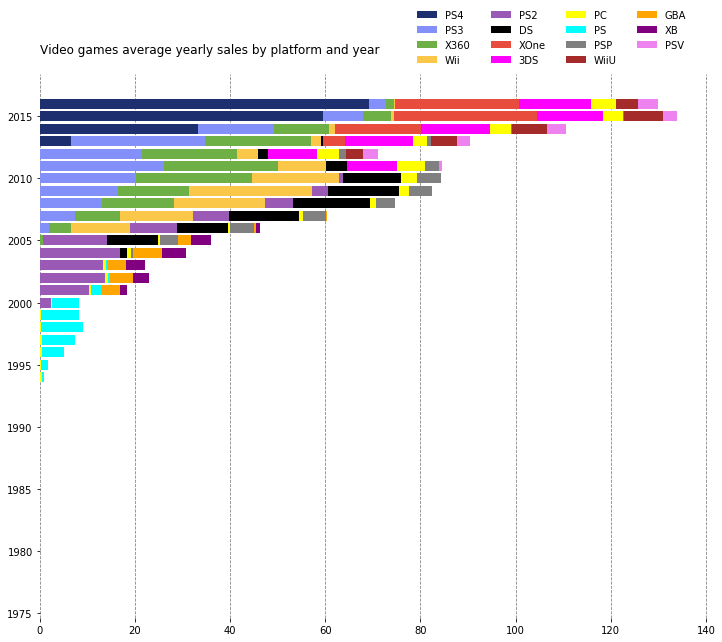

In [51]:
# Plot stacked bar charts for the most profitable 15 platforms by 2016 according to studied measure

pivot_sales_YoR_ppy = pivot_sales_YoR.sum().sort_values(ascending=False).to_frame()
pivot_sales_YoR_ppy.columns = ['average_sales_per_year in 2016']

fields = ['PS4', 'PS3', 'X360', 'Wii', 'PS2', 'DS', 'XOne', '3DS', 'PC', 'PS',
                                'PSP', 'WiiU', 'GBA', 'XB', 'PSV']
colors =  ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', "#9b59b6", "black",
           '#e74c3c', 'magenta', 'yellow', 'cyan', 'grey', 'brown', 'orange', 'purple', 'violet']

labels = ['PS4', 'PS3', 'X360', 'Wii', 'PS2', 'DS', 'XOne', '3DS', 'PC', 'PS',
                                'PSP', 'WiiU', 'GBA', 'XB', 'PSV']
#9b59b6", "#e74c3c", 
# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))
# plot bars
left = len(pivot_sales_YoR) * [0]
for idx, name in enumerate(fields):
    y = list(pivot_sales_YoR.index)
    widths =  np.array(pivot_sales_YoR[name])
    plt.barh(y, widths, left = left, color=colors[idx])
    left = left + widths
    
    
# title, legend, labels
plt.title('Video games average yearly sales by platform and year\n', loc='left')
plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()


Now, we generate a series of plots that will help us identify discontinued, growing, or shrinking platforms in $2016$. Let us start with the ancient platforms that clearly are out of date.

<Figure size 432x288 with 0 Axes>

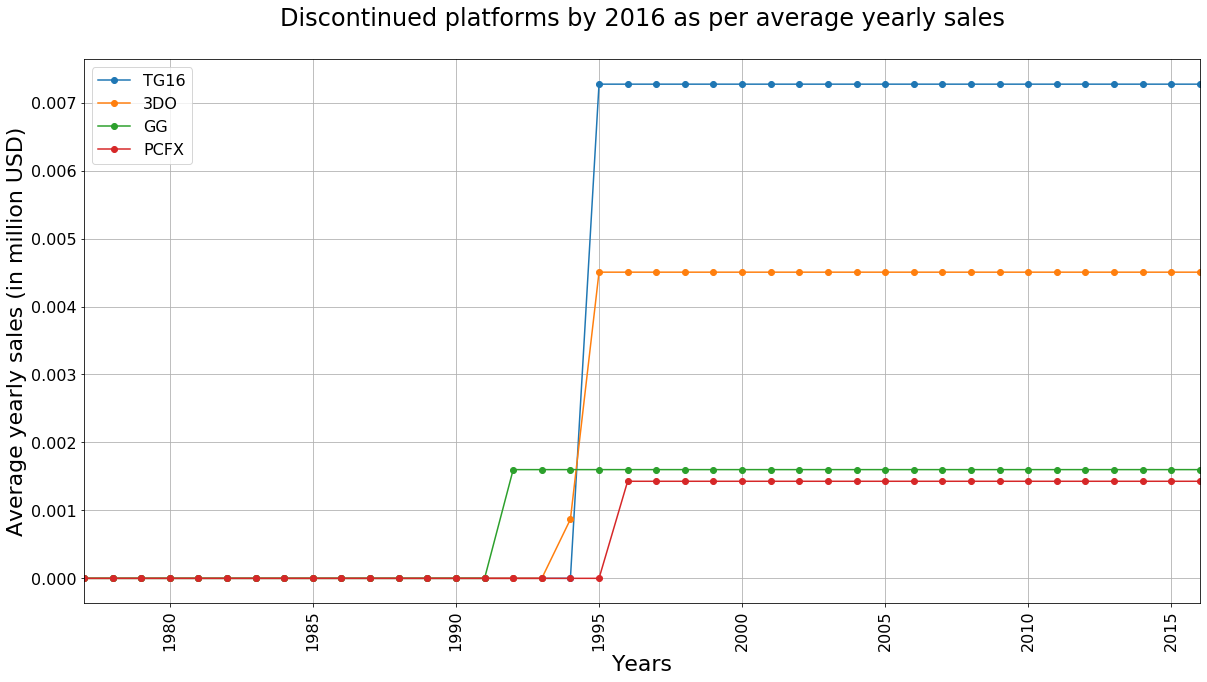

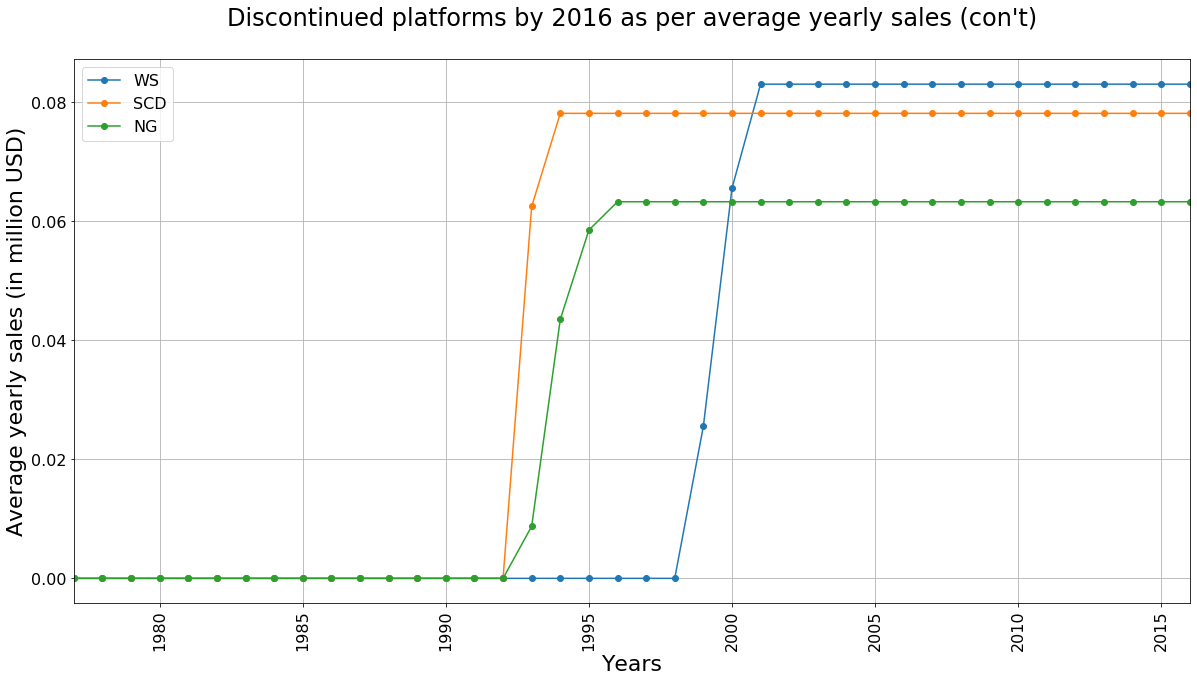

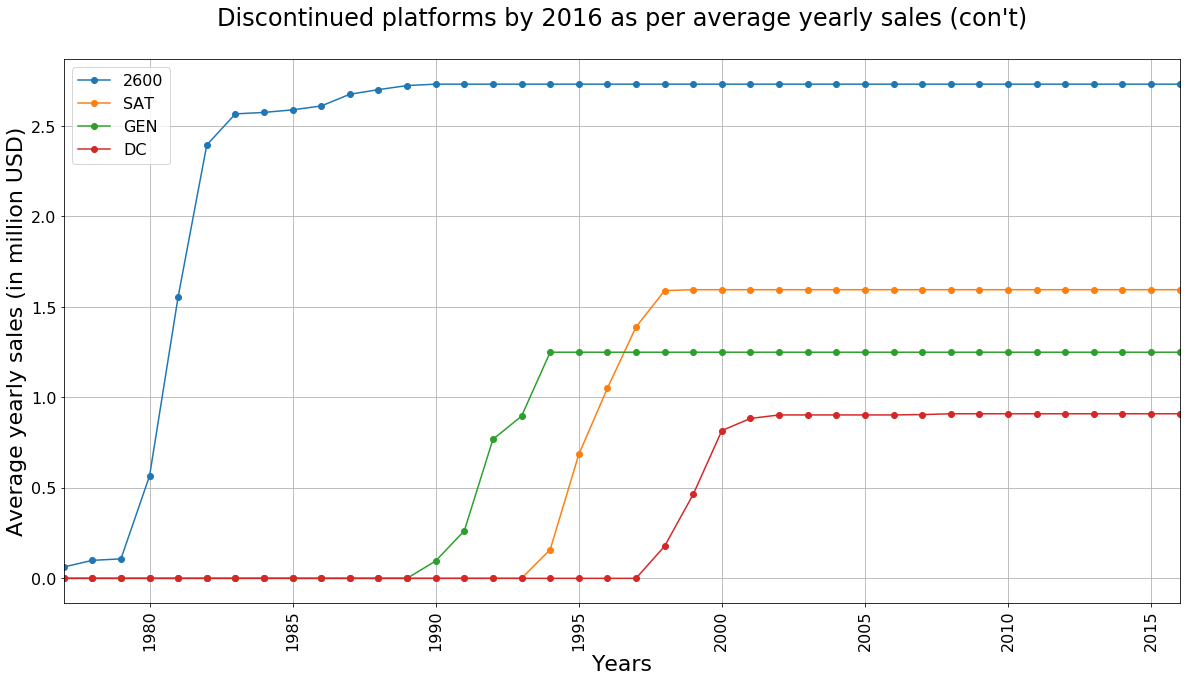

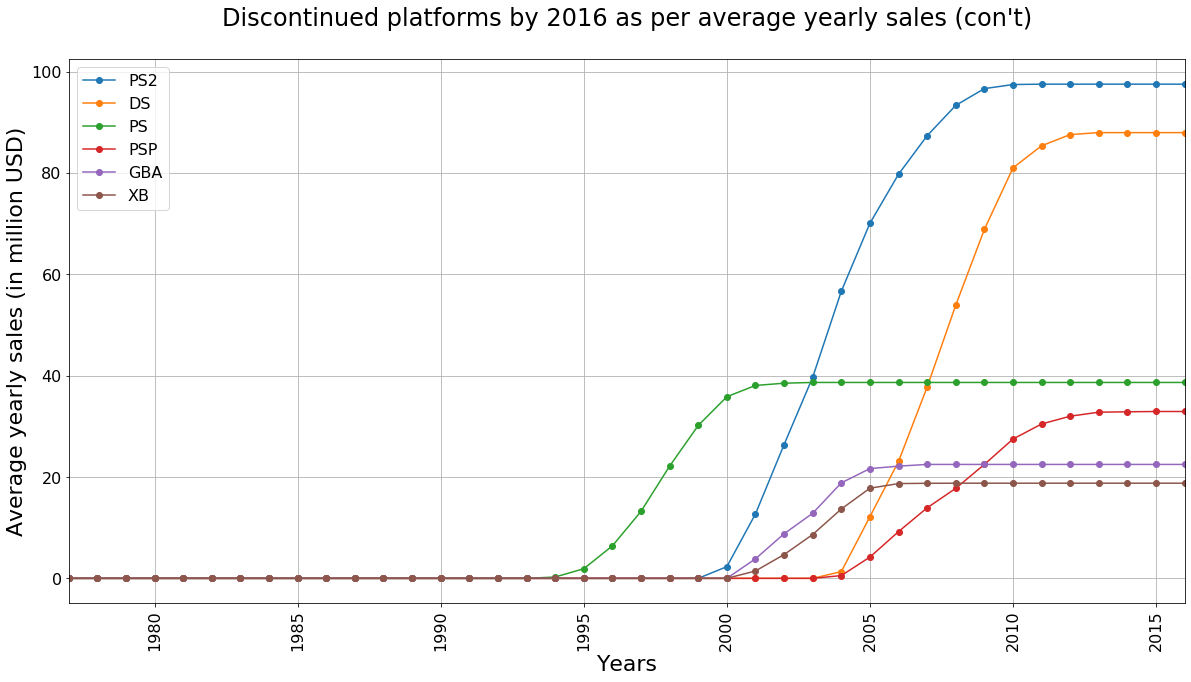

In [52]:
# Plot 'discontinued' platforms by 2016 according to studied measure

plt.figure()
j=0

pivot_sales_YoR_cumsum.reset_index().plot(x='year_of_release',
                            y = ['TG16', '3DO', 'GG','PCFX'],
                            kind='line',
                            style='-o',
                            figsize = (20, 10))
plt.title('Discontinued platforms by 2016 as per average yearly sales\n',
          fontsize=24)
plt.ylabel("Average yearly sales (in million USD)", fontsize=22)
plt.xlabel('Years', fontsize=22)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()
print()

pivot_sales_YoR_cumsum.reset_index().plot(x='year_of_release',
                            y = [ 'WS', 'SCD', 'NG'],
                            kind='line',
                            style='-o',
                            figsize = (20, 10))
plt.title("Discontinued platforms by 2016 as per average yearly sales (con't)\n",
          fontsize=24)
plt.ylabel("Average yearly sales (in million USD)", fontsize=22)
plt.xlabel('Years', fontsize=22)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()
print()

pivot_sales_YoR_cumsum.reset_index().plot(x='year_of_release',
                            y = ['2600', 'SAT', 'GEN', 'DC'],
                            kind='line',
                            style='-o',
                            figsize = (20, 10))
plt.title("Discontinued platforms by 2016 as per average yearly sales (con't)\n",
          fontsize=24)
plt.ylabel("Average yearly sales (in million USD)", fontsize=22)
plt.xlabel('Years', fontsize=22)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()
print()

pivot_sales_YoR_cumsum.reset_index().plot(x='year_of_release',
                            y = ['PS2', 'DS', 'PS', 'PSP', 'GBA', 'XB'],
                            kind='line',
                            style='-o',
                            figsize = (20, 10))
plt.title("Discontinued platforms by 2016 as per average yearly sales (con't)\n",
          fontsize=24)
plt.ylabel("Average yearly sales (in million USD)", fontsize=22)
plt.xlabel('Years', fontsize=22)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()


Next we continue with the plots for currently shrinking platforms.

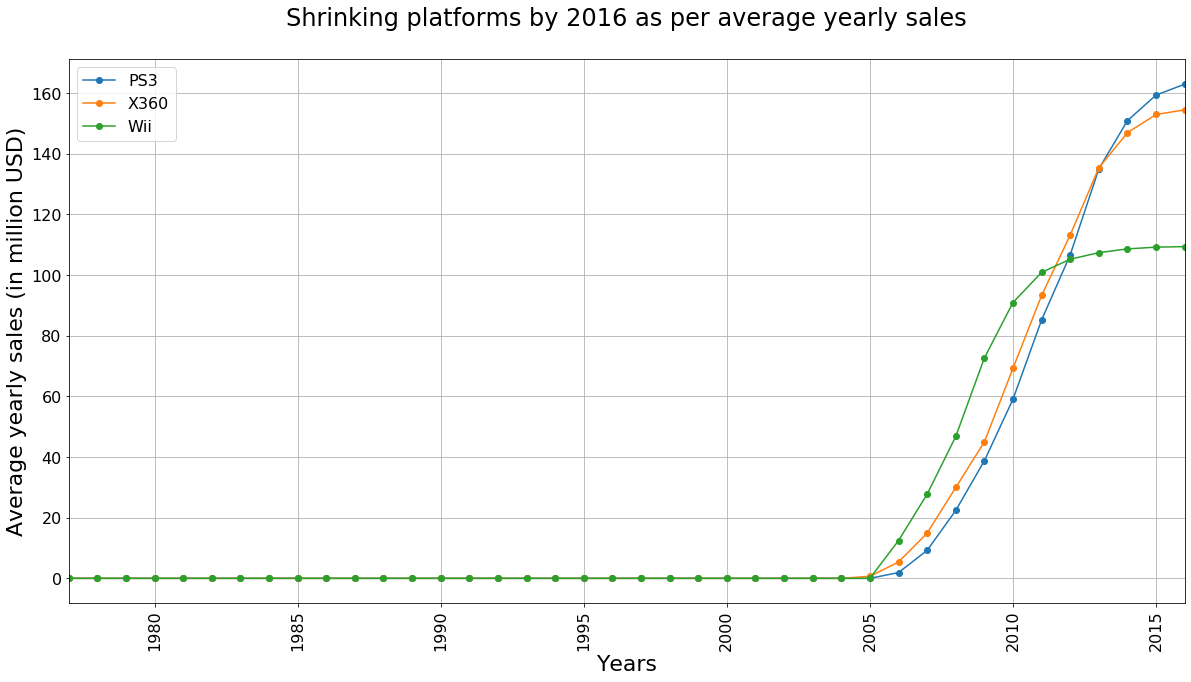

In [53]:
# Plot 'shrinking' platforms by 2016 according to studied measure

pivot_sales_YoR_cumsum.reset_index().plot(x='year_of_release',
                            y = ['PS3', 'X360', 'Wii'],
                            kind='line',
                            style='-o',
                            figsize = (20, 10))
plt.title("Shrinking platforms by 2016 as per average yearly sales\n",
          fontsize=24)
plt.ylabel("Average yearly sales (in million USD)", fontsize=22)
plt.xlabel('Years', fontsize=22)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()


Now, it is time for the plot for currently growing platforms.

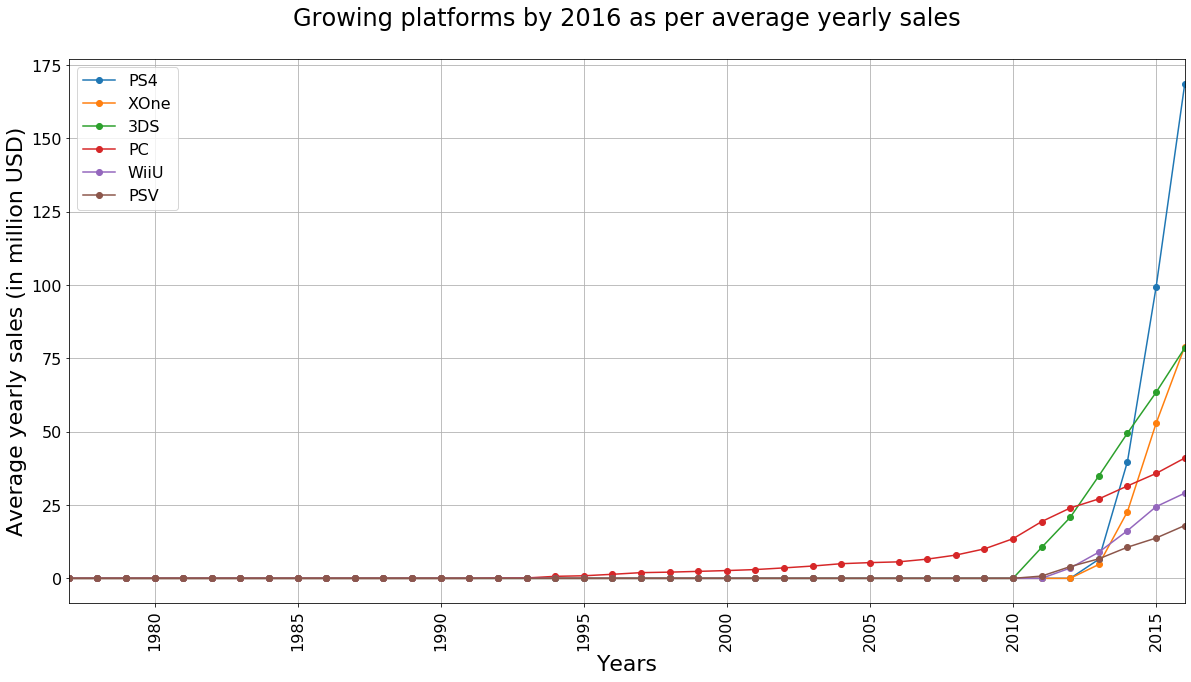

In [54]:
# Plot 'growing' platforms by 2016 according to studied measure
pivot_sales_YoR_cumsum.reset_index().plot(x='year_of_release',
                            y = ['PS4', 'XOne', '3DS', 'PC', 'WiiU', 'PSV'],
                            kind='line',
                            style='-o',
                            figsize = (20, 10))
plt.title("Growing platforms by 2016 as per average yearly sales\n",
          fontsize=24)
plt.ylabel("Average yearly sales (in million USD)", fontsize=22)
plt.xlabel('Years', fontsize=22)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()


Let us summarize our findings from the previous series of plots:
- The are $6$ platforms still growing in $2016$. Ordered from highest to lowest growth rates of the average yearly sales, these are PS4, XOne, 3DS, PC, WiiU, PSV. The growth rates of PS4, XOne, and 3DS considerably faster than the rest. On the other hand, the lifespan of the PC platform shows that it will be profitable for many more years, making it quite safe to invest.
- There are $3$ platforms still growing in $2016$, but whose rate of growth has significantly slowed downed. Ordered from highest to lowest growth rates, these are PS3, X360, and Wii. 
- On the other hand, among these growing and shrinking platforms, the average yearly sales in $2016$ are ordered from biggest to smallest as follows: PS4, PS3, X360, Wii, XOne, 3DS, PC, WiiU, PSV. Moreover, the numbers are above $100$ millions USD for PS4, PS3, and X360 and between $18$ to $80$ millions USD for the rest. 
- For the remaining platforms, we can clearly observe that their growth has stopped. 

Now, we saw that the average platform' lifespan is $6$ years. So, we should certainly discard games released prior to $2010$. However, before deciding the actual period to keep for our $2017$ prognosis, let us also study for how long released games are relevant. If we choose a longer period, we risk capturing a lagging trend in our prediction. So, we sutdy the 'total_sales' by platforms.

In [55]:
# Display total sales by platform
sales_grouped_platform = (df_games.groupby('platform')['total_sales'].agg('sum').to_frame()
                 .sort_values(by='total_sales', ascending=False))

display(sales_grouped_platform)


,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.10
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


We know plot in a stacked bar chart the distributions of the total sales by release years for the 12 platforms with highest overall total sales. 

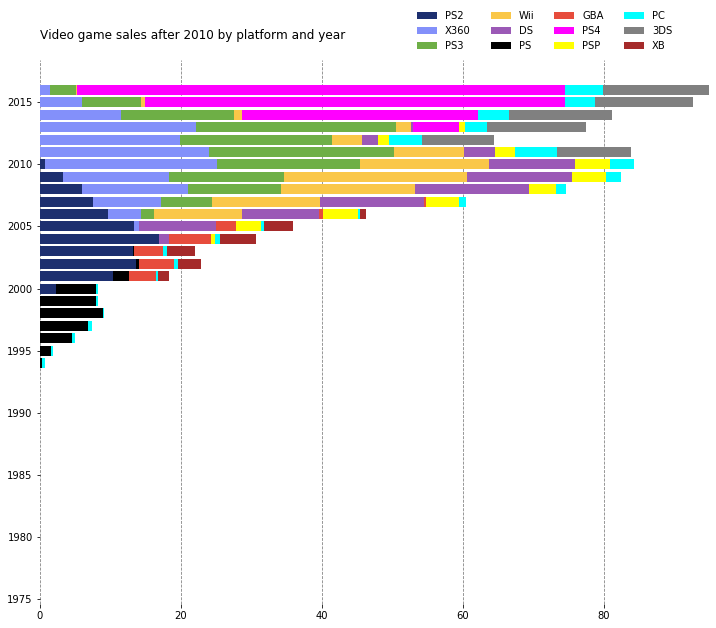

In [56]:
# Plot stacked bar charts for the distribution of total sales in 12 platforms with discarded data
fields = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PS4', 'PSP', 'PC', '3DS',
       'XB']
colors =  ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', "#9b59b6", "black",
           '#e74c3c', 'magenta', 'yellow', 'cyan', 'grey', 'brown']
labels = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PS4', 'PSP', 'PC', '3DS',
       'XB']
#9b59b6", "#e74c3c", 
# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))
# plot bars
left = len(pivot_sales_YoR) * [0]
for idx, name in enumerate(fields):
    y = list(pivot_sales_YoR.index)
    widths =  np.array(pivot_sales_YoR[name])
    plt.barh(y, widths, left = left, color=colors[idx])
    left = left + widths
    
  
    
# title, legend, labels
plt.title('Video game sales after 2010 by platform and year\n', loc='left')
plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()


By analyzing the above stacked bar chart, we see that we can avoid capturing lagging trends by limiting our analysis to the period $2014$-$2016$. Therefore, we now discard games released prior to $2014$. 

In [57]:
# Discard games data for games released prior to 2010
df_games_2014 = df_games.loc[df_games['year_of_release'] >= 2014].copy()


From this point onward, we will continue working with the data for the period $2010$-$2016$, unless we specify otherwise. We next build a box plot for the global sales of all games, broken down by platform. 

<Figure size 432x288 with 0 Axes>

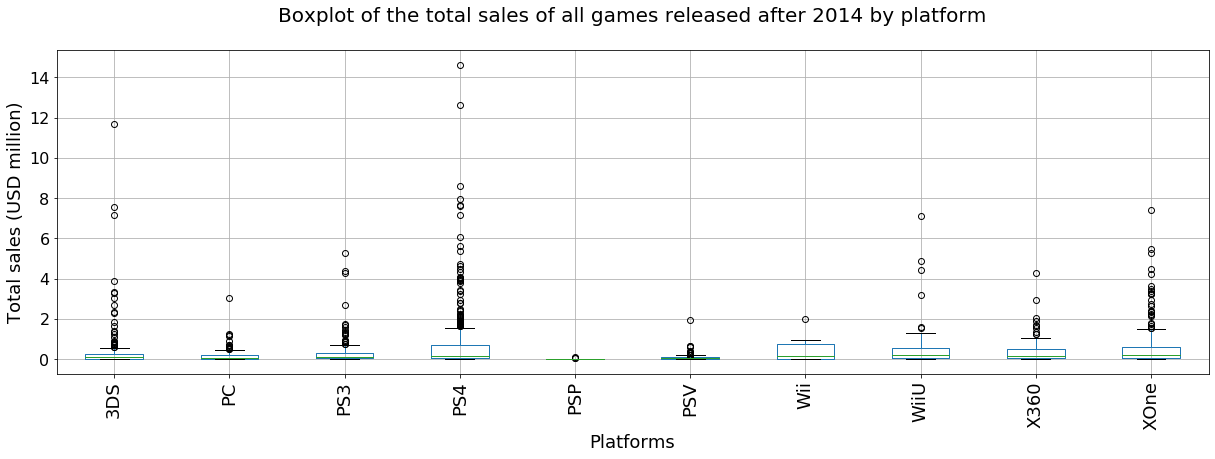

In [58]:
# Plot a boxplot for the total sales by platform
plt.figure()
df_games_2014.boxplot(column='total_sales', by=['platform'], figsize=(20,6), grid=True, fontsize=16, rot=90)
plt.suptitle('')
plt.ylabel("Total sales (USD million)", rotation=90, fontsize=18)
plt.title('Boxplot of the total sales of all games released after 2014 by platform\n', fontsize=20)
plt.xlabel('Platforms', fontsize=18)
plt.xticks(fontsize=18)
plt.show()


We see that our data now includes $10$ platforms. Let us note that we observe outliers in each platform, though the outliers for PSP, PSV, Wii are closer to the upper wiskers. For platforms like PS4, 3DS, and XOne, outliers' total sales seems quite significant. Even if some of these outliers were caused by erroneous data, there are still to many to be called all erroneous. Therefore, we conclude that there are big variations in game sales within the platforms themselves. Targetting such outliers would certainly be more profitable.  

Due to the high numbers of large outliers reading the boxplots is quite difficult. So, let us zoom in by limiting the y-axis. 

<Figure size 432x288 with 0 Axes>

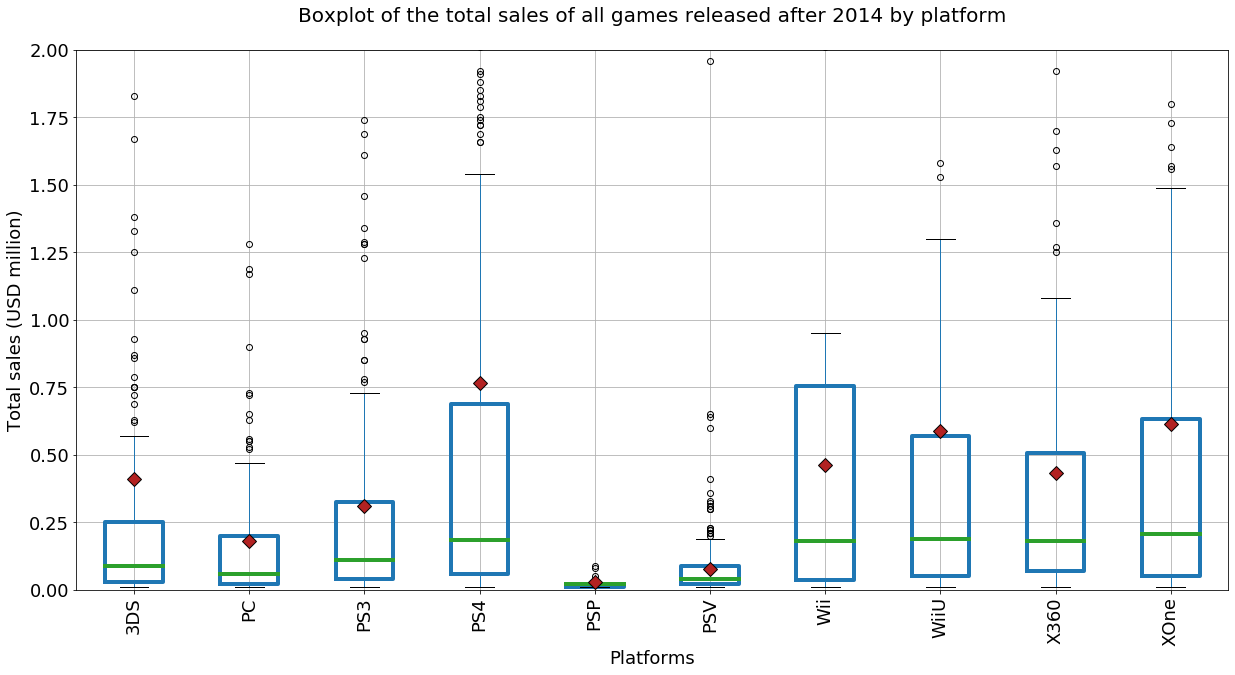

In [59]:
# Replot the boxplot for the total sales by platform limiting y-axis

plt.figure()

boxprops = dict(linestyle='-', linewidth=4)
medianprops = dict(linestyle='-', linewidth=4)

meanprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick', markersize=10)
df_games_2014.boxplot(column='total_sales', by=['platform'], figsize=(20,10), 
                 grid=True, fontsize=16, rot=90, showmeans=True,
                 boxprops=boxprops, medianprops=medianprops, meanprops=meanprops,
                 return_type='dict')
plt.ylim(0, 2)
plt.suptitle('')
plt.ylabel("Total sales (USD million)", rotation=90, fontsize=18)
plt.title('Boxplot of the total sales of all games released after 2014 by platform\n', fontsize=20)
plt.xlabel('Platforms', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


Focusing on the interquartile ranges, we can see that the platforms can be grouped according to their sales performances as follows:
- DC, PC, PS2, PSP, and PSV platforms display relatively close medians, interquartile ranges and mean values. Nevertheless, we should keep in mind that the plot is in million USD, so small variations are in the order of hundred thousands. Typically, the games sold in these platforms do not generate more than $0.5$ million USD (limited by the upper whiskers). 
- 3DS, Wii, WiiU platforms can be considered as a second group, where the typical games do not generate more than $1.25$ millions USD. 
- The final group is made of PS3, PS4, X360, XOne platforms. Although their median is not much bigger than the medians of the second group of platforms, their interquartile ranges extend considerably up. Typical games can generate up to $1.75$ millions USD. Also these platforms display the largest discrepencies between the mean and median values of the total sales. 

To recap, so far we identified potentially profitable platforms for $2017$, but we also saw that there could be huge variations on the total sales of the games in a given platform. Therefore, we should explore the factors that could be contributing to the succcess of games.

In the scope of this project, we take a look at how user and professional reviews affect sales for one popular platform we choose. To decide which platform to choose let us find the platform(s) having most critic and user scores in our games dataframe. Here we will first use the complete preprocessed dataframe instead of limiting us to games released after $2014$.

In [60]:
# Identify counts of non-null data in 'critic_score' and 'user_score' columns by platform
print(df_games.groupby(by='platform')['critic_score'].agg('count').sort_values(ascending=False))
print(df_games.groupby(by='platform')['user_score'].agg('count').sort_values(ascending=False))


platform
PS2     1298
X360     916
PS3      820
XB       725
DS       717
PC       715
Wii      585
PSP      462
GC       448
GBA      438
PS4      252
PS       200
XOne     169
3DS      168
PSV      120
WiiU      90
DC        14
SAT        0
3DO        0
GB         0
WS         0
TG16       0
GEN        0
GG         0
N64        0
NES        0
NG         0
SNES       0
PCFX       0
SCD        0
2600       0
Name: critic_score, dtype: int64
platform
PS2     1241
X360     966
PS3      877
PC       770
XB       586
Wii      560
DS       516
PSP      421
GC       366
PS4      257
GBA      255
XOne     182
3DS      174
PS       162
PSV      143
WiiU     100
DC        14
SNES       0
3DO        0
WS         0
GB         0
TG16       0
GEN        0
SAT        0
GG         0
N64        0
NES        0
NG         0
SCD        0
PCFX       0
2600       0
Name: user_score, dtype: int64


We found that the PS2 platform has more games for which both scores are available in our games dataframe. Recall that in Step 2, we had identified that the percentage of missing data in these columns were relatively smaller for the first decade of the millenium. This period includes the majority of the lifespan of the PS2 platform (2000-2013). We will filter out the PS2 games with missing score data from the analysis. Nevertheless, we will still have about $1500$ games to study.  

We want to know if higher scores are linearly translated to larger sales, and vice versa. To check this, we build a scatter plot and calculate the correlation between reviews and sales.

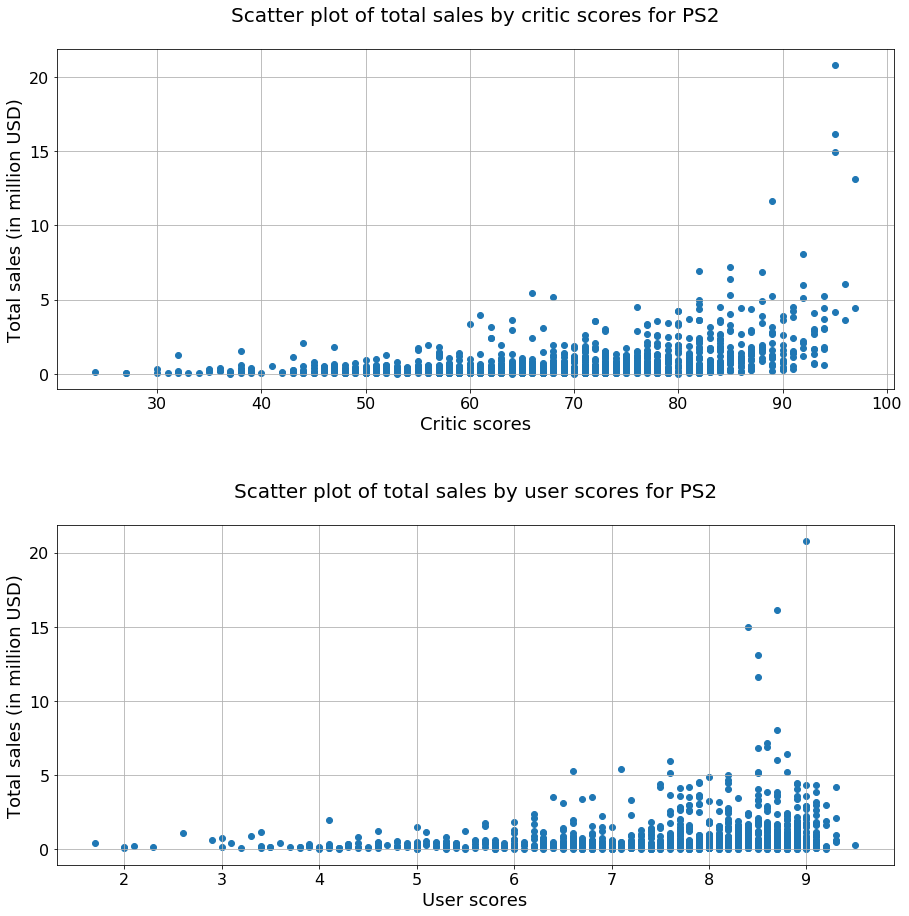

Correlation coefficient between total sales and critic scores for PS2: 0.39543454945454876
Correlation coefficient between total sales and user scores for PS2: 0.17286551112058213


In [61]:
# Create scatterplot and compute correlation between revies and sales for one platform
platform = 'PS2'
df_PS2 = df_games.loc[df_games['platform'].isin([platform])].copy()

df_sales_cscores = df_PS2.loc[~df_PS2['critic_score'].isnull()].copy()

fig, axes = plt.subplots(2, 1, figsize=(15,15))
axes[0].scatter(y= 'total_sales', x='critic_score',data=df_sales_cscores)
axes[0].grid()
axes[0].set_title('Scatter plot of total sales by critic scores for PS2\n', fontsize=20)

axes[0].set_xlabel('Critic scores', fontsize=18)
axes[0].set_ylabel('Total sales (in million USD)', fontsize=18)

axes[0].tick_params(axis='x', labelsize=16)
axes[0].tick_params(axis='y', labelsize=16)

df_sales_uscores = df_PS2.loc[~df_PS2['user_score'].isnull()].copy()

axes[1].scatter(y= 'total_sales', x='user_score',data=df_sales_uscores)
axes[1].grid()
axes[1].set_title('Scatter plot of total sales by user scores for PS2\n', fontsize=20)

axes[1].set_xlabel('User scores', fontsize=18)
axes[1].set_ylabel('Total sales (in million USD)', fontsize=18)

axes[1].tick_params(axis='x', labelsize=16)
axes[1].tick_params(axis='y', labelsize=16)


# Adjust spacing between the subplots
plt.subplots_adjust(hspace = 0.4)
plt.show()

print('Correlation coefficient between total sales and critic scores for PS2:', 
      df_PS2['critic_score'].corr(df_PS2['total_sales']))
print('Correlation coefficient between total sales and user scores for PS2:', 
      df_PS2['user_score'].corr(df_PS2['total_sales']))


We found out that both critic and user scores are positively correlated with total sales. However, while the strenght of the association is only medium for the critic scores, it is pretty weak for the user scores. 

Now, we repeat the correlation analysis for the PS4 platform, as PS2 is an outdated platform. Let us see if similar conlcusions are valid. 

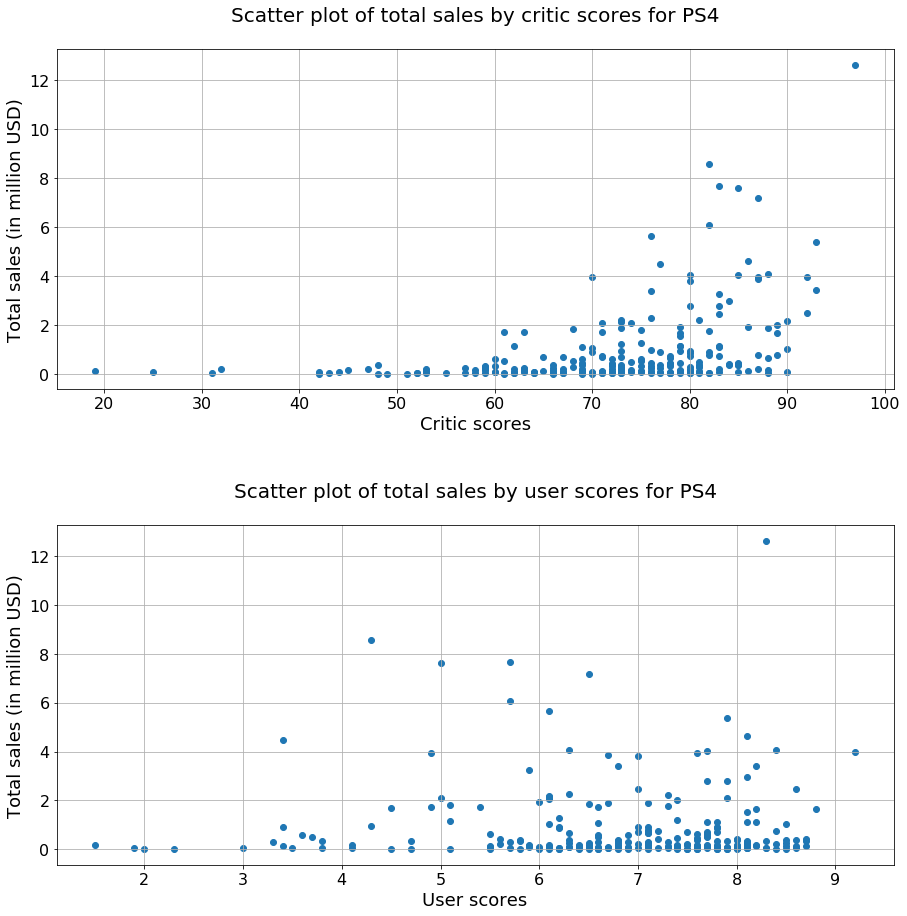

Correlation coefficient between total sales and critic scores for PS4: 0.40266141068104083
Correlation coefficient between total sales and user scores for PS4: -0.040131589472697356


In [62]:
# Create scatterplot and compute correlation between revies and sales for one platform
platform = 'PS4'
df_PS4 = df_games_2014.loc[df_games_2014['platform'].isin([platform])].copy()

df_sales_cscores = df_PS4.loc[~df_PS4['critic_score'].isnull()].copy()

fig, axes = plt.subplots(2, 1, figsize=(15,15))
axes[0].scatter(y= 'total_sales', x='critic_score',data=df_sales_cscores)
axes[0].grid()
axes[0].set_title('Scatter plot of total sales by critic scores for PS4\n', fontsize=20)

axes[0].set_xlabel('Critic scores', fontsize=18)
axes[0].set_ylabel('Total sales (in million USD)', fontsize=18)

axes[0].tick_params(axis='x', labelsize=16)
axes[0].tick_params(axis='y', labelsize=16)

df_sales_uscores = df_PS4.loc[~df_PS4['user_score'].isnull()].copy()

axes[1].scatter(y= 'total_sales', x='user_score',data=df_sales_uscores)
axes[1].grid()
axes[1].set_title('Scatter plot of total sales by user scores for PS4\n', fontsize=20)

axes[1].set_xlabel('User scores', fontsize=18)
axes[1].set_ylabel('Total sales (in million USD)', fontsize=18)

axes[1].tick_params(axis='x', labelsize=16)
axes[1].tick_params(axis='y', labelsize=16)


# Adjust spacing between the subplots
plt.subplots_adjust(hspace = 0.4)
plt.show()

print('Correlation coefficient between total sales and critic scores for PS4:', 
      df_PS4['critic_score'].corr(df_PS4['total_sales']))
print('Correlation coefficient between total sales and user scores for PS4:', 
      df_PS4['user_score'].corr(df_PS4['total_sales']))


We obtained for PS4 a very similar result to PS2 for the correlation between total sales and critic scores. They are positively correlated and the strenght of association is medium. On the other hand, for user scores we see that the correlation is almost zero (and actually negative), asserting that there is almost no linear dependency between user scores and total sales for PS4 in the period $2014$-$2016$. 

Keeping our conclusions in mind, let us compare the sales of the same games on other platforms. To make sure we have enough and relevant data, we choose the competitor platforms X360 that existed in parallel with the PS2 and XOne that exists in parallel with PS4.  

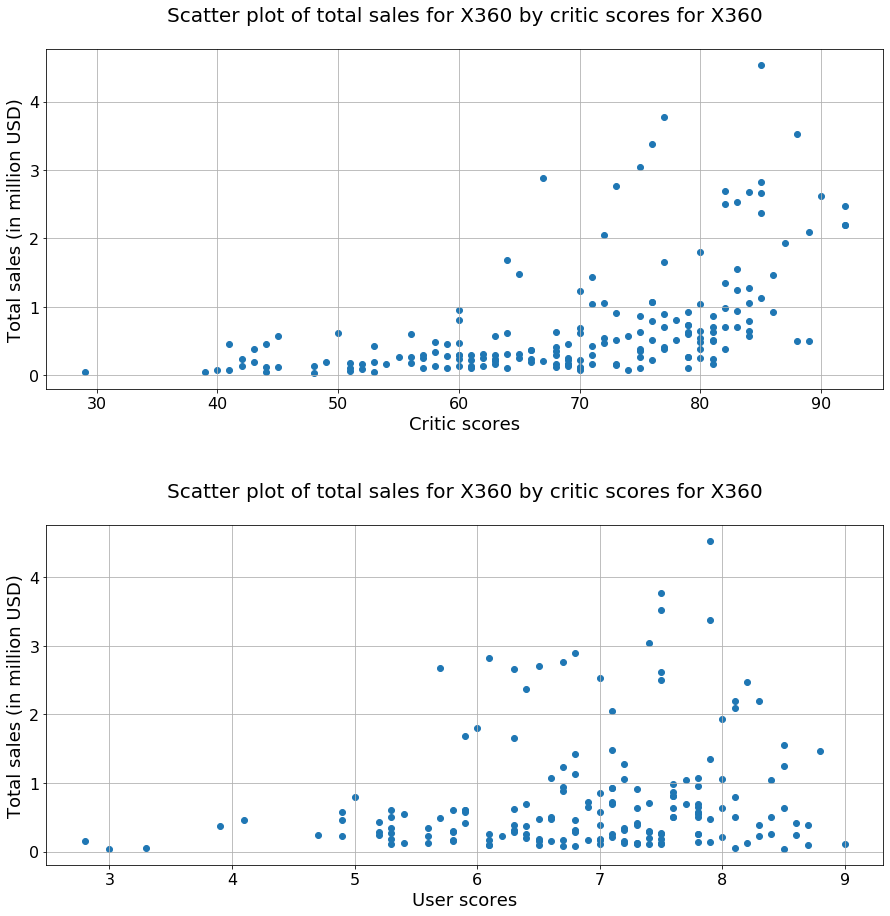

Correlation coefficient between total sales and critic scores for X360: 0.5165370362466837
Correlation coefficient between total sales and user scores for X360 : 0.1845206957820819


In [63]:
# Create scatterplot and compute correlation between revies and sales for the same games inn other platforms 

PS2_games_list = list(df_PS2['name'].to_numpy())

for platform in ['X360']:
    df_X360 = df_games.loc[df_games['platform'].isin([platform]) & df_games['name'].isin(PS2_games_list)].copy()

    df_sales_cscores = df_X360.loc[~df_X360['critic_score'].isnull()].copy()

    fig, axes = plt.subplots(2, 1, figsize=(15,15))
    axes[0].scatter(y= 'total_sales', x='critic_score',data=df_sales_cscores)
    axes[0].grid()
    axes[0].set_title('Scatter plot of total sales for {} by critic scores for X360\n'.format(platform), fontsize=20)

    axes[0].set_xlabel('Critic scores', fontsize=18)
    axes[0].set_ylabel('Total sales (in million USD)', fontsize=18)

    axes[0].tick_params(axis='x', labelsize=16)
    axes[0].tick_params(axis='y', labelsize=16)


    df_sales_uscores = df_X360.loc[~df_X360['user_score'].isnull()].copy()

    axes[1].scatter(y= 'total_sales', x='user_score',data=df_sales_uscores)
    axes[1].grid()
    axes[1].set_title('Scatter plot of total sales for {} by critic scores for X360\n'.format(platform), fontsize=20)

    axes[1].set_xlabel('User scores', fontsize=18)
    axes[1].set_ylabel('Total sales (in million USD)', fontsize=18)

    axes[1].tick_params(axis='x', labelsize=16)
    axes[1].tick_params(axis='y', labelsize=16)


    # Adjust spacing between the subplots
    plt.subplots_adjust(hspace = 0.4)
    plt.show()

    print('Correlation coefficient between total sales and critic scores for {}:'.format(platform), 
      df_X360['critic_score'].corr(df_X360['total_sales']))
    print('Correlation coefficient between total sales and user scores for {} :'.format(platform), 
      df_X360['user_score'].corr(df_X360['total_sales']))


We can see that the same conclusions follow for the X360 platform regarding the correlations between the critic/user scores and the total sales of the games that were also released on the PS2 platform.  

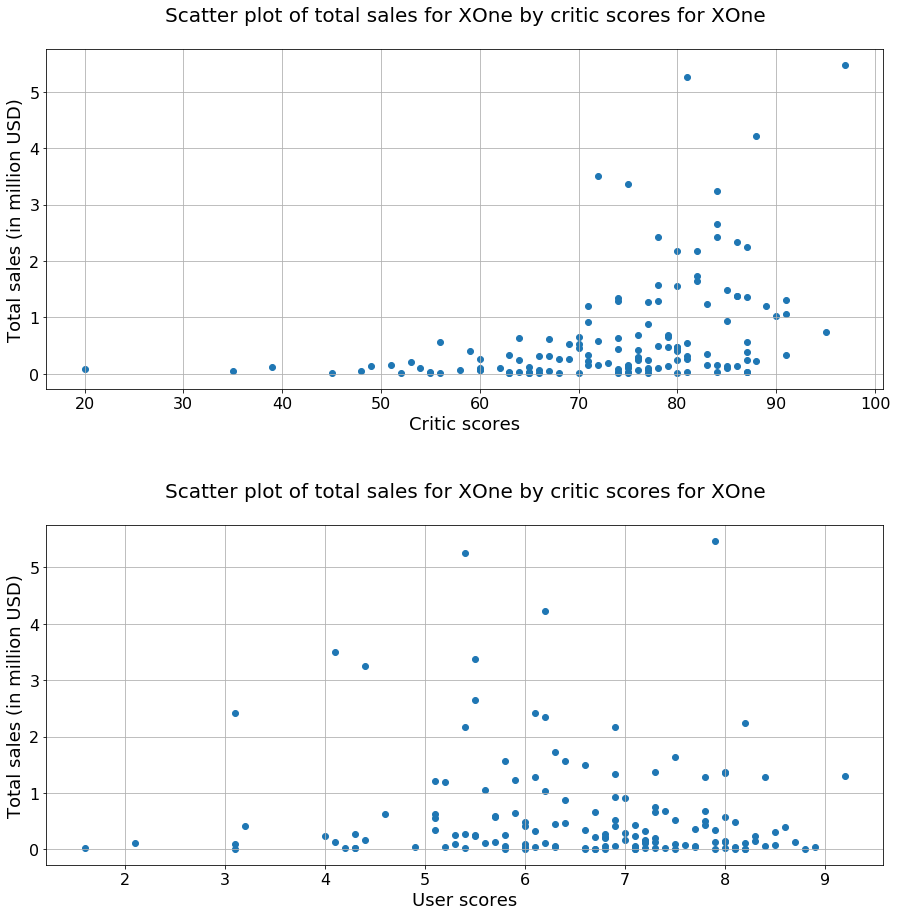

Correlation coefficient between total sales and critic scores for XOne: 0.39928209642290174
Correlation coefficient between total sales and user scores for XOne : -0.10664802025590633


In [64]:
# Create scatterplot and compute correlation between revies and sales for the same games inn other platforms 

PS4_games_list = list(df_PS4['name'].to_numpy())

for platform in ['XOne']:
    df_XOne = df_games_2014.loc[df_games_2014['platform'].isin([platform]) 
                                & df_games_2014['name'].isin(PS4_games_list)].copy()

    df_sales_cscores = df_XOne.loc[~df_XOne['critic_score'].isnull()].copy()

    fig, axes = plt.subplots(2, 1, figsize=(15,15))
    axes[0].scatter(y= 'total_sales', x='critic_score',data=df_sales_cscores)
    axes[0].grid()
    axes[0].set_title('Scatter plot of total sales for {} by critic scores for XOne\n'.format(platform), fontsize=20)

    axes[0].set_xlabel('Critic scores', fontsize=18)
    axes[0].set_ylabel('Total sales (in million USD)', fontsize=18)

    axes[0].tick_params(axis='x', labelsize=16)
    axes[0].tick_params(axis='y', labelsize=16)


    df_sales_uscores = df_XOne.loc[~df_XOne['user_score'].isnull()].copy()

    axes[1].scatter(y= 'total_sales', x='user_score',data=df_sales_uscores)
    axes[1].grid()
    axes[1].set_title('Scatter plot of total sales for {} by critic scores for XOne\n'.format(platform), fontsize=20)

    axes[1].set_xlabel('User scores', fontsize=18)
    axes[1].set_ylabel('Total sales (in million USD)', fontsize=18)

    axes[1].tick_params(axis='x', labelsize=16)
    axes[1].tick_params(axis='y', labelsize=16)


    # Adjust spacing between the subplots
    plt.subplots_adjust(hspace = 0.4)
    plt.show()

    print('Correlation coefficient between total sales and critic scores for {}:'.format(platform), 
      df_XOne['critic_score'].corr(df_XOne['total_sales']))
    print('Correlation coefficient between total sales and user scores for {} :'.format(platform), 
      df_XOne['user_score'].corr(df_XOne['total_sales']))


We can see that the same conclusions follow for the XOne platform regarding the correlations between the critic/user scores and the total sales of the games that were also released on the PS4 platform. It seems that the linear dependency between critic scores and total sales of video games did no change over time, while the one for user scores became even weaker. It would be interesting to investigate what could have caused this development.

Finally, let us take a look at the general distribution of released games by genre. We use the games dataframe restricted to the $2014$-$2016$ period.

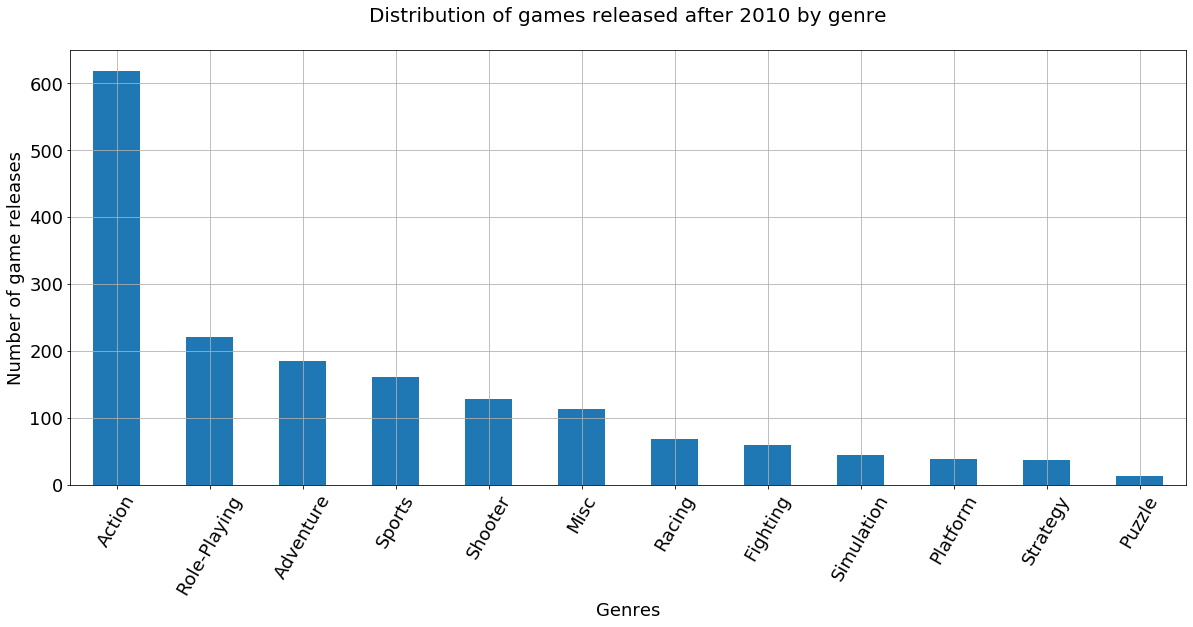

In [65]:
# Plot the general distribution of games by genre
(df_games_2014.loc[df_games['genre'] != 'Unknown']
 .groupby(by='genre')['name'].agg('count').sort_values(ascending=False).plot(kind='bar',figsize=(20, 8)))
plt.grid()
plt.ylabel("Number of game releases", rotation=90, fontsize=18)
plt.title('Distribution of games released after 2010 by genre\n', fontsize=20)
plt.xlabel('Genres', fontsize=18)
plt.xticks(fontsize=18, rotation=60)
plt.yticks(fontsize=18)
plt.show()


We see that the Action genre is the most dominant one on the market with about $600$ game releases. Moreover, Action games have been released more than twice compared to other genres. It is followed with Role-Playing, Adventure, Sports categories having close to $200$ game releases. Let us check if high number of game releases in genres translate to high sales or not. 

count    1689.000000
mean        0.431883
std         1.056109
min         0.010000
25%         0.030000
50%         0.100000
75%         0.350000
max        14.630000
Name: total_sales, dtype: float64

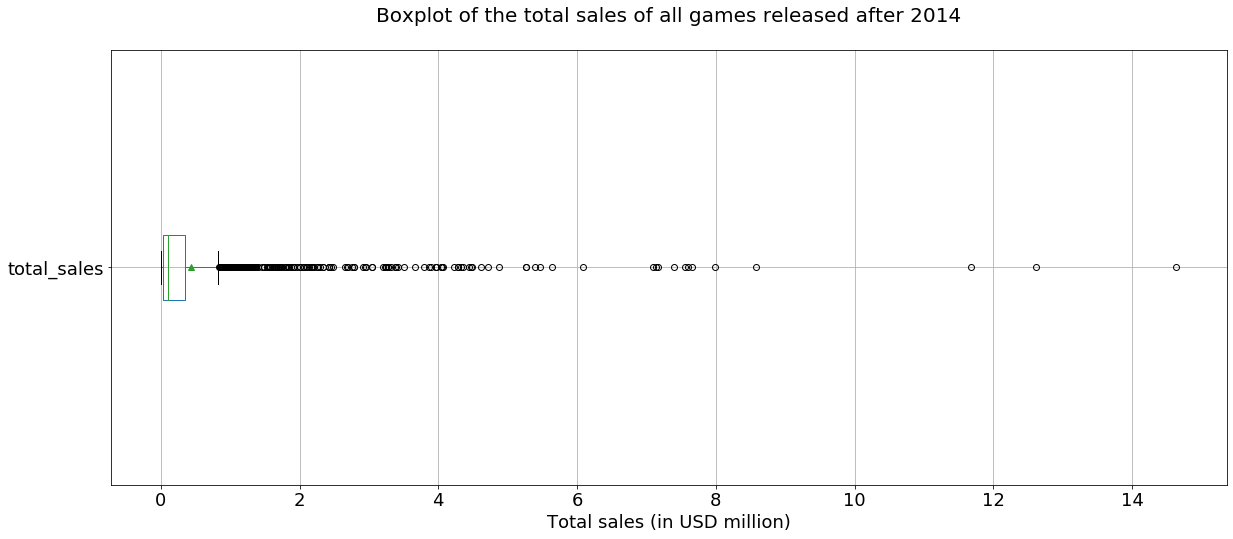

In [66]:
# Display summary statistics and boxplot for the total sales of games released after 2014
display(df_games_2014['total_sales'].describe())

df_games_2014.boxplot(column='total_sales', figsize=(20,8), 
                 grid=True, fontsize=16, vert=False, showmeans=True,
                 return_type='dict')

plt.suptitle('')
plt.ylabel("", rotation=90, fontsize=18)
plt.title('Boxplot of the total sales of all games released after 2014\n', fontsize=20)
plt.xlabel('Total sales (in USD million)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


In [67]:
# Define a function taking as argument the sales amount and grouping to low or high sales groups.
def sales_group(sales):
    """
    The function returns the sales group according to the sales amount, using the following rules:
    — 0 for sales less than the first quartile of 'total_sales' data
    — 1 for sales between the first quaritle and the third quartile of 'total_sales' data
    — 2 for sales between than the third quartile and the upper whisker of 'total_sales' data
    — 3 for sales larger than or equal to the upper whisker of 'total_sales' data
    """
    q1 = df_games_2014['total_sales'].describe()['25%']
    q2 = df_games_2014['total_sales'].describe()['50%']
    q3 = df_games_2014['total_sales'].describe()['75%']
    iqr = q3 - q1
    lw = q1 - 1.5*iqr
    uw = q3 + 1.5*iqr
    
    if sales < q1:
        return 0    # low
    if sales < q3:
        return 1    # moderate
    if sales < uw:
        return 2    # high
    return 3       # very high sales

df_games_2014['sales_group'] = df_games_2014['total_sales'].apply(sales_group)

display(df_games_2014.head())


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform,sales_group
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Undetermined,14.63,2013,2016,3
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62,2013,2016,3
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,Undetermined,11.68,2011,2016,3
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58,2013,2016,3
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,Undetermined,7.98,2013,2016,3


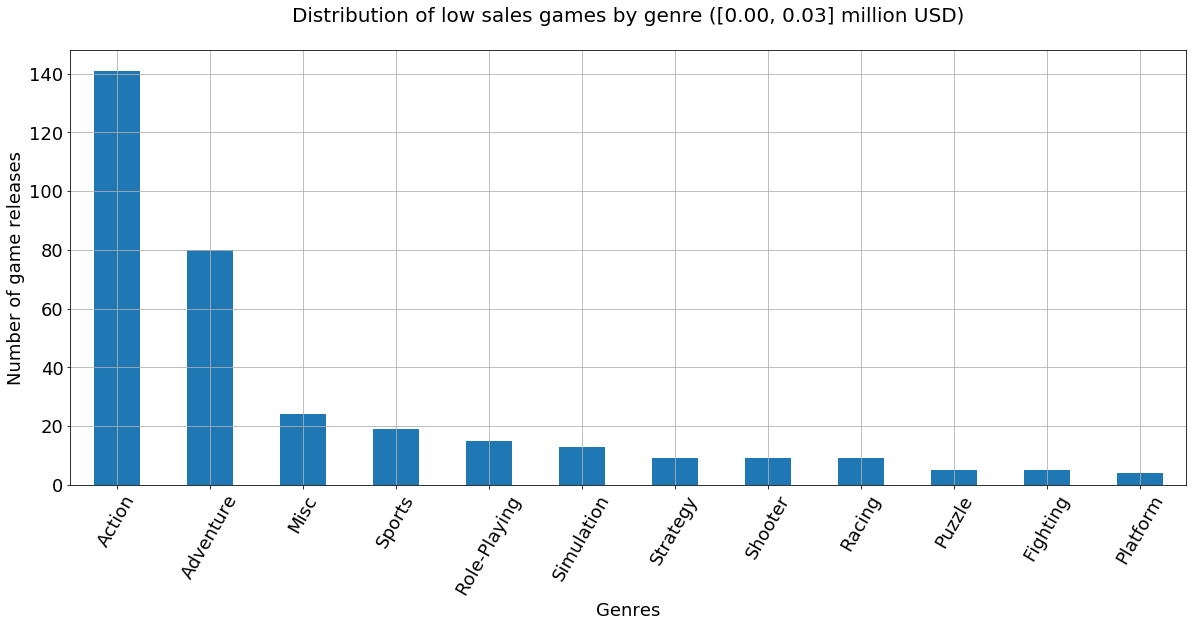

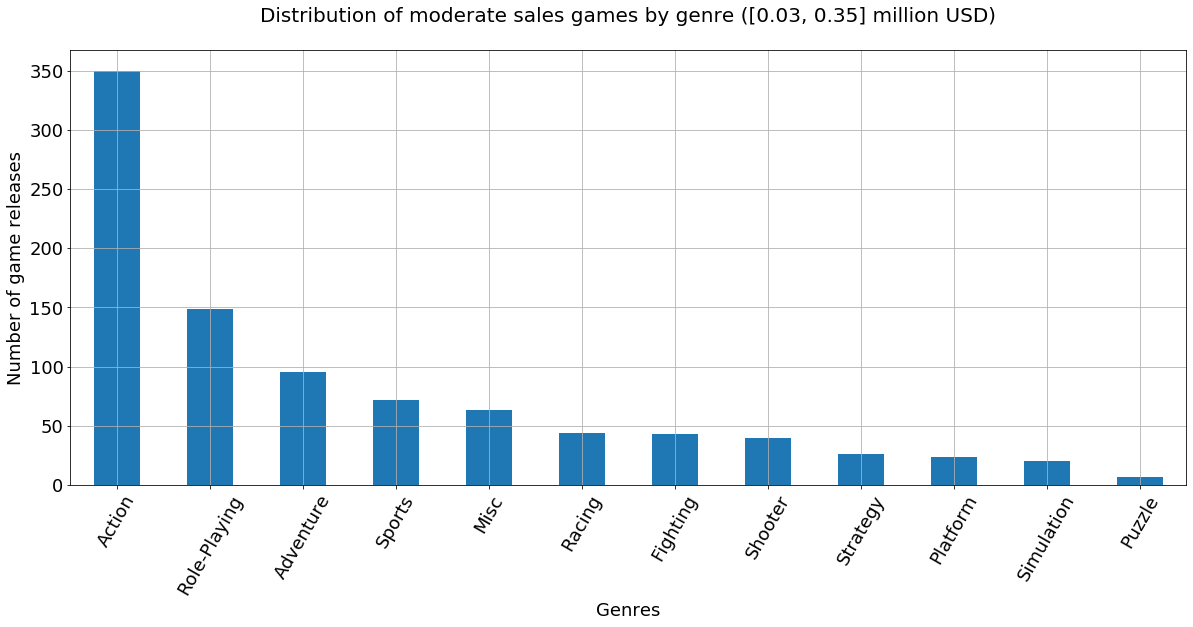

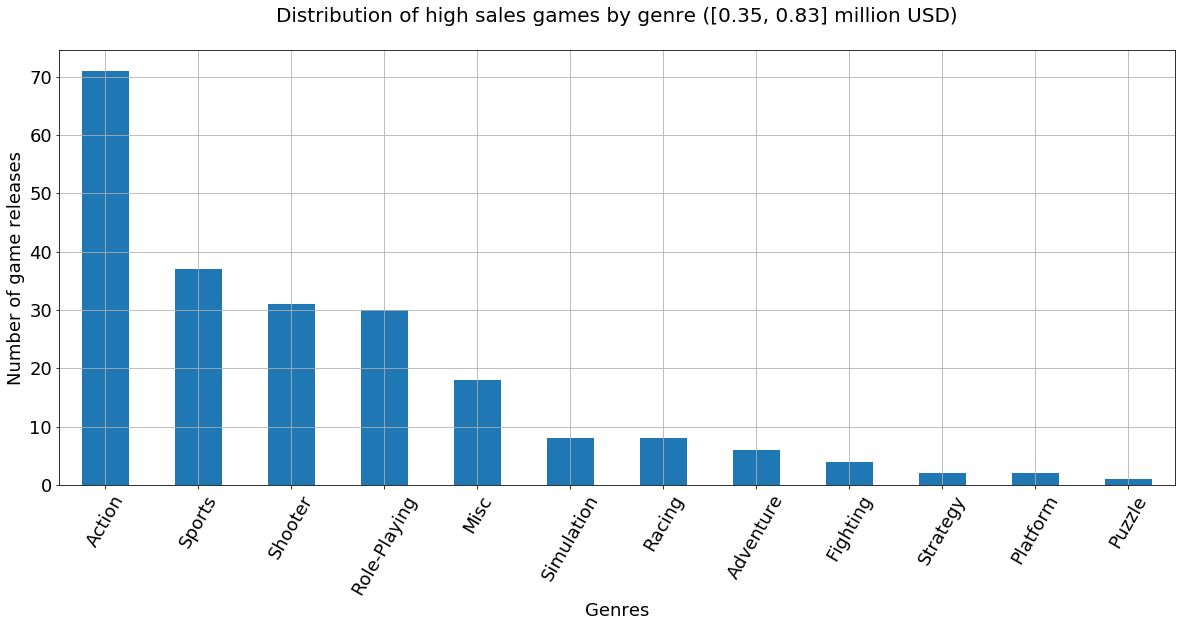

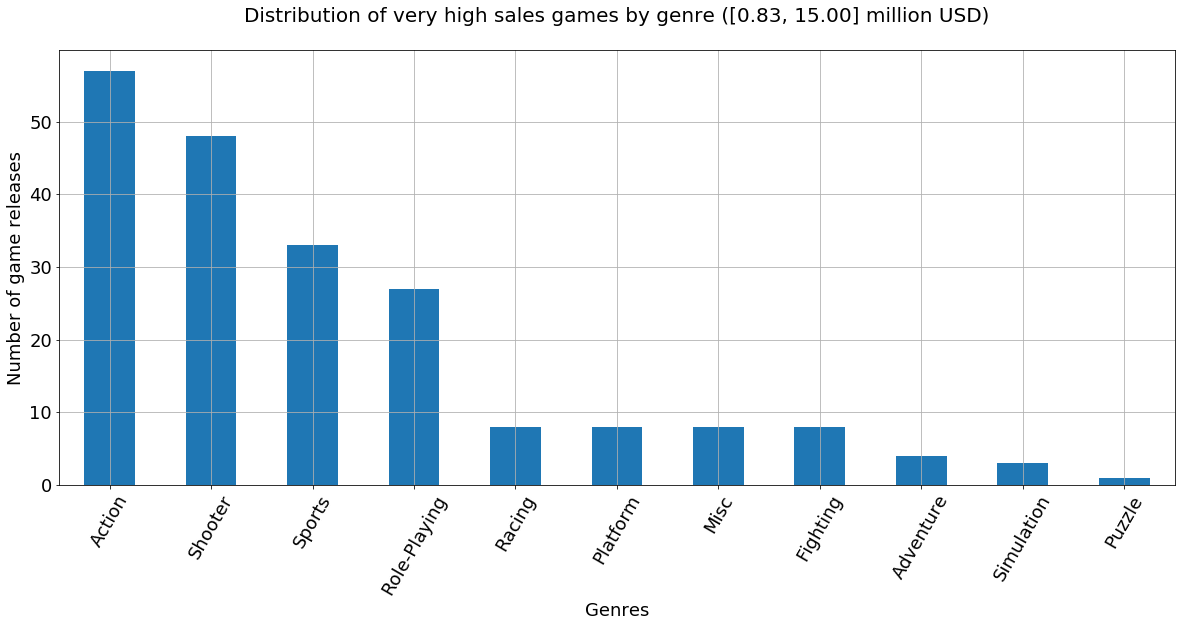

In [68]:
# Plot the general distribution of games by genre according to the sales group the games belong
sales_group_dict = {0: 'low', 1:'moderate', 2:'high' , 3:'very high'} 
q1 = df_games_2014['total_sales'].describe()['25%']
q2 = df_games_2014['total_sales'].describe()['50%']
q3 = df_games_2014['total_sales'].describe()['75%']
iqr = q3 - q1
lw = q1 - 1.5*iqr
uw = q3 + 1.5*iqr
m = df_games_2014['total_sales'].describe()['max'].round(0)

sales_group_thresholds = [0, q1, q3, uw, m]


for i in range(4):
    if not (df_games_2014['sales_group'] == i).all():
        (df_games_2014.loc[~df_games['genre'].isin(['Unknown']) & (df_games_2014['sales_group'] == i)]
         .groupby(by='genre')['total_sales'].agg('count').sort_values(ascending=False)
         .plot(kind='bar',figsize=(20, 8)))
        plt.grid()
        plt.ylabel("Number of game releases", rotation=90, fontsize=18)
        plt.title('Distribution of {} sales games by genre ([{:.2f}, {:.2f}] million USD)\n'
                  .format(sales_group_dict[i], sales_group_thresholds[i],
                          sales_group_thresholds[i+1]), fontsize=20)
        plt.xlabel('Genres', fontsize=18)
        plt.xticks(fontsize=18, rotation=60)
        plt.yticks(fontsize=18)
        plt.show()
    

We observe that the Action genre is popular in all sales groups. Shooter and Sports genres come forward generating most reveneus after Action games. Although we saw that Role-Playing and Adventure genres are dominant on the market in terms of number of releases, we can see that they do not necessarily generate highest revenues. In particular, the majority of Role-Playing games generate moderate sales and the majority of Adventure games low sales.

**Concluding remarks** In this step, we build a prognosis for $2017$. The biggest winner is expected to be PS4, displaying a remarkably fast growth rate in recent years. The platforms XOne and 3DS are also fast growing and deserves attention as the followers. We should also be on the watch for two other slowly growing platforms PSV and WiiU. The steadily growing PC platforms also present itself as a safe but less profitable option. The X360, PS3,and Wii platforms are expected to still generate some revenues, but our data showed that these platforms are close to the end of their lifespan. All other platform among the $31$ platforms we started with turned out to be out of interest. In fact, discarding the data prior to $2014$ we ended up with data for only $10$ platforms. This is not surprising. As the available data showed us the life expectancy of the average platform is $6$ years, and new platforms pop in on average once every year. We limited our analysis to the period $2014$-$2016$ to makes sure our predictions for $2017$ do not include lagging trends as released games are rarely relevant more than $3$ or $4$ years.

After studying growth in sales for the platforms, we studied potential factors that influenced games sales in the period $2014$-$2016$. We identified that while the sales performance of games are midly linearly dependent on critic scores, there is almost no linear dependency to user scores. We also identified popular genres in the market and looked at which genres generate more sales and which ones less.

<a class="anchor" id="step4"></a> 
### Step 4. Regional user preference profiles for each region

For each region (NA, EU, JP), we build user preference profiles by determining the top five platforms, the top five genres, and the impact of ESRB ratings on the regional sales. We limit the analysis to data from the period $2014$-$2016$. 

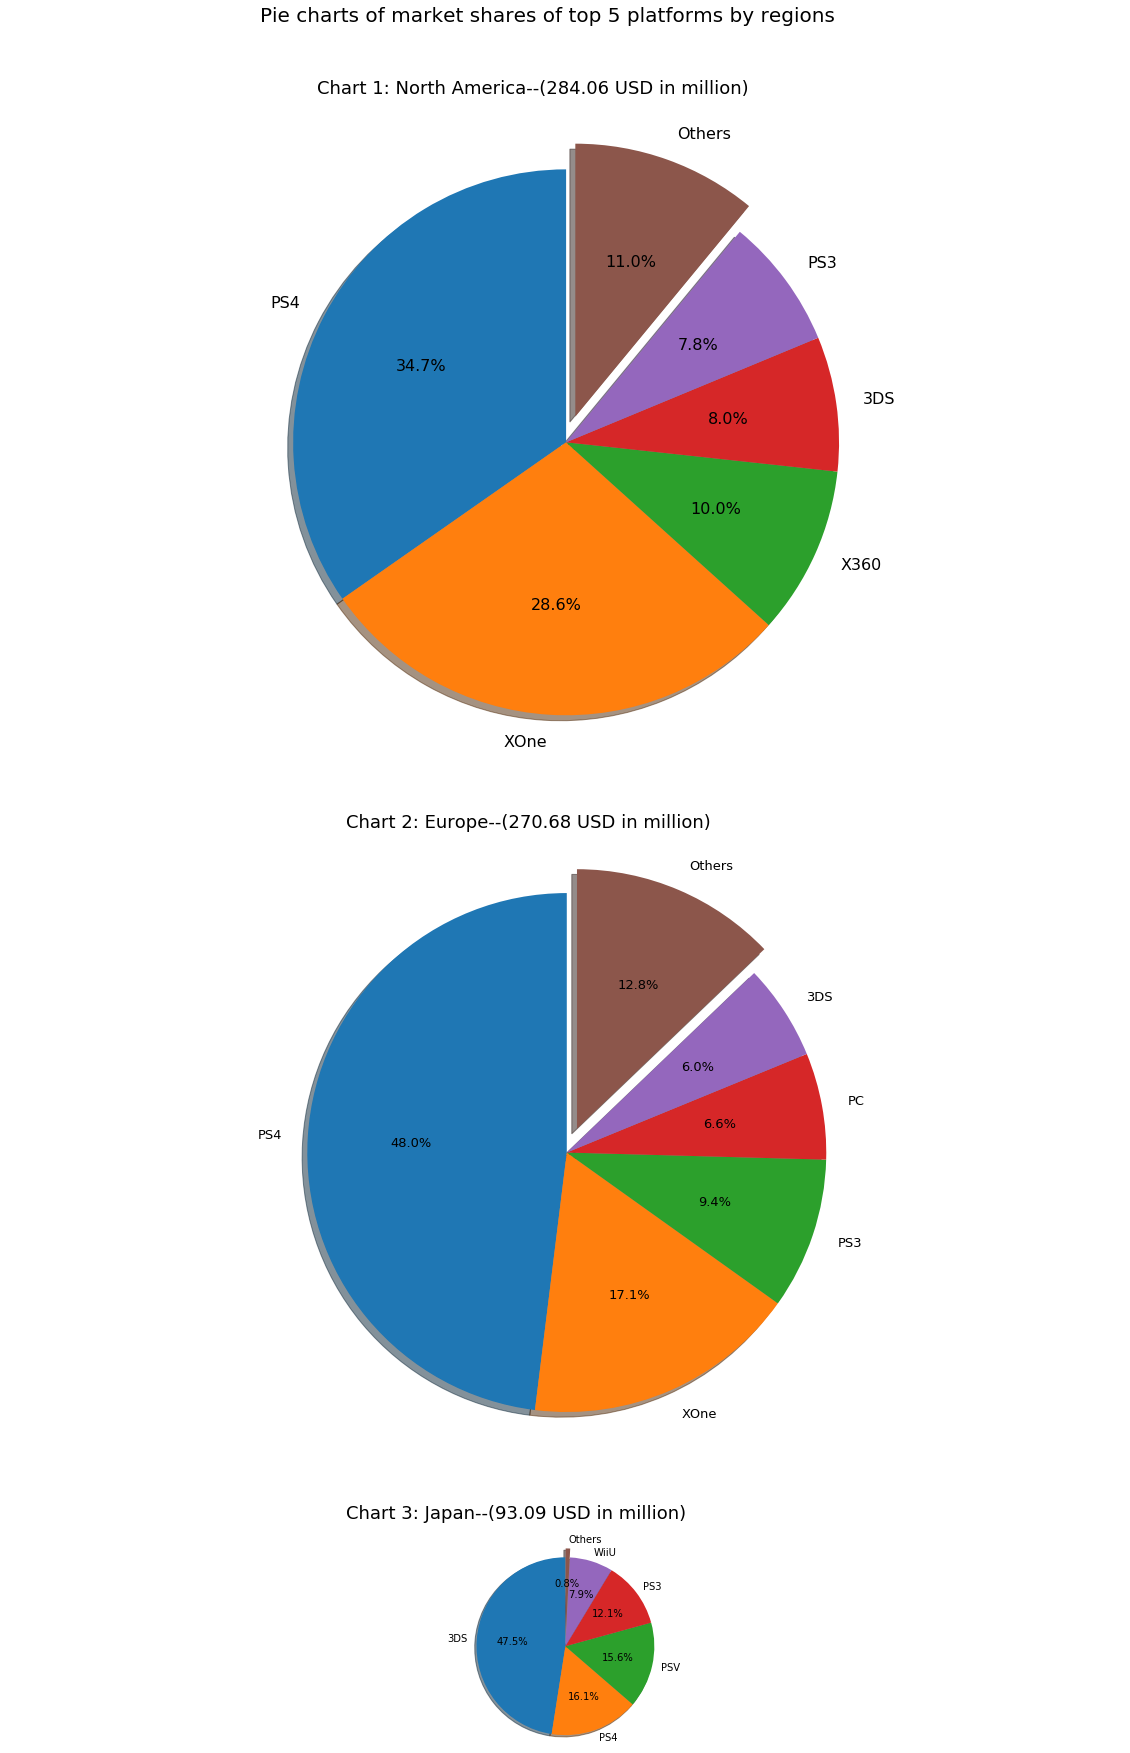

In [69]:
# Create pie chart for the regional market shares of top five platforms
market_shares = df_games_2014.groupby(by='platform')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].agg('sum')
# display(market_shares)

market_volumes = market_shares.sum(axis=0)
ratios = market_volumes/market_volumes.sum()

market_shares = market_shares.div(market_shares.sum(axis=0), axis=1)*100
# display(market_shares)


fig, ax = plt.subplots(3, 1, figsize=(20, 30), gridspec_kw={'height_ratios':list(ratios[:3])})
i = 0
region_list = ['na_sales', 'eu_sales', 'jp_sales']
for region in region_list:
    market_shares = market_shares.sort_values(by=region, ascending=False)
    labels = list(market_shares.iloc[0:5].index)
    labels.append('Others')
    sizes = list(market_shares.iloc[0:5][region])
    sizes.append(100.00- np.sum(sizes))
    explode = (0, 0, 0, 0, 0, 0.1)  # do not "explode" any slice

    # Pie chart, where the slices will be ordered and plotted counter-clockwise:

    ax[i].pie(sizes, explode=explode,
              labels=labels, autopct='%1.1f%%', textprops={'fontsize': 16-3*i},
        shadow=True, startangle=90)
    ax[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    i += 1

# Remove the title from the Boxplots
y_title_pos = ax[0].get_position().get_points()[1][1]+0.05
plt.suptitle('Pie charts of market shares of top 5 platforms by regions\n ', fontsize=20, y=y_title_pos)
# ax[0].set_title('North America\n({:.2f} million USD)'.format(market_volumes['na_sales']), fontsize='16')
# ax[0].legend(loc='upper right', fontsize=14)
plt.figtext(0.34, 0.89, 
   "Chart 1: North America--({} USD in million)".format(market_volumes[0].round(2)),
                      linespacing = 2, fontsize=18)
#              for a, b in zip(labels, [13.7, 13.3, 11.3, 8.9, 8.7, 44.1])], loc='upper right', fontsize=16)
# ax[1].set_title('Europe\n({:.2f} million USD)'.format(market_volumes['eu_sales']), fontsize='16')
# ax[1].legend(loc='right', fontsize=14)
plt.figtext(0.36, 0.55, 
   "Chart 2: Europe--({} USD in million)".format(market_volumes[1].round(2)),
                      linespacing = 2, fontsize=18)
#ax[1].legend(["{}---({}%)".format(a, b) 
#              for a, b in zip(labels, [14.0, 13.6, 11.2, 10.8, 8.8, 44.6])], loc='lower right', fontsize=16)
# ax[2].set_title('Japan\n({:.2f} million USD)'.format(market_volumes['jp_sales']), fontsize='16')
# ax[2].legend(["{}---({}%)".format(a, b) 
#             for a, b in zip(labels, [13.5, 10.8, 10.7, 9.0, 7.8, 48.2])], loc='lower right', fontsize=12)

plt.figtext(0.36, 0.23, 
   "Chart 3: Japan--({} USD in million)".format(market_volumes[2].round(2)),
                      linespacing = 2, fontsize=18)
plt.show()


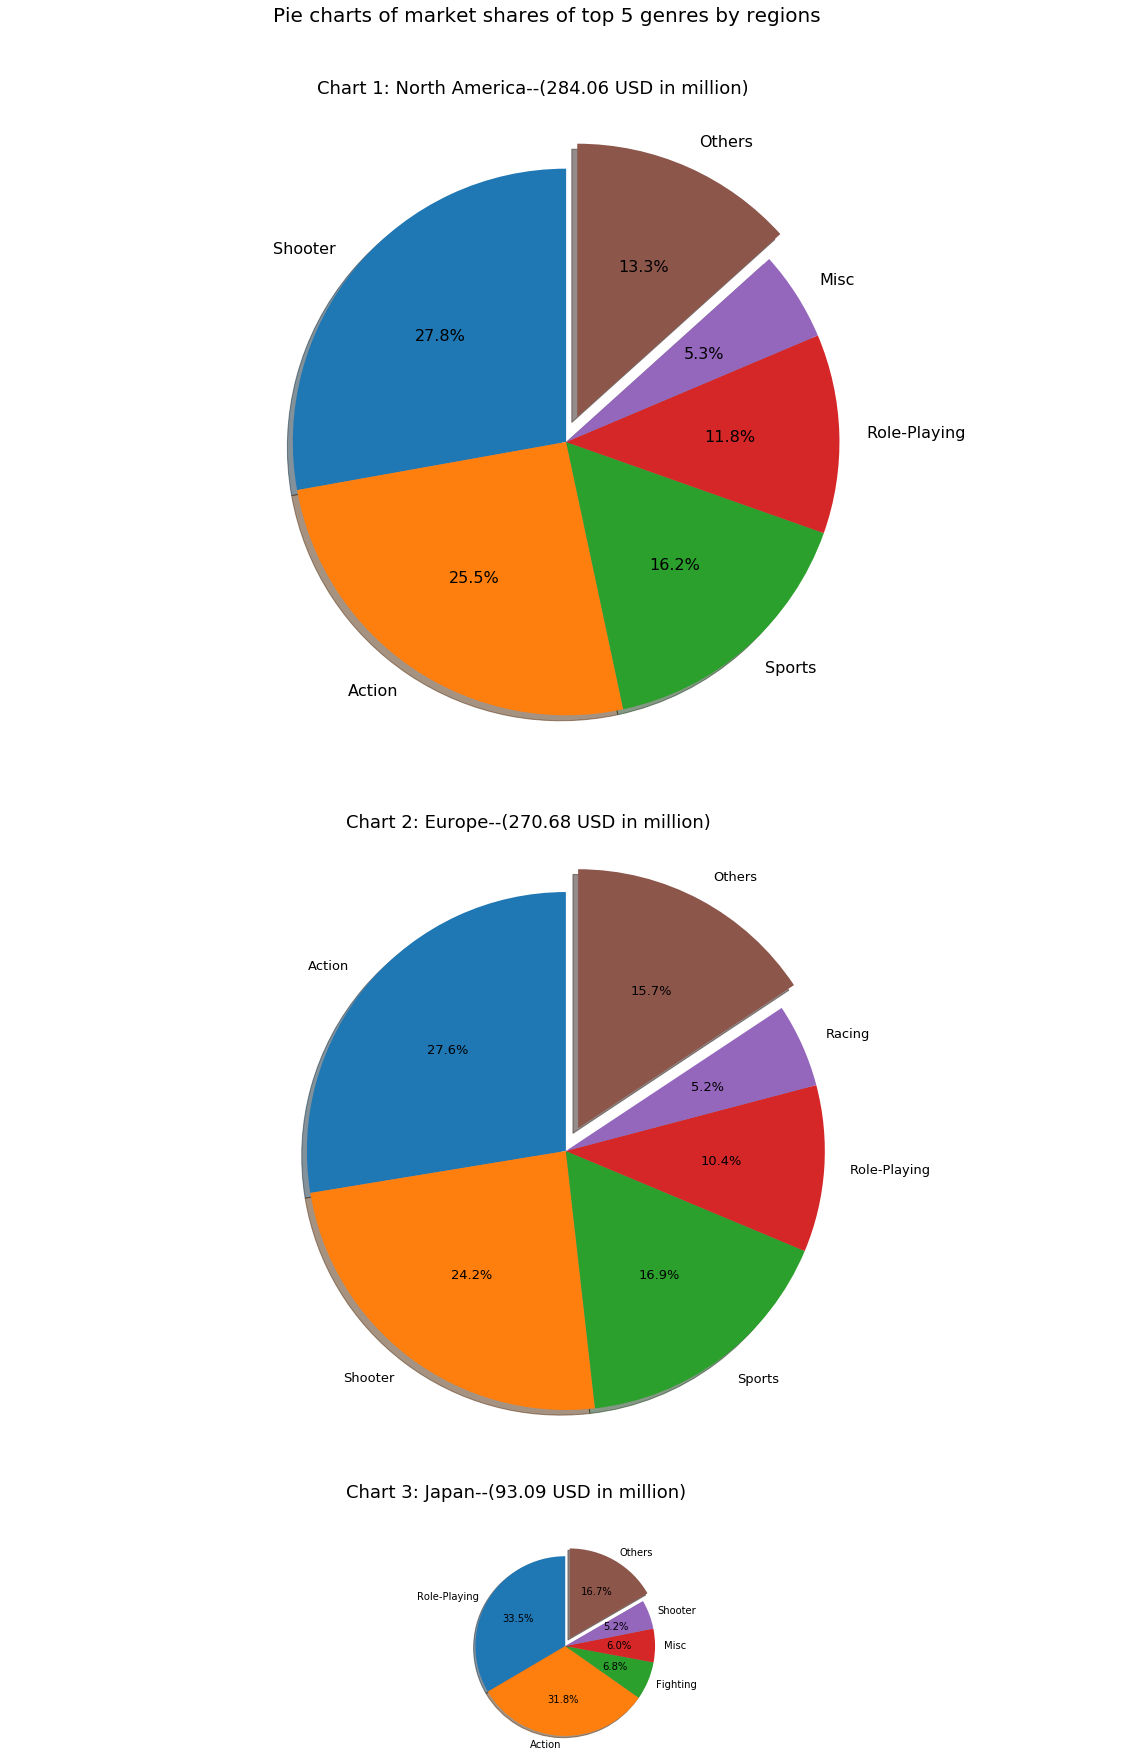

In [70]:
# Create pie charts for the regional market shares of top 5 genres
market_shares = df_games_2014.groupby(by='genre')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].agg('sum')
# display(market_shares)

market_volumes = market_shares.sum(axis=0)
ratios = market_volumes/market_volumes.sum()

market_shares = market_shares.div(market_shares.sum(axis=0), axis=1)*100
# display(market_shares)


fig, ax = plt.subplots(3, 1, figsize=(20, 30), gridspec_kw={'height_ratios':list(ratios[:3])})
i = 0
region_list = ['na_sales', 'eu_sales', 'jp_sales']
for region in region_list:
    market_shares = market_shares.sort_values(by=region, ascending=False)
    labels = list(market_shares.iloc[0:5].index)
    labels.append('Others')
    sizes = list(market_shares.iloc[0:5][region])
    sizes.append(100.00- np.sum(sizes))
    explode = (0, 0, 0, 0, 0, 0.1)  # do not "explode" any slice

    # Pie chart, where the slices will be ordered and plotted counter-clockwise:

    ax[i].pie(sizes, explode=explode,
              labels=labels, autopct='%1.1f%%', textprops={'fontsize': 16-3*i},
        shadow=True, startangle=90)
    ax[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    i += 1

# Remove the title from the Boxplots
y_title_pos = ax[0].get_position().get_points()[1][1]+0.05
plt.suptitle('Pie charts of market shares of top 5 genres by regions\n ', fontsize=20, y=y_title_pos)
# ax[0].set_title('North America\n({:.2f} million USD)'.format(market_volumes['na_sales']), fontsize='16')
# ax[0].legend(loc='upper right', fontsize=14)
plt.figtext(0.34, 0.89, 
   "Chart 1: North America--({} USD in million)".format(market_volumes[0].round(2)),
                      linespacing = 2, fontsize=18)
#              for a, b in zip(labels, [13.7, 13.3, 11.3, 8.9, 8.7, 44.1])], loc='upper right', fontsize=16)
# ax[1].set_title('Europe\n({:.2f} million USD)'.format(market_volumes['eu_sales']), fontsize='16')
# ax[1].legend(loc='right', fontsize=14)
plt.figtext(0.36, 0.55, 
   "Chart 2: Europe--({} USD in million)".format(market_volumes[1].round(2)),
                      linespacing = 2, fontsize=18)
#ax[1].legend(["{}---({}%)".format(a, b) 
#              for a, b in zip(labels, [14.0, 13.6, 11.2, 10.8, 8.8, 44.6])], loc='lower right', fontsize=16)
# ax[2].set_title('Japan\n({:.2f} million USD)'.format(market_volumes['jp_sales']), fontsize='16')
# ax[2].legend(["{}---({}%)".format(a, b) 
#             for a, b in zip(labels, [13.5, 10.8, 10.7, 9.0, 7.8, 48.2])], loc='lower right', fontsize=12)

plt.figtext(0.36, 0.24, 
   "Chart 3: Japan--({} USD in million)".format(market_volumes[2].round(2)),
                      linespacing = 2, fontsize=18)
plt.show()


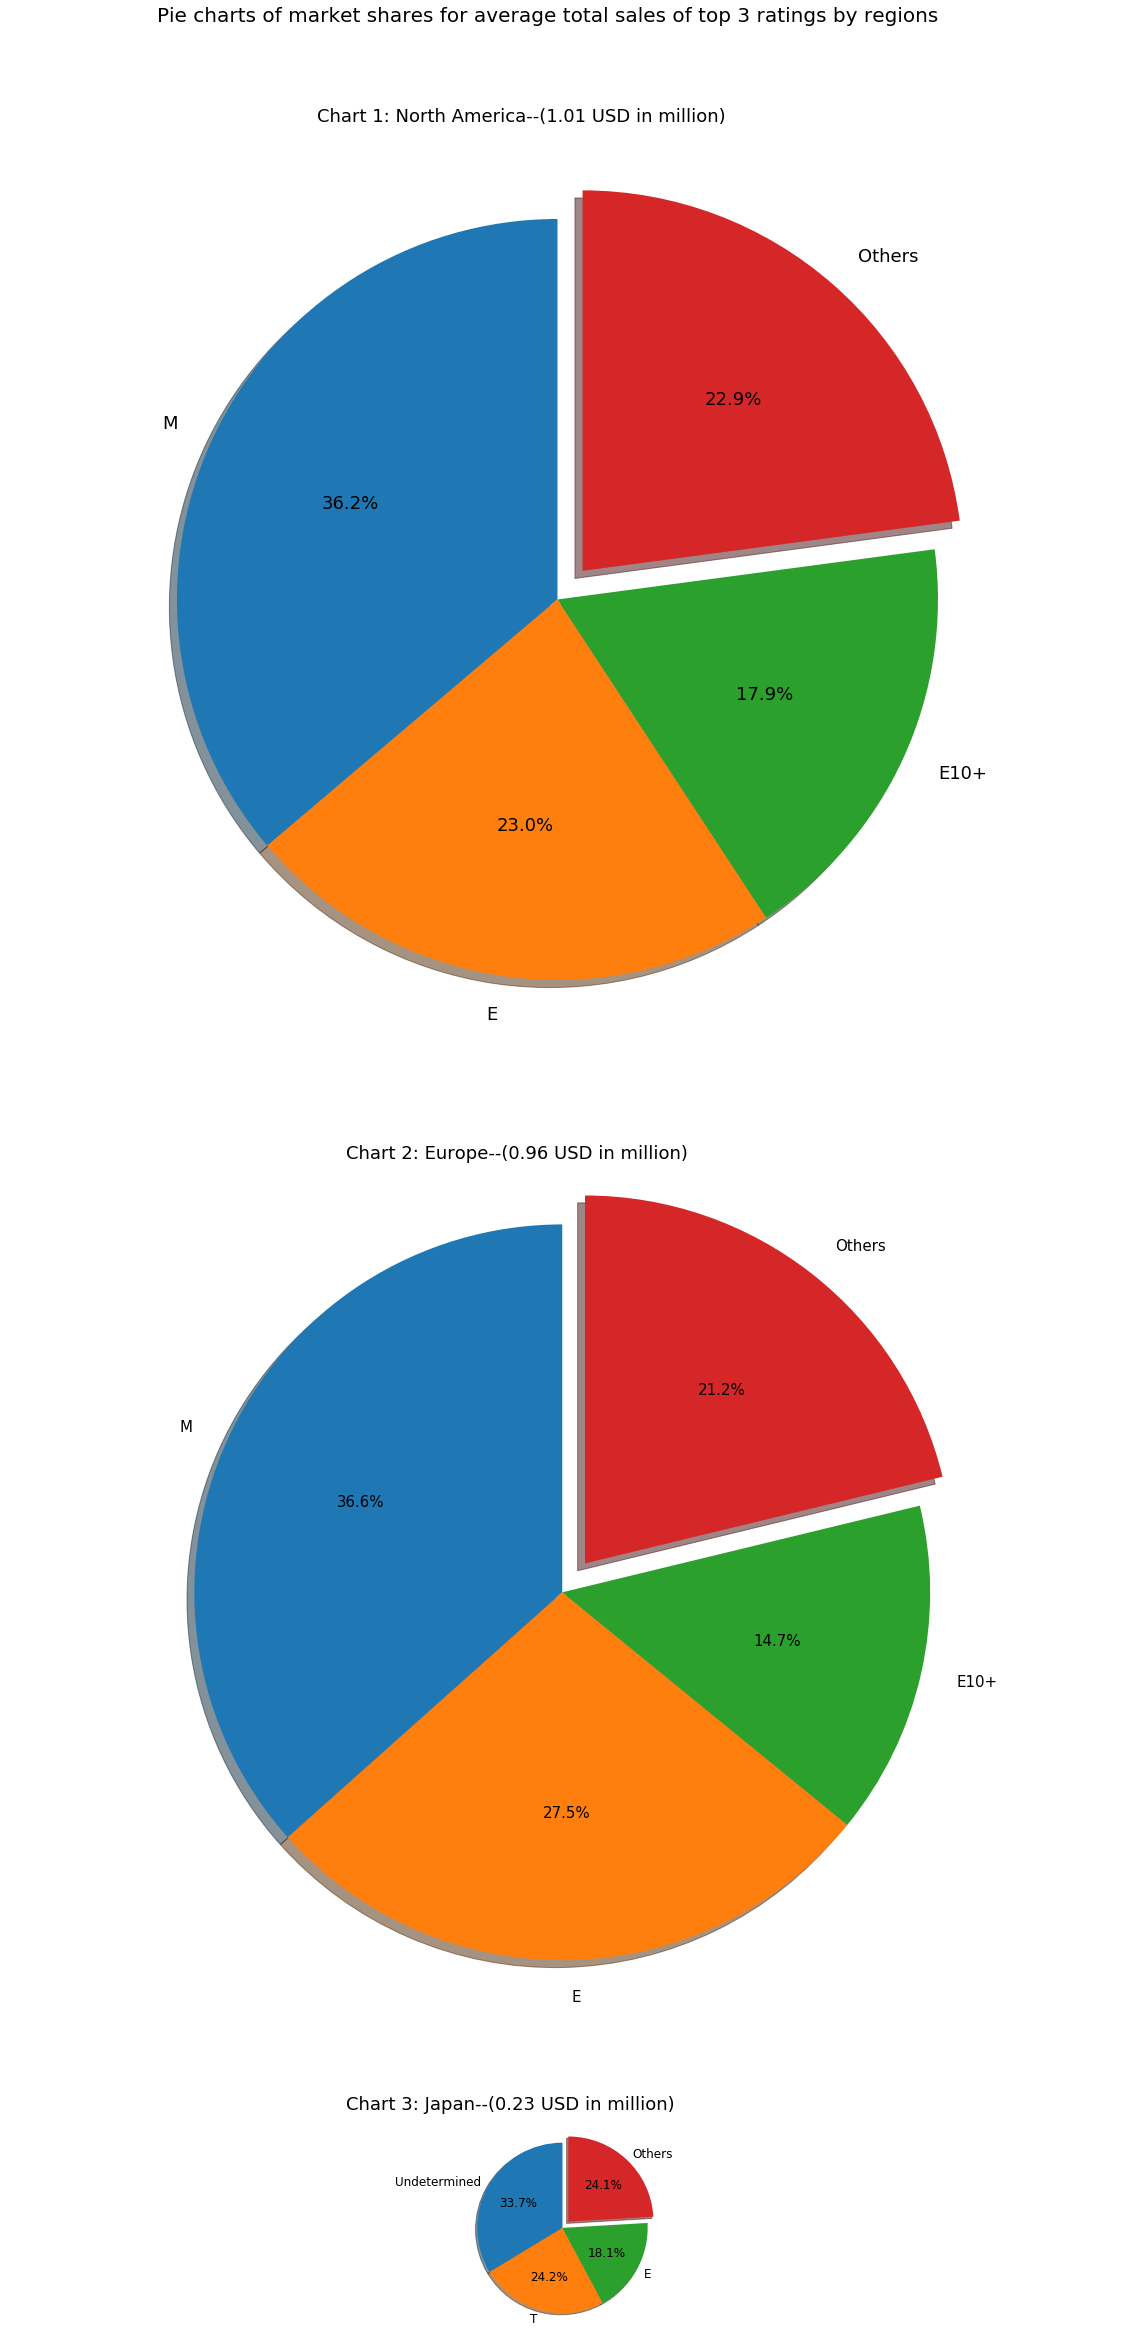

In [71]:
# Create pie charts for the regional market shared of top 3 ratings

market_shares = df_games_2014.groupby(by='rating')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].agg('mean')
market_volumes = market_shares.sum(axis=0)
ratios = market_volumes/market_volumes.sum()

market_shares = market_shares.div(market_shares.sum(axis=0), axis=1)*100
# display(market_shares)


fig, ax = plt.subplots(3, 1, figsize=(20, 40), gridspec_kw={'height_ratios':list(ratios[:3])})
i = 0
region_list = ['na_sales', 'eu_sales', 'jp_sales']
for region in region_list:
    market_shares = market_shares.sort_values(by=region, ascending=False)
    labels = list(market_shares.iloc[0:3].index)
    labels.append('Others')
    sizes = list(market_shares.iloc[0:3][region])
    sizes.append(100.00- np.sum(sizes))
    explode = (0, 0, 0, 0.1)  # do not "explode" any slice

    # Pie chart, where the slices will be ordered and plotted counter-clockwise:

    ax[i].pie(sizes, explode=explode,
              labels=labels, autopct='%1.1f%%', textprops={'fontsize': 18-3*i},
        shadow=True, startangle=90)
    ax[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    i += 1

# Adjust spacing between the subplots
# Remove the title from the Boxplots
y_title_pos = ax[0].get_position().get_points()[1][1]+0.05
plt.suptitle('Pie charts of market shares for average total sales of top 3 ratings by regions\n ', 
             fontsize=20, y=y_title_pos)
# ax[0].set_title('North America\n({:.2f} million USD)'.format(market_volumes['na_sales']), fontsize='16')
# ax[0].legend(loc='upper right', fontsize=14)
plt.figtext(0.34, 0.89, 
   "Chart 1: North America--({} USD in million)".format(market_volumes[0].round(2)),
                      linespacing = 2, fontsize=18)
#              for a, b in zip(labels, [13.7, 13.3, 11.3, 8.9, 8.7, 44.1])], loc='upper right', fontsize=16)
# ax[1].set_title('Europe\n({:.2f} million USD)'.format(market_volumes['eu_sales']), fontsize='16')
# ax[1].legend(loc='right', fontsize=14)
plt.figtext(0.36, 0.53, 
   "Chart 2: Europe--({} USD in million)".format(market_volumes[1].round(2)),
                      linespacing = 2, fontsize=18)
#ax[1].legend(["{}---({}%)".format(a, b) 
#              for a, b in zip(labels, [14.0, 13.6, 11.2, 10.8, 8.8, 44.6])], loc='lower right', fontsize=16)
# ax[2].set_title('Japan\n({:.2f} million USD)'.format(market_volumes['jp_sales']), fontsize='16')
# ax[2].legend(["{}---({}%)".format(a, b) 
#             for a, b in zip(labels, [13.5, 10.8, 10.7, 9.0, 7.8, 48.2])], loc='lower right', fontsize=12)

plt.figtext(0.36, 0.2, 
   "Chart 3: Japan--({} USD in million)".format(market_volumes[2].round(2)),
                      linespacing = 2, fontsize=18)
plt.show()


**Concluding remarks:** In this step, we analyzed regional market shares per platform, genre, and ratings. We summarize below our findings:

1) North America user profile
    - Top platforms: PS4, XOne, X360, 3DS, PS3
    - Top genres: Shooter, Action, Sports, Role-Playing, Misc
    - Top ratings: M, E, E10+
2) Europe user profile
    - Top platforms: PS4, XOne, PS3, PC, 3DS
    - Top genres: Action, Shooter, Sports, Role-Playing, Racing
    - Top ratings: M, E, E10+
3) Japan user profile
    - Top platforms: 3DS, PS4, PSV, PS3, WiiU
    - Top genres: Role-Playing, Action, Fighting, Misc, Shooter
    - Top ratings: Undetermined, T, E.
    
These findings indicate that there could be important variations across regions that should be taken into account when planning marketing campaings, especially for the Japanese region. We can see that games whose ratings are Undetermined genrates the highest sales in the Japanese market. Since ESBR is an American self-regulatory organization, games that are not released in North America will not be rated. Therefore, we should be careful in relying to the ESBR ratings outside of North America.

<a class="anchor" id="step5"></a> 
### Step 5. Hypothesis testing

In this step, we test the following two hypotheses:
- **Hypothesis 1:**  Average user ratings of the Xbox One and PC platforms are the same.
- **Hypothesis 2:**  Average user ratings for the Action and Sports genres are different.

Before performing the tests, let us decide which test and what alpha value to use, and discuss any criterion we use to test the hypotheses.

<a class="anchor" id="step5_1"></a> 
#### Step 5.1 Testing Hypothesis 1

We formulate the null and alternative hypotheses as follows:
- **Null Hypothesis:** The average user ratings of the Xbox One and PC platforms are equal.
- **Alternative Hypothesis:** The average user ratings of the Xbox One and PC platforms differ.

We start by discussing which test we will use to test the hypotheses. Note that in both cases, we will be testing whether the sample means of two games populations from the dataset are equal or differ. In such cases, one of the most commonly used test is the t-test and we want to use this test. Luckily, the scipy library has the testing algorithm implemented, so we need not worry about coding that. However, we need to discuss which values to set for two variables. The first one is the critical value alpha which is specified to set the sample significance level of the hypothesis test. Here we will set it to $5\%$. The second one is the 'equal_var' argument of the testing algorithm. If we believe that the samples are taken from populations with similar parameters, we should set the 'equal_var' argument to True. Otherwise, we should set it to False. We will set this argument as follows. For each sample group, we will compute the variance of the average monthly revenues. Then, if these variances do not differ more than $5\%$, we will set the value to True, otherwise if the difference is larger, we will set it to False.

The t-test is sensitive to outliers because it is based on the sample mean and the sample variance of the sample values. Therefore, before using the test, it is very important we check for outliers and remove them from our samples.

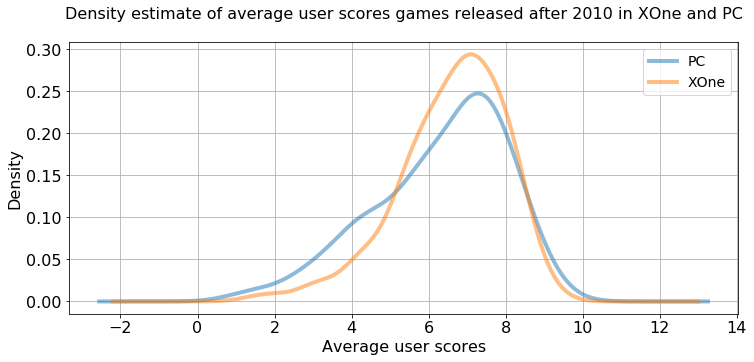

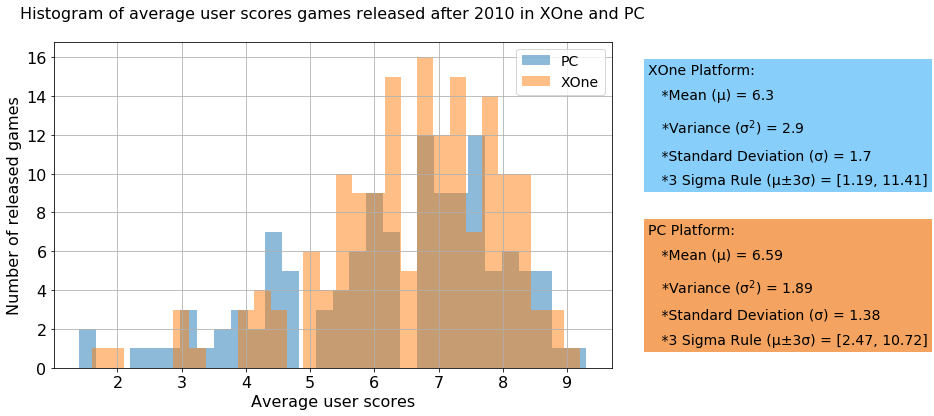


User score outliers from XOne and PC platform by 3 sigma rule:


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform,sales_group
15406,Sacred 3,PC,2014,Role-Playing,0.0,0.02,0.0,0.0,57.0,1.4,M,0.02,1985,2016,0
15483,RollerCoaster Tycoon World,PC,2016,Simulation,0.0,0.02,0.0,0.0,43.0,2.4,E,0.02,1985,2016,0
16518,Rugby World Cup 2015,PC,2015,Sports,0.0,0.01,0.0,0.0,NaN,1.4,E,0.01,1985,2016,0


In [72]:
# Outlier analysis
df_hyptest_1 = df_games_2014.loc[(~df_games_2014['user_score'].isnull()) & 
                            (df_games_2014['platform'].isin(['XOne', 'PC']))]

group = df_hyptest_1.groupby(by=['platform'])['user_score']
group_stats = group.describe()


# Plot density estimate
plt.figure()
group.plot(kind="kde", alpha=0.5, grid=True, figsize=(12,5), lw=4)
plt.title("Density estimate of average user scores games released after 2010 in XOne and PC\n", fontsize=16)
plt.xlabel("Average user scores", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Density", fontsize=16)   
plt.legend(fontsize=14)
plt.show()
print()

# Plot histogram
plt.figure()
group.plot(kind="hist", alpha=0.5, bins=30, grid=True, figsize=(10,6))
plt.title("Histogram of average user scores games released after 2010 in XOne and PC\n", fontsize=16)
plt.xlabel("Average user scores", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Number of released games", fontsize=16)   
plt.legend(fontsize=14)
plt.figtext(0.95, 0.55, 
   "XOne Platform:\n   *Mean (\u03BC) = {}\n   *Variance (\u03C3$^2$) = {}\n   *Standard Deviation (\u03C3) = {}\n"
   "   *3 Sigma Rule (\u03BC\u00B13\u03C3) = [{}, {}]"
                     .format(group_stats.iloc[0,1].round(2), 
                            (group_stats.iloc[0,2]**2).round(2), 
                            group_stats.iloc[0,2].round(2),
                            (group_stats.iloc[0,1] - 3*group_stats.iloc[0,2]).round(2),
                            (group_stats.iloc[0,1] + 3*group_stats.iloc[0,2]).round(2)),
                      linespacing = 2, fontsize=14, backgroundcolor='lightskyblue')
plt.figtext(0.95, 0.18, 
   "PC Platform:\n   *Mean (\u03BC) = {}\n   *Variance (\u03C3$^2$) = {}\n   *Standard Deviation (\u03C3) = {}\n"
   "   *3 Sigma Rule (\u03BC\u00B13\u03C3) = [{}, {}]"
                     .format(group_stats.iloc[1,1].round(2), 
                            (group_stats.iloc[1,2]**2).round(2), 
                            group_stats.iloc[1,2].round(2),
                            (group_stats.iloc[1,1] - 3*group_stats.iloc[1,2]).round(2),
                            (group_stats.iloc[1,1] + 3*group_stats.iloc[1,2]).round(2)),
                      linespacing = 2, fontsize=14, backgroundcolor='sandybrown')
plt.show()
print()


# Get  of outliers from 3 sigma rule
platform_outliers_3sigma = df_hyptest_1[(df_hyptest_1['platform'] == 'XOne') & 
                           (df_hyptest_1['user_score'] > group_stats.iloc[0,1] + 3*group_stats.iloc[0,2])]
platform_outliers_3sigma = platform_outliers_3sigma.append(df_hyptest_1[(df_hyptest_1['platform'] == 'PC') & 
                          (df_hyptest_1['user_score'] > group_stats.iloc[1,1] + 3*group_stats.iloc[1,2])])
platform_outliers_3sigma = platform_outliers_3sigma.append(df_hyptest_1[(df_hyptest_1['platform'] == 'XOne') & 
                           (df_hyptest_1['user_score'] < group_stats.iloc[0,1] - 3*group_stats.iloc[0,2])])
platform_outliers_3sigma = platform_outliers_3sigma.append(df_hyptest_1[(df_hyptest_1['platform'] == 'PC') & 
                          (df_hyptest_1['user_score'] < group_stats.iloc[1,1] - 3*group_stats.iloc[1,2])])
print('User score outliers from XOne and PC platform by 3 sigma rule:')
display(platform_outliers_3sigma)


We observe that the distributions of the average user scores for both platforms are skewed to the left. Thus the shape is not exactly looking like a normal density. We also found out that there are only small valued outliers in the user score data for the platforms XOne and PC. However, these outliers do not correspond to anomalies in data, and therefore we will not remove them.

In [73]:
# Test Hypothesis 1

# Get sample 1
sample1 = df_hyptest_1.loc[(~df_games_2014['user_score'].isnull()) & 
                            (df_games_2014['platform'].isin(['XOne'])), 'user_score'].to_numpy()

# Get sample 2
sample2 = df_hyptest_1.loc[(~df_games_2014['user_score'].isnull()) & 
                            (df_games_2014['platform'].isin(['PC'])), 'user_score'].to_numpy()

# Check if sample variances differ more than 5%
eq_var = False
pct_c1 = np.abs(np.var(sample1)-np.var(sample2)) / np.var(sample1)
pct_c2 = np.abs(np.var(sample1)-np.var(sample2)) / np.var(sample2)

if pct_c1 <= 0.05 or pct_c2 <= 0.05:
    eq_var = True

alpha = .05 # critical statistical significance level
                        # if the p-value is less than alpha, we reject the hypothesis

# Perform the test
results = st.ttest_ind(sample1, sample2, equal_var=eq_var)

print('Sample mean of average user ratings of Xbox One games released after 2010:', np.mean(sample1))
print('Sample mean of average user ratings of PC games released after 2010:', np.mean(sample2))
print()
print('eq_var argument of t-test set to:', eq_var)
print()
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis") 
    

Sample mean of average user ratings of Xbox One games released after 2010: 6.594545454545456
Sample mean of average user ratings of PC games released after 2010: 6.298360655737705

eq_var argument of t-test set to: False

p-value:  0.11601398086668827
We can't reject the null hypothesis


We observe that the average user scores for the two platfroms are relatively close to each other. Moreover, the p-value about $12\%$ tells us that it is very likely that we would get the samples we have, assuming the null hypothesis is true. Given this probability, we can't reject the null hypothesis. So, we cannnot conclude that the user scores of games released on XOne are significantly different than those released on PC.

<a class="anchor" id="step5_2"></a> 
#### Step 5.1 Testing Hypothesis 2

We formulate the null and alternative hypotheses as follows:
- **Null Hypothesis:** The average user ratings for the Action and Sports genres are equal.
- **Alternative Hypothesis:** The average user ratings for the Action and Sports genres differ.

We will also perform a t-test with the alpha parameter set to $5\%$. As in the previous case, we first remove outliers from the samples. 

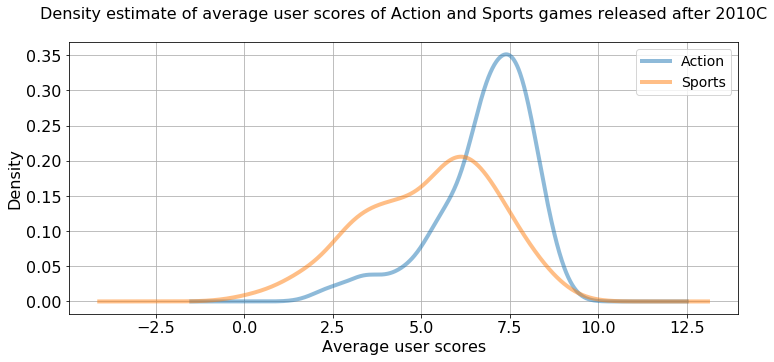

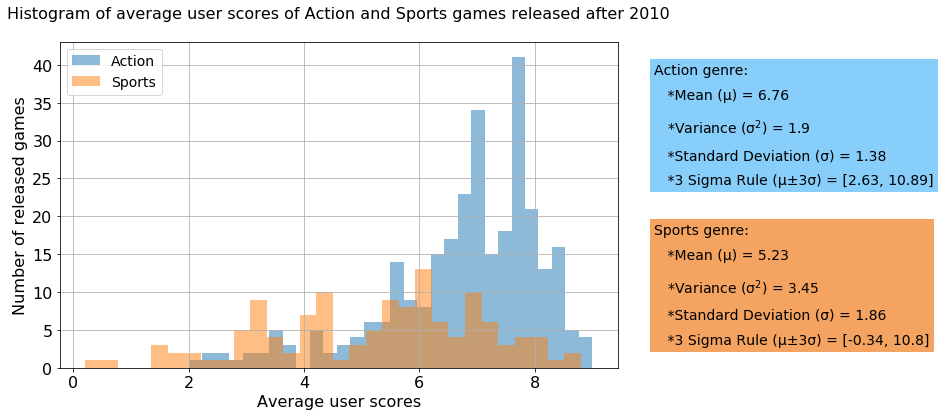


User score outliers for Action and Sports genres by 3 sigma rule:


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,min_year_platform,max_year_platform,sales_group
8833,LEGO The Hobbit,PSV,2014,Action,0.02,0.09,0.0,0.03,NaN,2.5,E10+,0.14,2011,2016,1
9460,Batman: Arkham Knight,PC,2015,Action,0.09,0.03,0.0,0.01,70.0,2.5,M,0.13,1985,2016,1
15521,Tenkai Knights: Brave Battle,3DS,2014,Action,0.01,0.01,0.0,0.00,26.0,2.4,E10+,0.02,2011,2016,0
15734,Prototype: Biohazard Bundle,PS4,2016,Action,0.01,0.00,0.0,0.00,48.0,2.0,M,0.01,2013,2016,0
16486,Super Dungeon Bros,PS4,2016,Action,0.01,0.00,0.0,0.00,42.0,2.3,E10+,0.01,2013,2016,0


In [74]:
# Outlier analysis
df_hyptest_2 = df_games_2014.loc[(~df_games_2014['user_score'].isnull()) & 
                            (df_games_2014['genre'].isin(['Action', 'Sports']))]

group = df_hyptest_2.groupby(by=['genre'])['user_score']
group_stats = group.describe()


# Plot density estimate
plt.figure()
group.plot(kind="kde", alpha=0.5, grid=True, figsize=(12,5), lw=4)
plt.title("Density estimate of average user scores of Action and Sports games released after 2010C\n", fontsize=16)
plt.xlabel("Average user scores", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Density", fontsize=16)   
plt.legend(fontsize=14)
plt.show()
print()

# Plot histogram
plt.figure()
group.plot(kind="hist", alpha=0.5, bins=30, grid=True, figsize=(10,6))
plt.title("Histogram of average user scores of Action and Sports games released after 2010\n", fontsize=16)
plt.xlabel("Average user scores", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Number of released games", fontsize=16)   
plt.legend(fontsize=14)
plt.figtext(0.95, 0.55, 
   "Action genre:\n   *Mean (\u03BC) = {}\n   *Variance (\u03C3$^2$) = {}\n   *Standard Deviation (\u03C3) = {}\n"
   "   *3 Sigma Rule (\u03BC\u00B13\u03C3) = [{}, {}]"
                     .format(group_stats.iloc[0,1].round(2), 
                            (group_stats.iloc[0,2]**2).round(2), 
                            group_stats.iloc[0,2].round(2),
                            (group_stats.iloc[0,1] - 3*group_stats.iloc[0,2]).round(2),
                            (group_stats.iloc[0,1] + 3*group_stats.iloc[0,2]).round(2)),
                      linespacing = 2, fontsize=14, backgroundcolor='lightskyblue')
plt.figtext(0.95, 0.18, 
   "Sports genre:\n   *Mean (\u03BC) = {}\n   *Variance (\u03C3$^2$) = {}\n   *Standard Deviation (\u03C3) = {}\n"
   "   *3 Sigma Rule (\u03BC\u00B13\u03C3) = [{}, {}]"
                     .format(group_stats.iloc[1,1].round(2), 
                            (group_stats.iloc[1,2]**2).round(2), 
                            group_stats.iloc[1,2].round(2),
                            (group_stats.iloc[1,1] - 3*group_stats.iloc[1,2]).round(2),
                            (group_stats.iloc[1,1] + 3*group_stats.iloc[1,2]).round(2)),
                      linespacing = 2, fontsize=14, backgroundcolor='sandybrown')
plt.show()
print()


# Get  of outliers from 3 sigma rule
genre_outliers_3sigma = df_hyptest_2[(df_hyptest_1['genre'] == 'Action') & 
                           (df_hyptest_2['user_score'] > group_stats.iloc[0,1] + 3*group_stats.iloc[0,2])]
genre_outliers_3sigma = genre_outliers_3sigma.append(df_hyptest_2[(df_hyptest_2['genre'] == 'Sports') & 
                          (df_hyptest_2['user_score'] > group_stats.iloc[1,1] + 3*group_stats.iloc[1,2])])
genre_outliers_3sigma = genre_outliers_3sigma.append(df_hyptest_2[(df_hyptest_2['genre'] == 'Action') & 
                           (df_hyptest_2['user_score'] < group_stats.iloc[0,1] - 3*group_stats.iloc[0,2])])
genre_outliers_3sigma = genre_outliers_3sigma.append(df_hyptest_2[(df_hyptest_2['genre'] == 'Sports') & 
                          (df_hyptest_2['user_score'] < group_stats.iloc[1,1] - 3*group_stats.iloc[1,2])])
print('User score outliers for Action and Sports genres by 3 sigma rule:')
display(genre_outliers_3sigma)


As in the case of the first hypothesis, we observe also observe here that the density estimates are skewed to the left and both samples have small valued outliers. Since the outliers do not correspond to anomalies in data, we also do not remove them. 

In [75]:
# Test Hypothesis 2

# Get sample 1

sample1 = df_hyptest_2.loc[(~df_games_2014['user_score'].isnull()) & 
                            (df_games_2014['genre'].isin(['Action'])), 'user_score'].to_numpy()

# Get sample 2
sample2 = df_hyptest_2.loc[(~df_games_2014['user_score'].isnull()) & 
                            (df_games_2014['genre'].isin(['Sports'])), 'user_score'].to_numpy()

# Check if sample variances differ more than 5%
eq_var = False
pct_c1 = np.abs(np.var(sample1)-np.var(sample2)) / np.var(sample1)
pct_c2 = np.abs(np.var(sample1)-np.var(sample2)) / np.var(sample2)

if pct_c1 <= 0.05 or pct_c2 <= 0.05:
    eq_var = True


alpha = .05 # critical statistical significance level
                        # if the p-value is less than alpha, we reject the hypothesis

# Perform the test
results = st.ttest_ind(sample1, sample2, equal_var=eq_var)

print('Sample mean of average user ratings for the Action genre games released after 2010:', np.mean(sample1))
print('Sample mean of average user ratings for the Sports genre games released after 2010:', np.mean(sample2))
print()
print('eq_var argument of t-test set to:', eq_var)
print()
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")
    

Sample mean of average user ratings for the Action genre games released after 2010: 6.760606060606061
Sample mean of average user ratings for the Sports genre games released after 2010: 5.2251968503937

eq_var argument of t-test set to: False

p-value:  1.1825550382644557e-14
We reject the null hypothesis


We observe that the average user scores for the two genres are also relatively close to each other. However, the p-value we get, which can practically be considered as $0$, tells us that it is very unlikely that we would get the samples we have, assuming the null hypothesis is true. Given this probability, we reject the null hypothesis and we conclude that the user scores of Action games released after 2014 are significantly different than the user scores of Sports games.

**Concluding remarks:** In this step, we tested two hypothesis to assess whether the population means of average user scores differ significantly in grouped games data samples. We saw that while we can expect the average user scores to be significantly different for Action and Sports games, this is not necessarily true for the XOne and PC platforms. 

<a class="anchor" id="step6"></a> 
### Step 6 General conclusion

In this project, we analyzed video games sales data dating back from $1977$ to $2016$. As usual, in Step 1 and Step 2 of the project, we checked the dataset information and content to identify what needs to be preprocessed for the data to be ready for analysis. The data looked like it was automatically collected from web sources, which made challenging to work with complete data. Although raw data contained ca. $17000$ game release records, for some of the features such as expert and user scores and game ratings, we had to content ourselves with querying from less than half of the  records. Overall, the quality of raw data was far from perfect, however we managed to make good use of it to draw important conclusions on how we expect the $2017$ video sales market to look like.

Indeed, in Step 3, we build the prognosis by first identifying potential winner and loser platforms. We saw that limiting ourselves to games released from $2014$ onwards was sufficient to forecast the $2017$ market while preventing us to catch lagging trend. We saw that this is a constantly growing and dynamic market with on average a new player once every year and an old player out every $6$ years and release games staying relevant for the next $3$ to $4$ years. Thus although, some of the platforms might have been quite successfull during their lifetime, targetting them in our advertising campaings would not make sense. 

After identifying potentially profitable platfroms, we shitf attention to the global sales of games on the various platforms. We found out that there are big variations in game sales even within the platforms themselves. Thus, it is not only important to target profitable platforms but also hit games, which is not an easy task. To help us understand what type of games have the potential to generate more sales, we looked at the linear dependency between review scores and sales, as well as the distribution of the genres with lowest and highest sales.  

In step 3, we only analyzed the data gloablly for the period of interest. This is why, we moved to Step 4 to study regional market variations. In particular, we created user profiles for the north american, european, and japanese regions, identifying top sales generating platforms and genres. Also, we studied the regional market shares of the games according to their ratings and identified the top three rating categories. We found out that user preferences very accross regions. While the North American and European markets share similarities, the Japanese market is quite  distinct than the latters. This means that any targeting campaign should be specialized to regions.

Finally, we tested two hypothesis to verify if the average user ratings depend significantly on the platforms and genres. Based on our study, we conclude this report with the following recommendation to the marketing department for their $2017$ campaign planning. 

**Recommendations to the marketing department:** 
- It is important to adjust the marketing campaings depending on the regions.
- Allocate half of the advertising budget to the fastest growing PS4 platform. Target PS4 in all three regions. For North America and Europe allocate budget also to XOne, for Europe to PC, and for Japan to 3DS and PSV. Sales are expected to grow on all these platforms.
- Avoid targeting PS3, X360, and Wii. Although these platforms appear to have significant market shares, they are close to the end of their lifetimes.
- The success of the marketing campaing will not only depend on choosing the right platform. Targetting games with big sales potential is equally important. Action games are without doubt the most popular genre in the global market with largest sales, however there are too many Action games and many can fail to generate high sales. On the other hand, most of the Shooter and Sports games manage to generate high sales. Thus, we recommend focusing the budget more on the latter two genres, while monitoring potentially hit Action games not to miss big opportunities. As for regional variations, Role-Playing games have the biggest sales potential in Japan. Thus, this genre should be prioritized over Action and Sports games for the Japanese market. In fact, the market shares of Sports and Shooter games is even lower than Adventure games in the Japanese market. 
- When targeting games, the critic scores are expected to be a good linear indicator on the sales performance of games compared. User scores, on the other hand, should not be taken into account as linear indicators of sales performance. - Moreover, based on the the hypotheses we tested, user scores do not seem to be good measures to compare the sales performance of games across different genres. 
- Finally, the Mature, Everyone, and Everyone10+ rated games have the biggest market share in North America and Europe. However, the japanese region differ one more time with games whose ratings are undetermined having the biggest share. It is therefore not advisable to base the marketing campaign for the Japanese market on ESBR ratings.
- If time permitted, we could have tried to make an explicit budget allocation depending on the market shares of top features.